In [ ]:
import warnings
warnings.filterwarnings( 'ignore' )

import os
import gc
import joblib
import pandas as pd
import numpy as np

import sklearn
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics, preprocessing

import tensorflow as tf
from tensorflow import keras
import tensorflow.keras.layers as klyr
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras import utils

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


pd.set_option( 'display.max_rows', 8 )
pd.set_option( 'display.max_columns', None )

(1460,) (1460,)
(1000,) (1000,) (460,) (460,)


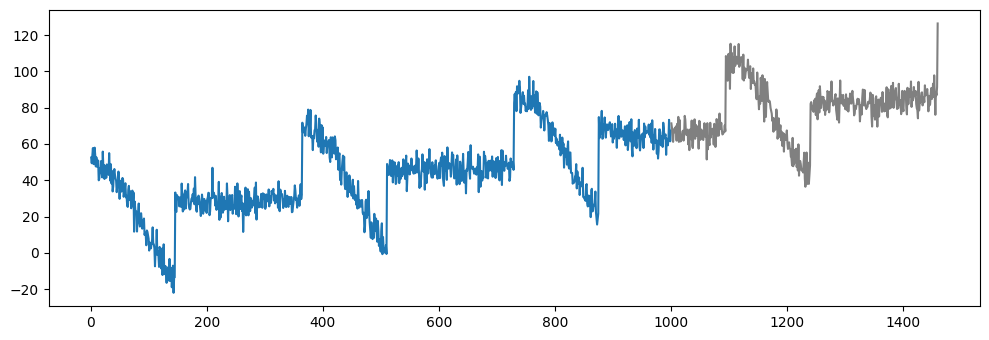

In [17]:
# handling memory leak
import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv1D, LSTM, Dense, Lambda, Bidirectional

# udfs and data prep all-in-one

def genr_trend( time, slope= 0, intercept= 0 ):
    y = slope * time + intercept  # ( y = mx + c)
    return( y )

def plot_tmSeries( time, series, format= '-', figsz= (7,4), xy_lbl = [ 'time', 'value' ] ):
    plt.figure( figsize= figsz )
    plt.plot( time, series, format )
    plt.xlabel( xy_lbl[0] );   plt.ylabel( ylabel= xy_lbl[1] );  plt.grid(True)

def seasonal_pattern( tm_season ):
    season_pattern_val = np.where(   tm_season < 0.4,
                                     np.cos( 2*np.pi*tm_season ),  1/ np.exp( 3 * tm_season )   )
    return( season_pattern_val )

def genr_seasonality( tm, period, amp= 1, phase= 0 ):
    tm_season = ( ( tm + phase ) % period )  /  period
    seasonality_val = amp * seasonal_pattern( tm_season )
    return( seasonality_val )

def addNoise( tm, noise_level= 1, seed= None ):
    rnd_genr = np.random.RandomState( seed )
    noise_data = rnd_genr.randn( len(tm) )  * noise_level
    return( noise_data)

def genr_autocorr1( tm, amp= 1, phi1= 0.8, seed= None ):
    rnd = np.random.RandomState( seed )

    autoCorr = rnd.randn( len(tm) + 1 )

    for e_step in range( start= 1, limit= len(tm) + 1 ):
        autoCorr[e_step] += phi1 * autoCorr[ e_step - 1 ]

    return( amp * autoCorr[1:] )

def genr_autocorr2( tm, amp= 1, phi1= 0.5, phi2= -0.1, seed= None,  ):
    rnd = np.random.RandomState( seed )
    autoCorr = rnd.randn( len(tm) + 50 )
    autoCorr[ :50 ] = 100
    for e_step in range( start= 50, limit= len(tm) + 50 ):
        autoCorr[e_step] += phi1 * autoCorr[ e_step - 50 ]
        autoCorr[e_step] += phi2 * autoCorr[ e_step - 33 ]
    return( amp * autoCorr[50:] )

# creating a udf for creating a windowed datasetet
def genr_windowed_data( Y_timeSeries, window_size= 5, batch_size= 2, shuffle_buffer= 10 ):
    data_windowed = tf.data.Dataset.from_tensor_slices( tensors= Y_timeSeries ) \
                                         .window( size= window_size+1, shift= 1, drop_remainder= True ) \
                                         .flat_map( lambda e_window: e_window.batch(window_size+1) ) \
                                         .shuffle( shuffle_buffer ) \
                                         .map( lambda e_window: ( e_window[:-1], e_window[-1] ) ) \
                                         .batch( batch_size ).prefetch(1)
    return( data_windowed )

def genr_windowed_Conv_data( Y_timeSeries, window_size= 5, batch_size= 2, shuffle_buffer= 10 ):
    Y_timeSeries = tf.expand_dims( input= Y_timeSeries, axis= -1 )
    data_windowed = tf.data.Dataset.from_tensor_slices( tensors= Y_timeSeries ) \
                                         .window( size= window_size+1, shift= 1, drop_remainder= True ) \
                                         .flat_map( lambda e_window: e_window.batch(window_size+1) ) \
                                         .shuffle( shuffle_buffer ) \
                                         .map( lambda e_window: ( e_window[:-1], e_window[-1] ) ) \
                                         .batch( batch_size ).prefetch(1)
    return( data_windowed )

# udf that predict and then plots predicted and actual value


def model_predict_plot_val(  split_line, y_tmSer, xval, yval, win_sz, model, ax= None, figsz= (10,4)  ):
    ''' to plot only yhat_validation '''
    y_tmSer_val = y_tmSer[ split_line-win_sz : len(y_tmSer) ]
    yhat_validationSet = []
    for e_tm in range( len(y_tmSer_val) - win_sz ):
        e_prediction_win = e_tm + win_sz
        yhat_validationSet.append(
                                            model.predict(  x= y_tmSer_val[ e_tm : e_prediction_win ][np.newaxis]  )
                                 )
        yhat_val_np = np.array( yhat_validationSet )[ :,0,0 ]         # <-- info in other dimension producted by model are not useful to us, extarcting dim only useful to us
    print(  '\nMean Absolute Error -->  ', np.round( sklearn.metrics.mean_absolute_error(yval,yhat_val_np), 2 )  )

    # plots
    if ax is None: fg, ax = plt.subplots( figsize= figsz )
    ax.plot( xval, yval, color= 'teal', label= 'y validation' )
    ax.plot( xval, yhat_val_np, color= 'orange', label= 'yhat validation' )
    ax.legend( );  plt.tight_layout()

def model_predict_plot_all( split_line, tm, y_tmSer, xval, yval, win_sz, model, ax= None, figsz= (30,11)  ):
    ''' to plot yhat and yhat_validation all '''
    yhat = []

    for e_tm in range( len(y_tmSer) - win_sz ):
        yhat.append(
                        model.predict( x= y_tmSer[e_tm:e_tm+win_sz][np.newaxis] )           # <-- np.newaxis for adjusting the input shp
                   )

    yhat_np = np.array( yhat )[ :,0,0 ]
    yhat_val_np = np.array(  yhat[ split_line - win_sz : ]  ) [:,0,0]          # for calculating MAE
    print(  '\nMean Absolute Error -->  ', np.round( sklearn.metrics.mean_absolute_error(yval,yhat_val_np), 2 )  )

    # plots
    if ax is None: fg, ax = plt.subplots( 2,1, figsize= figsz )
    # plot all data
    ax[0].plot( tm, y_tmSer, color= 'teal', label= 'y time series' )
    ax[0].plot( tm[win_sz:], yhat_np, color= 'orange', label= 'yhat' )
    ax[0].vlines(  x= split_line, ymin= y_tmSer.min(), ymax= y_tmSer.max(), color= 'red', linestyle= '--' )
    ax[0].legend( );
    # plot only validation data
    ax[1].plot( xval, yval, color= 'teal', label= 'y validation' )
    ax[1].plot( xval, yhat_val_np, color= 'orange', label= 'yhat_validation' )
    ax[1].legend( );  plt.tight_layout()

def plot_loss( model_fitting_obj, ylim= [0,100],  ax= None, figsz = (20,4.5) ):
    if ax is None: fg, ax = plt.subplots( figsize= figsz )

    # main plots
    ax.plot( model_fitting_obj.history['loss'] );            ax.plot( model_fitting_obj.history['val_loss'] )
    ax.set_xlabel('Epoch');  ax.set_ylabel('Loss %')
    # axes attributes
    ax.spines['bottom'].set_color('red'); ax.spines['top'].set_color('red')
    ax.xaxis.label.set_color('red'); ax.yaxis.label.set_color('red')
    ax.tick_params( axis= 'x', colors= 'red' ); ax.tick_params( axis= 'y', colors= 'red' )
    ax.set_title( 'Model Loss over Training and Validation dataset' , color ='blue' )
    ax.legend( ['Train dataset', 'Validation dataset'], loc= 'upper right' )
    # set y axis range
    ax.set_ylim( ylim )
#     plt.show()

## constants for data creation
baseline = 10 ;     slope_val = 0.05  ;  amp_val = 40 ;     noise_lvl = 5  ;   period_val = 365

tm1 = np.arange( 1, stop= 4*365+1, dtype= np.float16 )

## y time series with:   Trend  +  Seasonality  +  Noise

y_tmSer =  genr_trend( tm1, slope= slope_val, intercept= baseline ) \
                + genr_seasonality( tm1, period= period_val, amp= amp_val ) \
                + addNoise( tm1, noise_level= noise_lvl, seed= 42 )

print( tm1.shape, y_tmSer.shape )

## Train-Validation set split

split_line = 1000

xtrn =     tm1[ : split_line ]  ;         xval =     tm1[ split_line : ]
ytrn = y_tmSer[ : split_line ]  ;         yval = y_tmSer[ split_line : ]

print(  xtrn.shape, ytrn.shape, xval.shape, yval.shape )

## windowing the data

win_sz = 20;         batch_sz = 32;              shuffle_buff_sz = 1000

ytrn_win  =  genr_windowed_data(  Y_timeSeries= ytrn, window_size= win_sz, batch_size= batch_sz, shuffle_buffer= shuffle_buff_sz  )
yval_win  =  genr_windowed_data(  Y_timeSeries= yval, window_size= win_sz, batch_size= batch_sz, shuffle_buffer= shuffle_buff_sz  )

fg, ax = plt.subplots( figsize= (10,3.5) )
ax.plot( xtrn, ytrn );    ax.plot( xval, yval, color= 'gray' );             plt.tight_layout()


## Time Series as Inputs to a Model


The easiest way to incorporate time series into the machine learning pipeline is to use them as features in a model.


### Classifying a time series

<br>

We have the heartbeat data where some recordings are normal heartbeat activity, while others are abnormal activity. We will develop a model that distinguishes normal from abnormal heartbeat.
    
    - Considering y value for each time step as features
    - using average, median, model, SD, max, min, range, etc value as features
    
to predict whether it is normal or abnormal heartbeat. The frequency i.e # observation / sec fot his data is 2205

In [ ]:
heartN_df    =   pd.read_csv( 'datasets/heart_audio_normal_big.csv',   sep= ',', index_col= [0] ).T
heartAbN_df  =   pd.read_csv( 'datasets/heart_audio_abnormal_big.csv', sep= ',', index_col= [0] ).T

# data ( each time step is considered as a features, i.e. 8820 features  )
print(  heartN_df.shape, heartAbN_df.shape );   heartN_df.head()

(58, 8820) (58, 8820)


time  0.000000  0.000454  0.000907  0.001361  0.001814  0.002268  0.002721  \
1    -0.000995 -0.003381 -0.000948 -0.000766  0.000469  0.001511  0.007789   
2     0.000281  0.000381  0.000063  0.000026 -0.000432  0.000075 -0.001401   
3     0.002953  0.003034  0.000292 -0.005916 -0.005307 -0.003470 -0.010840   
4     0.005497  0.010088  0.008272  0.009358  0.009418  0.009649  0.008688   
5     0.000433  0.000554  0.000232  0.000538  0.001081  0.000381 -0.000096   

time  0.003175  0.003628  0.004082  ...  3.995465  3.995918  3.996372  \
1    -0.000887 -0.091828 -0.120524  ... -0.000034  0.000034  0.000192   
2    -0.002424 -0.002455 -0.003432  ... -0.007169 -0.010088 -0.006626   
3    -0.010687 -0.016578 -0.014512  ... -0.001623  0.001349 -0.002345   
4     0.009208  0.009080  0.007345  ...  0.008030  0.007348  0.006494   
5     0.000055 -0.000079 -0.000440  ...  0.000458 -0.000212 -0.000689   

time  3.996825      3.997279  3.997732  3.998186  3.998639  3.999093  3.999546  
1     0.000552  2.316200e-04 -0.000089 -0.000112 -0.000233 -0.000103 -0.000367  
2    -0.004099 -2.884134e-03 -0.005931 -0.004839 -0.000591 -0.001320  0.000652  
3    -0.001517  4.005285e-03  0.002474  0.004467  0.016809  0.008762  0.004442  
4     0.006118  6.328213e-03  0.007786  0.008496  0.008140  0.006197  0.003648  
5    -0.000850 -5.362610e-07  0.000316 -0.000269  0.000166 -0.000368 -0.001292  

[5 rows x 8820 columns]

In [ ]:
freq_obs = 2205  # given

x_time = np.arange( stop= len(heartN_df) ) / freq_obs
print( list( np.round(x_time,4)) )

[0.0, 0.0005, 0.0009, 0.0014, 0.0018, 0.0023, 0.0027, 0.0032, 0.0036, 0.0041, 0.0045, 0.005, 0.0054, 0.0059, 0.0063, 0.0068, 0.0073, 0.0077, 0.0082, 0.0086, 0.0091, 0.0095, 0.01, 0.0104, 0.0109, 0.0113, 0.0118, 0.0122, 0.0127, 0.0132, 0.0136, 0.0141, 0.0145, 0.015, 0.0154, 0.0159, 0.0163, 0.0168, 0.0172, 0.0177, 0.0181, 0.0186, 0.019, 0.0195, 0.02, 0.0204, 0.0209, 0.0213, 0.0218, 0.0222, 0.0227, 0.0231, 0.0236, 0.024, 0.0245, 0.0249, 0.0254, 0.0259]


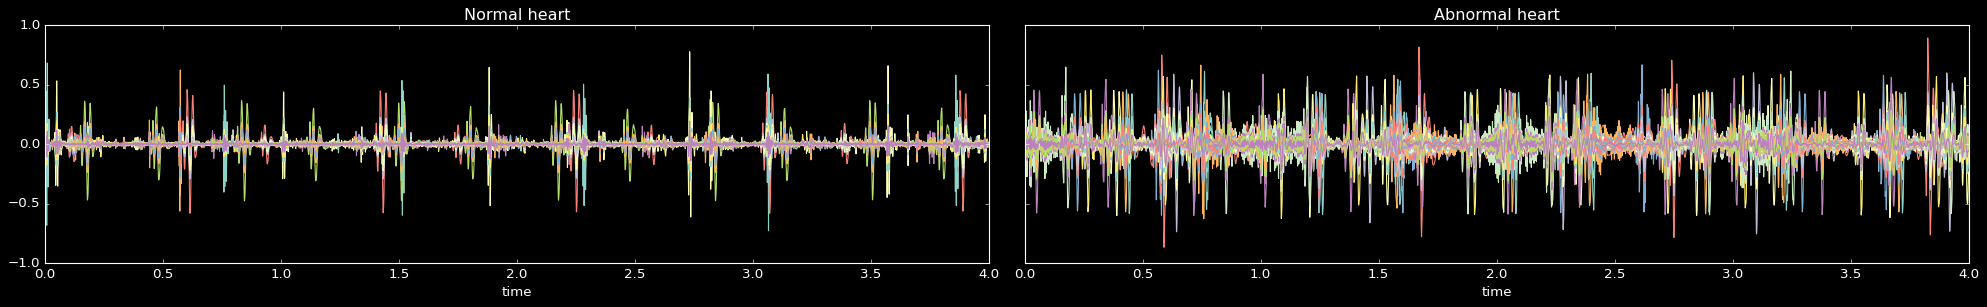

In [ ]:
fg, ax = plt.subplots( 1,2, figsize= (25,4), sharey= True, sharex= True )
heartN_df.T.plot( ax= ax[0] );  heartAbN_df.T.plot( ax= ax[1] )
ax[0].set_title('Normal heart');  ax[1].set_title('Abnormal heart')
[ e_ax.get_legend().remove() for e_ax in ax.flatten() ];
plt.tight_layout()

In [ ]:
# prep for ylabel

normal_ls = len(heartN_df)*['normal']  ;               abNormal_ls =  len(heartAbN_df)*['abnormal']
heart_cond = len(heartN_df)*['normal'] + len(heartAbN_df)*['abnormal']

heart_df = pd.concat(  [ heartN_df, heartAbN_df  ], axis= 'rows'  )

heart_df['heart_cond'] = heart_cond

heart_df.head()

time       0.0  0.000454  0.000907  0.001361  0.001814  0.002268  0.002721  \
1    -0.000995 -0.003381 -0.000948 -0.000766  0.000469  0.001511  0.007789   
2     0.000281  0.000381  0.000063  0.000026 -0.000432  0.000075 -0.001401   
3     0.002953  0.003034  0.000292 -0.005916 -0.005307 -0.003470 -0.010840   
4     0.005497  0.010088  0.008272  0.009358  0.009418  0.009649  0.008688   
5     0.000433  0.000554  0.000232  0.000538  0.001081  0.000381 -0.000096   

time  0.003175  0.003628  0.004082  ...  3.995918  3.996372  3.996825  \
1    -0.000887 -0.091828 -0.120524  ...  0.000034  0.000192  0.000552   
2    -0.002424 -0.002455 -0.003432  ... -0.010088 -0.006626 -0.004099   
3    -0.010687 -0.016578 -0.014512  ...  0.001349 -0.002345 -0.001517   
4     0.009208  0.009080  0.007345  ...  0.007348  0.006494  0.006118   
5     0.000055 -0.000079 -0.000440  ... -0.000212 -0.000689 -0.000850   

time      3.997279  3.997732  3.998186  3.998639  3.999093  3.999546  \
1     2.316200e-04 -0.000089 -0.000112 -0.000233 -0.000103 -0.000367   
2    -2.884134e-03 -0.005931 -0.004839 -0.000591 -0.001320  0.000652   
3     4.005285e-03  0.002474  0.004467  0.016809  0.008762  0.004442   
4     6.328213e-03  0.007786  0.008496  0.008140  0.006197  0.003648   
5    -5.362610e-07  0.000316 -0.000269  0.000166 -0.000368 -0.001292   

time  heart_cond  
1         normal  
2         normal  
3         normal  
4         normal  
5         normal  

[5 rows x 8821 columns]

#### Considering each timestep as features

In [ ]:
# train-test split

xx = heart_df.iloc[ :, :-1 ].values;  yy = heart_df.iloc[ :, -1: ].values.reshape(-1)
xtrn, xtst, ytrn, ytst = sklearn.model_selection.train_test_split( heart_df.iloc[ :, :-1 ].values, heart_df.iloc[ :, -1: ].values,  test_size= 25/100, random_state= 10 )

print( xtrn.shape, ytrn.shape, xtst.shape, ytst.shape, '\n' )

# we need y shape as (a,) and not as (a,1), so
ytrn = ytrn.reshape( -1 );    ytst = ytst.reshape( -1 )
ytrn.shape, ytst.shape

(87, 8820) (87, 1) (29, 8820) (29, 1) 



((87,), (29,))

In [ ]:
# Linear SVM

model1 = sklearn.svm.LinearSVC()
model1.fit( X= xtrn, y= ytrn )

yhat = model1.predict( xtst )

conf_matrix =  sklearn.metrics.confusion_matrix( ytst, yhat )
accu_score  =  sklearn.metrics.accuracy_score( ytst, yhat )

print( conf_matrix, '\n\n', accu_score )

## CV score
accu_CVscore  = sklearn.model_selection.cross_val_score(  estimator= model1, X= xx, y= yy, cv= 5, n_jobs= -1  )
print( '\nCross Validation Accuracy score \t-->\t', accu_CVscore )


[[11  0]
 [ 0 18]] 

 1.0

Cross Validation Accuracy score 	-->	 [0.91666667 1.         1.         1.         1.        ]


In [ ]:
print(  list( model1.predict( xtst ) )  )

['normal', 'abnormal', 'normal', 'abnormal', 'abnormal', 'normal', 'abnormal', 'abnormal', 'normal', 'normal', 'normal', 'normal', 'abnormal', 'normal', 'abnormal', 'normal', 'normal', 'normal', 'normal', 'normal', 'abnormal', 'abnormal', 'normal', 'normal', 'normal', 'normal', 'normal', 'abnormal', 'abnormal']


In [ ]:
print(  list( ytst )  )

['normal', 'abnormal', 'normal', 'abnormal', 'abnormal', 'normal', 'abnormal', 'abnormal', 'normal', 'normal', 'normal', 'normal', 'abnormal', 'normal', 'abnormal', 'normal', 'normal', 'normal', 'normal', 'normal', 'abnormal', 'abnormal', 'normal', 'normal', 'normal', 'normal', 'normal', 'abnormal', 'abnormal']


<br>

#### Considering statistical parameters as features
<br>

In [ ]:
print( xx.shape )
import scipy
import scipy.stats
import stats_param

xx_stats_param = np.column_stack(  [ np.mean( xx, axis= 1 ), np.median( xx, axis= 1 ), np.max( xx, axis= 1 ), np.min( xx, axis= 1 ),
                                  np.std( xx, axis= 1 ), np.max( xx, axis= 1 )- np.min( xx, axis= 1 )                   ] )

print( stats_param.shape )

model1 = sklearn.svm.LinearSVC()

accu_CVscore  = sklearn.model_selection.cross_val_score(  estimator= model1, X= xx_stats_param, y= yy, cv= 10, n_jobs= -1  )
print( '\nCross Validation Accuracy score \t-->', np.round(np.mean(accu_CVscore),2) , '\n\n', np.round(accu_CVscore,3)  )

(116, 8820)
(116, 6)

Cross Validation Accuracy score 	--> 0.76 

 [0.667 0.667 1.    0.917 0.833 0.75  0.636 0.818 0.636 0.636]


## Sequences & Prediction

<br>

##### Data Generation

In [ ]:
# trend

def trend( time, slope= 0, intercept= 0 ):
    y = slope * time + intercept  # ( y = mx + c)
    return( y )

def plot_tmSeries( time, series, format= '-', figsz= (7,4), xy_lbl = [ 'time', 'value' ] ):
    plt.figure( figsize= figsz )
    plt.plot( time, series, format )
    plt.xlabel( xy_lbl[0] );   plt.ylabel( ylabel= xy_lbl[1] );  plt.grid(True)

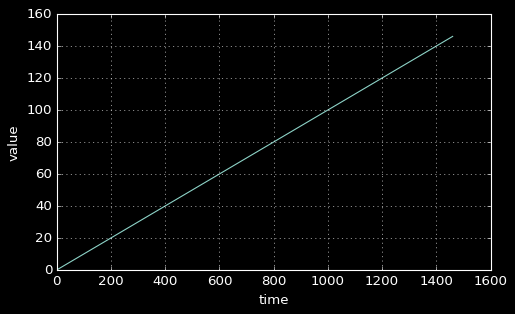

In [ ]:
plt.style.use( 'dark_background' )

time_1 = np.arange( 4*365 + 1 )
baseline = 10
series = trend( time_1, slope= 0.1 )

plot_tmSeries( time_1, series )

##### Seasonality

In [ ]:
# func to generate seasonal pattern

def seasonal_pattern( tm_season ):
    season_pattern_val = np.where(  tm_season < 0.4,
                                    np.cos( 2*np.pi*tm_season ),  1/ np.exp( 3 * tm_season )
                                 )
    return( season_pattern_val )

def seasonality( tm, period, amp= 1, phase= 0 ):
    tm_season = ( ( tm + phase ) % period )  /  period
    seasonality_val = amp * seasonal_pattern( tm_season )
    return( seasonality_val )


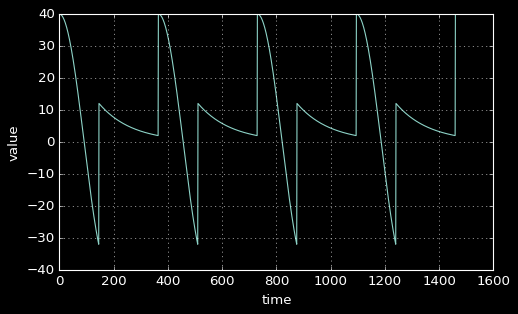

In [ ]:
bsline = 10;  tm1 = np.arange( 4*365 + 1 )
y_tmSer1 = seasonality( tm= tm1, period= 365, amp= 40 )
plot_tmSeries( tm1, y_tmSer1 );

#### Seasonality, Trend & Noise

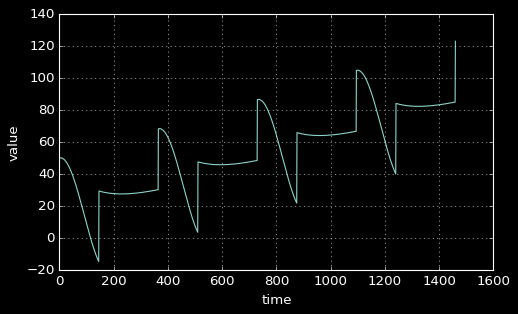

In [ ]:
bsline_c = 10;  tm1 = np.arange( 4*365 + 1 )

y_tmSer1 =  trend( time= tm1, slope= 0.05, intercept= bsline_c ) \
                + seasonality(  tm= tm1, period= 365, amp= 40 )

plot_tmSeries( time= tm1, series= y_tmSer1 )

In [ ]:
# func to add noise
def addNoise( tm, noise_level= 1, seed= None ):
    rnd_genr = np.random.RandomState( seed )
    noise_data = rnd_genr.randn( len(tm) )  * noise_level
    return( noise_data)

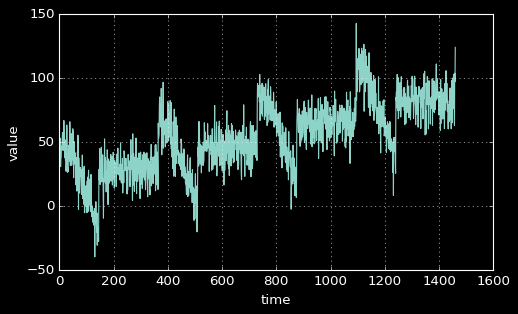

In [ ]:
y_tmSerWithNoise1 = y_tmSer1 + addNoise( tm1, noise_level= 11, seed= 15 )
plot_tmSeries( tm1, y_tmSerWithNoise1 )

##### AutoCorrelation

In [ ]:
def genr_autocorr1( tm, amp= 1, phi1= 0.8, seed= None ):
    rnd = np.random.RandomState( seed )
    autoCorr = rnd.randn( len(tm) + 1 )
    for e_step in range( start= 1, limit= len(tm) + 1 ):
        autoCorr[e_step] += phi1 * autoCorr[ e_step - 1 ]

    return( amp * autoCorr[1:] )


def genr_autocorr2( tm, amp= 1, phi1= 0.5, phi2= -0.1, seed= None,  ):
    rnd = np.random.RandomState( seed )
    autoCorr = rnd.randn( len(tm) + 50 )
    autoCorr[ :50 ] = 100
    for e_step in range( start= 50, limit= len(tm) + 50 ):
        autoCorr[e_step] += phi1 * autoCorr[ e_step - 50 ]
        autoCorr[e_step] += phi2 * autoCorr[ e_step - 33 ]

    return( amp * autoCorr[50:] )

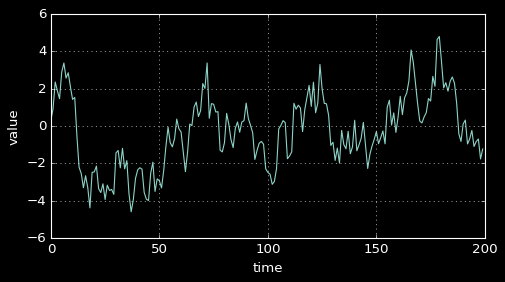

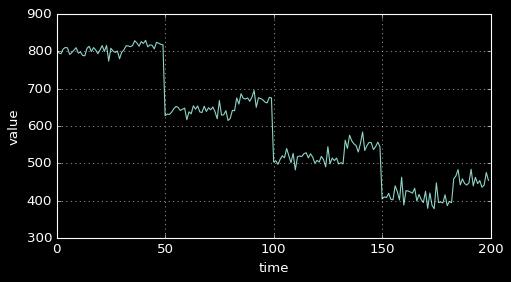

In [ ]:
y_tmSer_ac1 = genr_autocorr1( tm1, amp= 1, phi1 = .9, seed= 42 )
y_tmSer_ac2 = genr_autocorr2( tm1, amp= 10, phi1 = 0.9, phi2= -0.1, seed= 42 )

plot_tmSeries( tm1[:200], y_tmSer_ac1[:200], figsz= (7,3.5) )
plot_tmSeries( tm1[:200], y_tmSer_ac2[:200], figsz= (7,3.5) )

#### AutoCorrelation + Seasonality + Trend + Noise

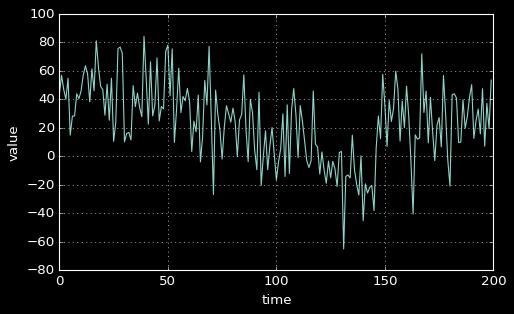

In [ ]:
y_tmSerWithNoise1 = y_tmSer1 + addNoise( tm1, noise_level= 20, seed= 15 )
plot_tmSeries( tm1[:200], y_tmSerWithNoise1[:200] )

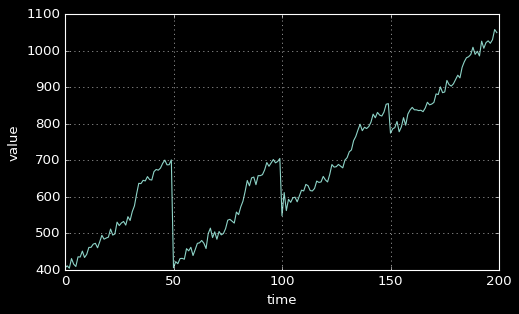

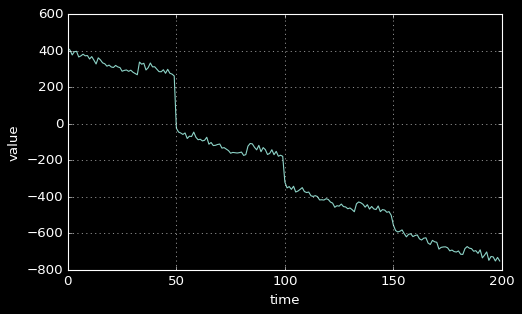

In [ ]:
# autocorr + trend

y_tmSer_AC_Trend = genr_autocorr2( tm= tm1, amp= 10 ) + trend( tm1, slope= 5 )
plot_tmSeries( tm1[:200], y_tmSer_AC_Trend[:200] )

y_tmSer_AC_Trend = genr_autocorr2( tm= tm1, amp= 10 ) + trend( tm1, slope= -4 )
plot_tmSeries( tm1[:200], y_tmSer_AC_Trend[:200] )

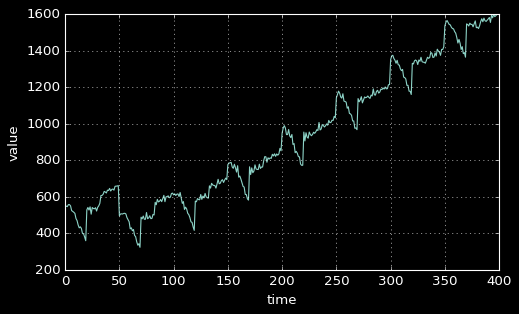

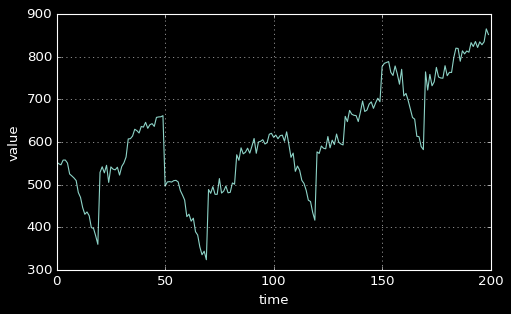

In [ ]:
# autocorr + trend + seasonality

y_tmSer_AC_Trend_Season = genr_autocorr2( tm1, amp= 10, seed= 42 )\
                            +  trend( tm1, slope= 4 )\
                            +  seasonality(  tm1, period= 50, amp= 150 )

plot_tmSeries( tm1[:400], y_tmSer_AC_Trend_Season[:400] ); plot_tmSeries( tm1[:200], y_tmSer_AC_Trend_Season[:200] )

##### TimeSeries with a event that changes everything

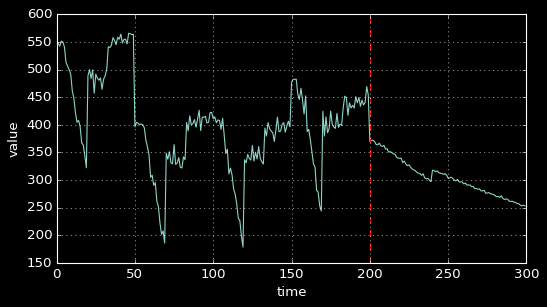

In [ ]:
y_tmSer_AC_Trend_Season_1 = genr_autocorr2( tm1, amp=10, seed= 42 )\
                                +  seasonality( tm1, period= 50, amp= 150 )\
                                +  trend( tm1, slope= 2 )

y_tmSer_AC_Trend_Season_2 = genr_autocorr2( tm1, amp= 1.2, seed= 42 )\
                                +  seasonality( tm1, period= 100, amp= 20 )\
                                +  trend( tm1, slope= -1, intercept= 550 )

suddenEvent_time = 200
y_tmSer_AC_Trend_Season_1[suddenEvent_time:] = y_tmSer_AC_Trend_Season_2[suddenEvent_time:]        # sudden event after suddenEvent_time

plot_tmSeries( tm1[:300], series= y_tmSer_AC_Trend_Season_1[:300] )
plt.axvline( x= suddenEvent_time, color= 'r', linestyle= '--' )
plt.tight_layout()

#### Impulse

In [ ]:
def genr_impulse( tm, num_impluse, amp= 1, seed= None  ):
    rnd = np.random.RandomState( seed )
    impulse_indices = rnd.randint( len(tm), size= num_impluse )            # randomly selected indices of the x-time
    tmSer_ImpulsePt = np.zeros( shape= len(tm) )
    for e_idx in impulse_indices:
        tmSer_ImpulsePt[e_idx] +=  amp * rnd.rand()

    return( tmSer_ImpulsePt )

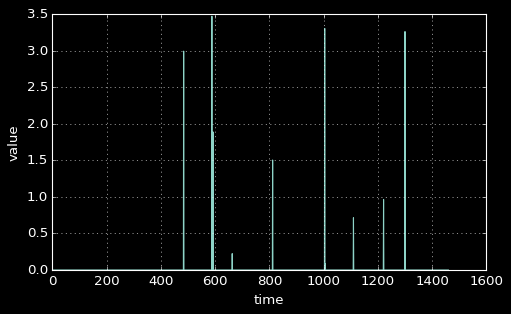

In [ ]:
tmSer_Impulse1 = genr_impulse( tm1, num_impluse= 10, amp= 5 )
plot_tmSeries( tm1, tmSer_Impulse1 )

#### Impulse + AutoCorr `-->` Interesting cocktail TimeSeries

In [ ]:
def genr_autocorrImpulse( tmSer_Impulse, lagPhi_dictn ):
    tmSer_ACimpulse = tmSer_Impulse.copy()
    lag_max = len( lagPhi_dictn )
    for e_step, e_val in enumerate( tmSer_Impulse ):
        for e_lag, e_phi in lagPhi_dictn.items():
            if e_step - e_lag > 0:  tmSer_ACimpulse[ e_step ] += e_phi * tmSer_ACimpulse[ e_step - e_lag ]

    return( tmSer_ACimpulse )

In [ ]:
tmSer_Impulse = tmSer_Impulse1[:3]
lagPhi_dictn =  { 1:0.7, 50:0.2 }

for e_step, e_val in enumerate( tmSer_Impulse ):
    print( '\ntmSer_Impulse: --> ', e_step, e_val,  )
    for e_lag, e_phi in lagPhi_dictn.items():
        print( '\t lagPhi_dictn: --> ', e_lag, e_phi  )
    print('--------------------------------------------------')


tmSer_Impulse: -->  0 0.0
	 lagPhi_dictn: -->  1 0.7
	 lagPhi_dictn: -->  50 0.2
--------------------------------------------------

tmSer_Impulse: -->  1 0.0
	 lagPhi_dictn: -->  1 0.7
	 lagPhi_dictn: -->  50 0.2
--------------------------------------------------

tmSer_Impulse: -->  2 0.0
	 lagPhi_dictn: -->  1 0.7
	 lagPhi_dictn: -->  50 0.2
--------------------------------------------------


' There is a "Decay" in the timeSeries plot. The Decay is interrupted once in a while by the pulses'

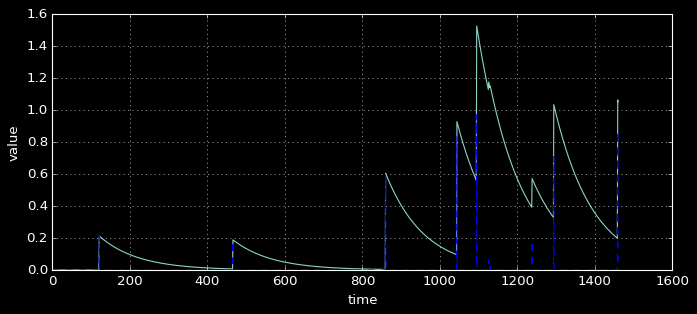

In [ ]:
tmSer_Impulse_1 = genr_impulse( tm1, num_impluse= 10, seed= 42 )
tmSer_ACimpulse_1 = genr_autocorrImpulse( tmSer_Impulse= tmSer_Impulse_1, lagPhi_dictn= {1:0.99} )

plot_tmSeries( tm1, tmSer_ACimpulse_1, figsz= (10,4) )
plt.plot( tm1, tmSer_Impulse_1, color= 'blue', linestyle= '--' )

''' There is a "Decay" in the timeSeries plot. The Decay is interrupted once in a while by the pulses'''

When the <b>`Decay`</b> is AutoCorrelated

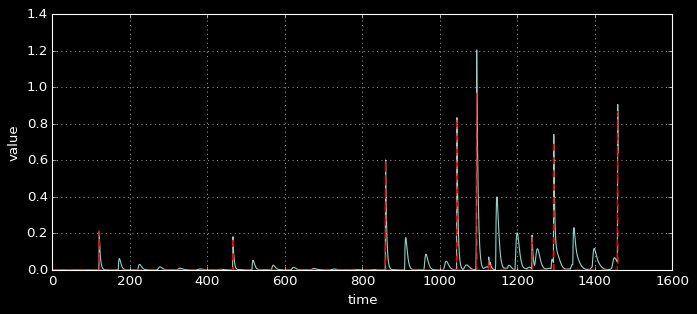

In [ ]:
tmSer_Impulse1 = genr_impulse( tm1, num_impluse= 10, seed= 42 )
tmSer_ACimpulse_1 = genr_autocorrImpulse(  tmSer_Impulse1, lagPhi_dictn= { 1:0.7, 50:0.2 }  )

plot_tmSeries( tm1, tmSer_ACimpulse_1, figsz= (10,4)  )
plt.plot( tm1, tmSer_Impulse_1, color= 'red', linestyle= '--' )

#### TimeSeries on Real data

In [ ]:
# !gdown --id 1bLnqPgwoSh6rHz_DKDdDeQyAyl8_nqT5
from pandas.plotting import autocorrelation_plot

In [ ]:
sun_df = pd.read_csv(  'datasets/Sunspots.csv', parse_dates= ['Date'], index_col= 'Date'  )
sun1M_Ser = sun_df['Monthly Mean Total Sunspot Number'].asfreq( freq= '1M' )
sun1M_Ser

Date
1749-01-31     96.7
1749-02-28    104.3
1749-03-31    116.7
1749-04-30     92.8
1749-05-31    141.7
              ...  
2018-03-31      2.5
2018-04-30      8.9
2018-05-31     13.2
2018-06-30     15.9
2018-07-31      1.6
Freq: M, Name: Monthly Mean Total Sunspot Number, Length: 3235, dtype: float64

<AxesSubplot:xlabel='Date'>

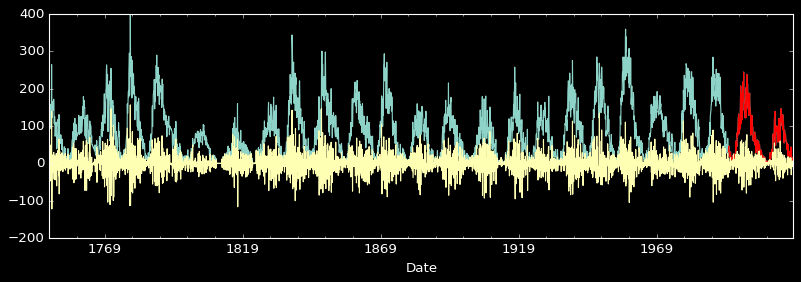

In [ ]:
# fg, ax = plt.subplots(  )

sun1M_Ser.plot( figsize= (12,4) )
sun1M_Ser[ '1995-01-01': ].plot( figsize= (12,3.5), color= 'red' )

sun1M_Ser.diff( 1 ).plot()

In [ ]:
from pandas.plotting import autocorrelation_plot
from statsmodels.tsa.stattools import acf
from statsmodels.graphics.tsaplots import plot_acf

(-0.4, 0.4)

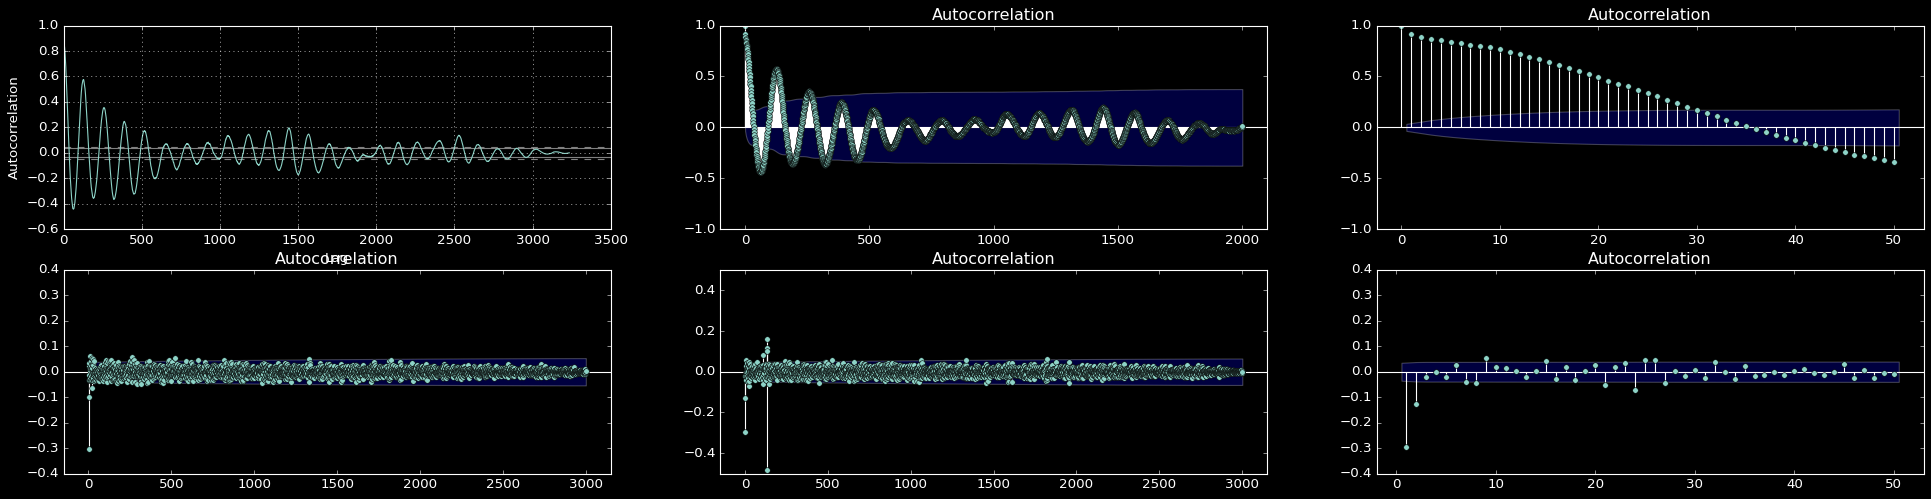

In [ ]:
fg, ax = plt.subplots( 2,3, figsize= (30,7) )

autocorrelation_plot( series= sun1M_Ser, ax= ax[0][0] );
plot_acf( sun1M_Ser, lags= 2000, ax= ax[0][1] );
plot_acf( sun1M_Ser, lags= 50, ax= ax[0][2] );

plot_acf( sun1M_Ser.diff(1)[1:], lags= 3000, zero= False, ax= ax[1][0] );
plot_acf( sun1M_Ser.diff(1)[1:].diff(11*12)[11*12+1:], lags= 3000, zero= False, ax= ax[1][1] );
plot_acf( sun1M_Ser.diff(1)[1:].diff(11*12)[11*12+1:], lags= 50, zero= False, ax= ax[1][2] );

ax[1][0].set_ylim( [-0.4,0.4] );  ax[1][1].set_ylim( [-0.5,0.5] );  ax[1][2].set_ylim( [-0.4,0.4] )

In [ ]:
[ sun1M_Ser.autocorr( lag= e_lag ) for e_lag in range(1,10) ]

[0.9173241872367176,
 0.8847544206843758,
 0.8685991231372021,
 0.8579945644357171,
 0.8433856340533108,
 0.8306731729540907,
 0.8121138897370155,
 0.7986059878541056,
 0.7890399489112042]

<br>

### Forecasting

<br>

In [ ]:
# udfs
def genr_trend( time, slope= 0, intercept= 0 ):
    y = slope * time + intercept  # ( y = mx + c)
    return( y )

def plot_tmSeries( time, series, format= '-', figsz= (7,4), xy_lbl = [ 'time', 'value' ] ):
    plt.figure( figsize= figsz )
    plt.plot( time, series, format )
    plt.xlabel( xy_lbl[0] );   plt.ylabel( ylabel= xy_lbl[1] );  plt.grid(True)

def seasonal_pattern( tm_season ):
    season_pattern_val = np.where(  tm_season < 0.4,
                                    np.cos( 2*np.pi*tm_season ),  1/ np.exp( 3 * tm_season )  )
    return( season_pattern_val )

def genr_seasonality( tm, period, amp= 1, phase= 0 ):
    tm_season = ( ( tm + phase ) % period )  /  period
    seasonality_val = amp * seasonal_pattern( tm_season )
    return( seasonality_val )

def addNoise( tm, noise_level= 1, seed= None ):
    rnd_genr = np.random.RandomState( seed )
    noise_data = rnd_genr.randn( len(tm) )  * noise_level
    return( noise_data)

def genr_autocorr1( tm, amp= 1, phi1= 0.8, seed= None ):
    rnd = np.random.RandomState( seed )

    autoCorr = rnd.randn( len(tm) + 1 )

    for e_step in range( start= 1, limit= len(tm) + 1 ):
        autoCorr[e_step] += phi1 * autoCorr[ e_step - 1 ]

    return( amp * autoCorr[1:] )

def genr_autocorr2( tm, amp= 1, phi1= 0.5, phi2= -0.1, seed= None,  ):
    rnd = np.random.RandomState( seed )

    autoCorr = rnd.randn( len(tm) + 50 )
    autoCorr[ :50 ] = 100

    for e_step in range( start= 50, limit= len(tm) + 50 ):
        autoCorr[e_step] += phi1 * autoCorr[ e_step - 50 ]

        autoCorr[e_step] += phi2 * autoCorr[ e_step - 33 ]

    return( amp * autoCorr[50:] )

# creating a udf for creating a windowed datasetet

def genr_windowed_data( Y_timeSeries, window_size= 5, batch_size= 2, shuffle_buffer= 10 ):

    data_windowed = tf.data.Dataset.from_tensor_slices( tensors= Y_timeSeries ) \
                            .window( size= window_size+1, shift= 1, drop_remainder= True ) \
                            .flat_map( lambda e_window: e_window.batch(window_size+1) ) \
                            .shuffle( shuffle_buffer ) \
                            .map( lambda e_window: ( e_window[:-1], e_window[-1] ) ) \
                            .batch( batch_size ).prefetch(1)
    return( data_windowed )

##### data creation

In [ ]:
plt.style.use( 'dark_background' )

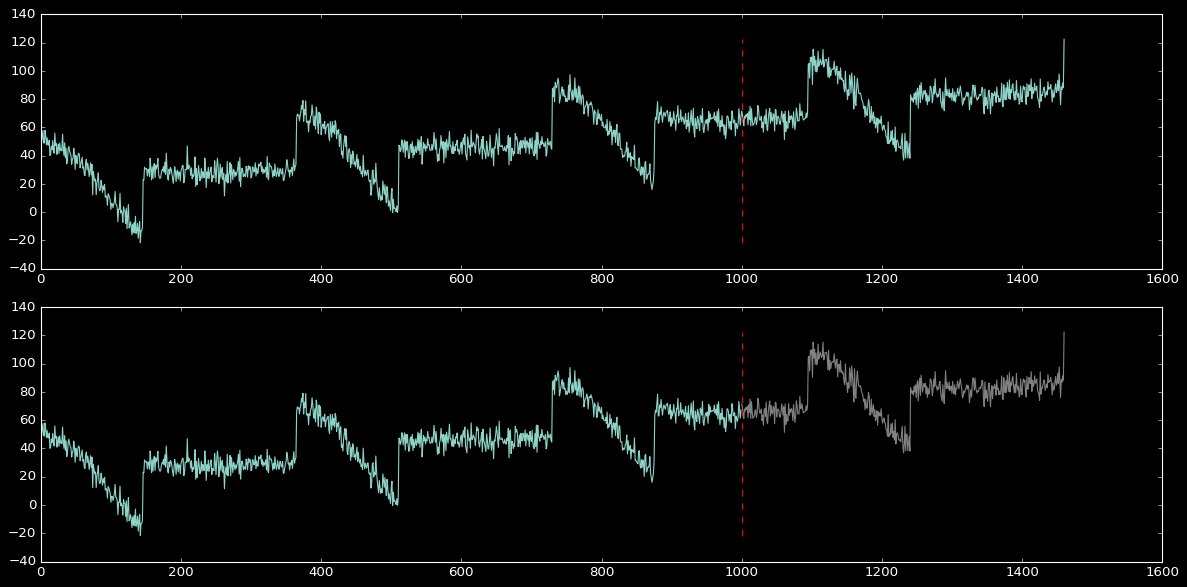

In [ ]:
## constants

baseline = 10;              slope_val = 0.05
amplitude = 40;             noise_lvl = 5

## time (x axis)
x_tm1 = np.arange(  stop= 4*365 + 1, dtype= np.float32 )

# generate time series data
y_tmSer1 = genr_trend( x_tm1, slope= slope_val, intercept= baseline ) \
                    + genr_seasonality( x_tm1, period= 365, amp= amplitude ) \
                    + addNoise( x_tm1, noise_level= noise_lvl, seed= 42 )

# plots
fg, ax = plt.subplots( 2,1, figsize= (15,7.5) )
ax[0].plot(  x_tm1, y_tmSer1 )

## train-validation split
split_tm = 1000

ax[0].vlines( x= split_tm, ymin= y_tmSer1.min(), ymax= y_tmSer1.max(), color= 'red', linestyle= '--' )    # Train & Validation set

# Train set
xtrn_tm = x_tm1[ :split_tm ];       ytrn_tmSer = y_tmSer1[ :split_tm ]

# Validation set
xval_tm = x_tm1[ split_tm: ];       yval_tmSer = y_tmSer1[ split_tm: ]

ax[1].plot( xtrn_tm, ytrn_tmSer );   ax[1].plot( xval_tm, yval_tmSer, color= 'gray', linestyle= '-' )
ax[1].vlines( x= split_tm, ymin= y_tmSer1.min(), ymax= y_tmSer1.max(), color= 'red', linestyle= '--' )    # Train & Validation set

plt.tight_layout()

<br>

### Prediction <br>

#### Naive Forecast Approach (Baseline model)

'It can be observed that the naive forecast lags 1 step behind the time series.'

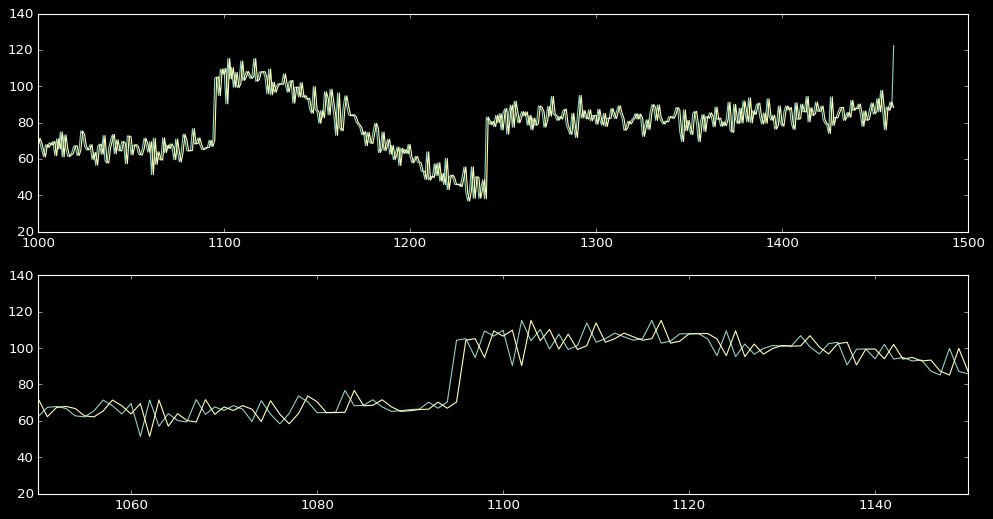

In [ ]:
yhat_Naive = y_tmSer1[ split_tm-1 : -1  ]

fg, ax = plt.subplots( 2,1, figsize= (15,7.5) )

ax[0].plot( xval_tm, yval_tmSer );  ax[0].plot( xval_tm, yhat_Naive )
ax[1].plot( xval_tm, yval_tmSer );  ax[1].plot( xval_tm, yhat_Naive )
ax[1].set_xlim( [1050,1150] )

'''It can be observed that the naive forecast lags 1 step behind the time series.'''

In [ ]:
## metrics for Baseline Average

print( f'MSE = { round( sklearn.metrics.mean_squared_error( yval_tmSer, yhat_Naive ) ) }'  )
print( f'MAE = { round( keras.metrics.mean_absolute_error( yval_tmSer, yhat_Naive ) ) }'  )

MSE = 62.0
MAE = 6.0


#### Moving Average model using rolling average

MSE = 102.0
MAE = 7.0


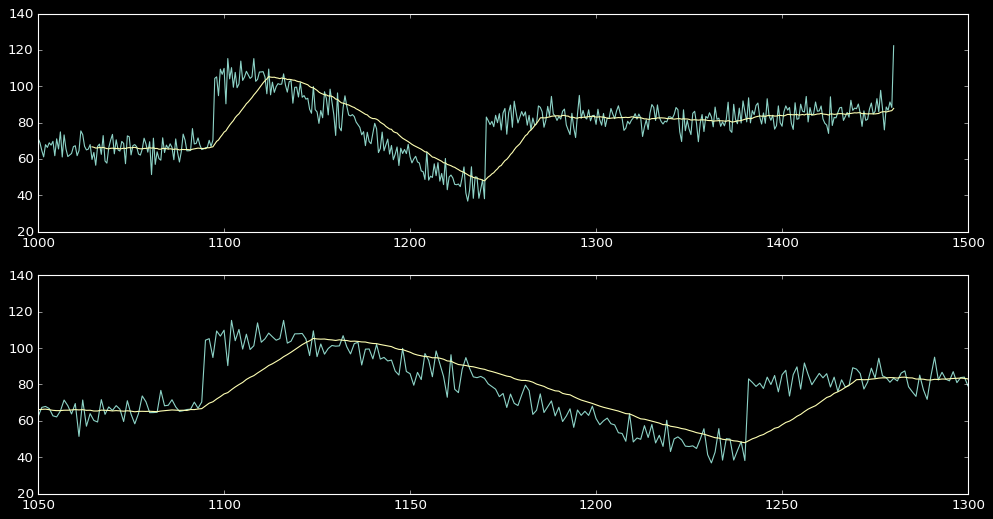

In [ ]:
yhat_roll = pd.Series( yval_tmSer ).rolling( window= 30 ).mean()

## plots
fg, ax = plt.subplots( 2,1, figsize= (15,7.5) )

ax[0].plot( xval_tm, yval_tmSer );  ax[0].plot( xval_tm, yhat_roll )
ax[1].plot( xval_tm, yval_tmSer );  ax[1].plot( xval_tm, yhat_roll )
ax[1].set_xlim( [1050,1300] )

## metrics
num_nan = yhat_roll.isna().sum()
print( f'MSE = { round( sklearn.metrics.mean_squared_error( yval_tmSer[num_nan:], yhat_roll[num_nan:] ) ) }'  )
print( f'MAE = { round(keras.metrics.mean_absolute_error( yval_tmSer[num_nan:], yhat_roll[num_nan:] ) ) }'  )

That's worse than naive forecast! The moving average does not anticipate trend or seasonality, so let's try to remove them by using differencing. Since the seasonality period is 365 days, we will subtract the value at time t – 365 from the value at time t.

The trend & seasonality seem to be gone, so now we can use the moving average.


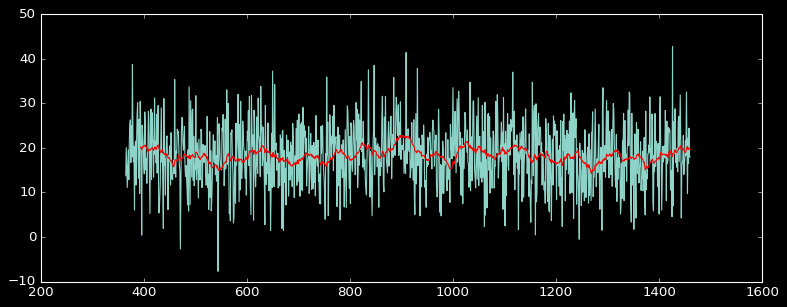

In [ ]:
y_tmSer_diff = pd.Series(y_tmSer1).diff( 365 )
y_tmSer_diff.plot( figsize= (10,4) );

print( 'The trend & seasonality seem to be gone, so now we can use the moving average.' )

## Moving average
y_tmSer_diff_roll = y_tmSer_diff.rolling( 30 ).mean()
y_tmSer_diff_roll.plot( color= 'red' )

plt.tight_layout()

MSE = 48.0
MAE = 6.0


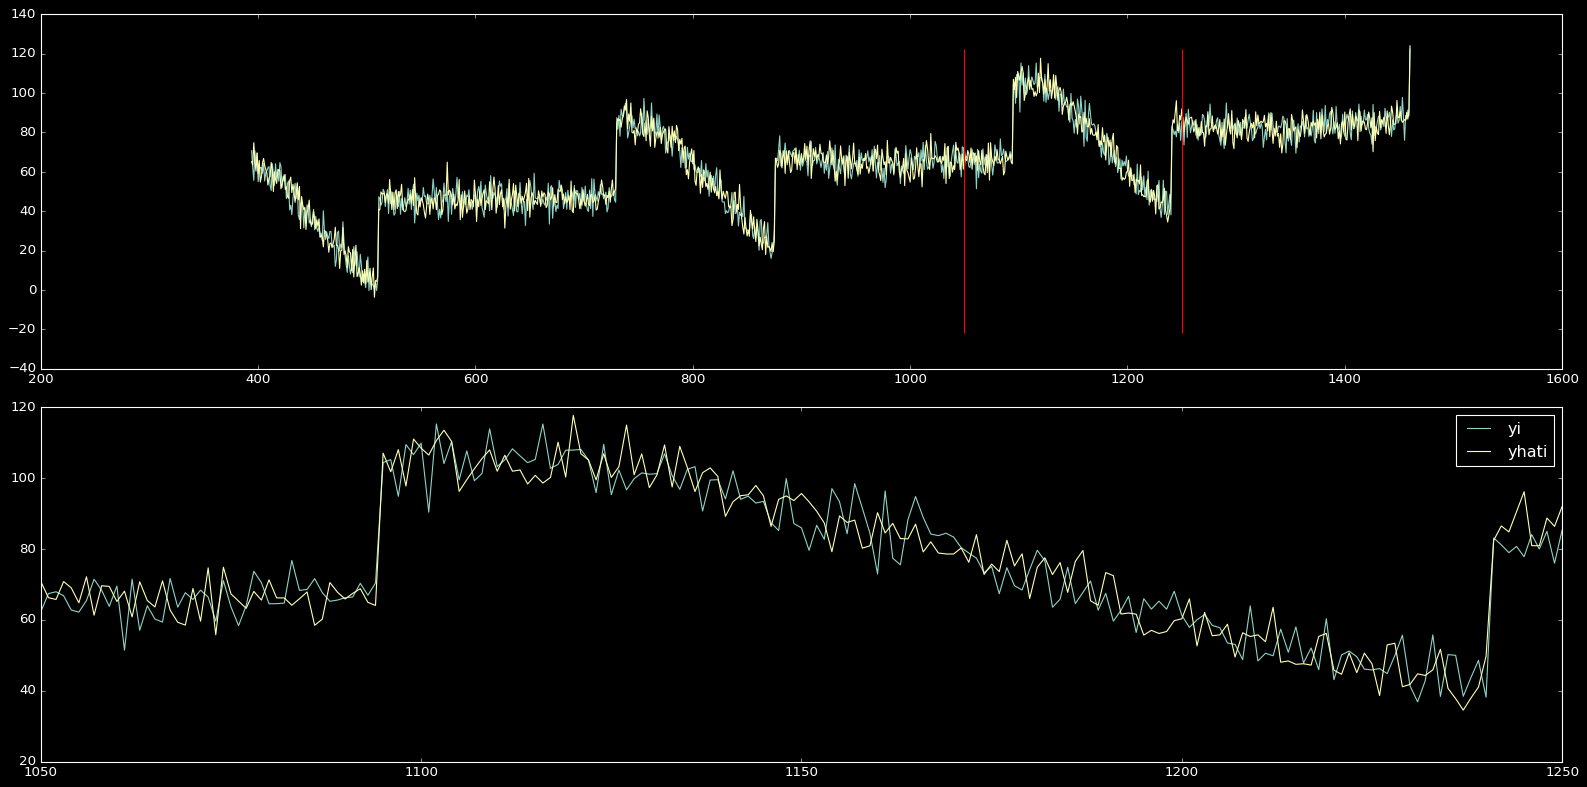

In [ ]:
# Now let's bring back the trend and seasonality by adding the past values from t – 365:

num_nan = y_tmSer_diff_roll.isna().sum()
yhat_MA = y_tmSer1[ num_nan-365: -365 ] +  y_tmSer_diff_roll[ num_nan: ]

# plots
fg, ax = plt.subplots( 2,1, figsize= (20,10) )

zm_ls = [ 1050,1250 ]
ax[0].plot( x_tm1[ num_nan: ], y_tmSer1[ num_nan: ] );   ax[0].plot( x_tm1[ num_nan: ], yhat_MA )
ax[0].vlines( x= zm_ls, ymin= y_tmSer1.min(), ymax= y_tmSer1.max(), color= 'red' )    # Train & Validation set

ax[1].plot( x_tm1[ num_nan: ], y_tmSer1[ num_nan: ], label= 'yi'  );  ax[1].plot( x_tm1[ num_nan: ], yhat_MA, label= 'yhati' )
ax[1].set_xlim( zm_ls );   ax[1].set_ylim( [20,120] );
ax[1].legend()

plt.tight_layout()

## metrics
# num_nan = yhat_roll.isna().sum()
print( f'MSE = { round( sklearn.metrics.mean_squared_error( y_tmSer1[num_nan: ], yhat_MA ) ) }'  )
print( f'MAE = { round(keras.metrics.mean_absolute_error( y_tmSer1[num_nan: ], yhat_MA  ) ) }'  )

<br>

##  Deep Neural Networks for Time Series

    - Train Neural networks to recognize & predict on time series
<br>

#### Time Series Data Preparation (features & labels) using keras `TimeseriesGenerator()`


<br>


<br>
<h3><p style= 'text-align:left;'>Features & label for ML on Time Series data</p></h3>
<img src= 'images/timeSeries_ML_features_lbl5.jpg' style= 'width:700px;height:424px;'>

<br>
<h3><p style= 'text-align:center;'>tf.keras.preprocessing.sequence.TimeseriesGenerator output</p></h3>
<img src= 'images/NN time series input.jpg' style= 'width:3302;height:992;'>
<br>

*[Go to top](#toc)*

<!-- m, wd, ht = 2, 990, 576; ( wd/m, ht/m  ) -->

In [ ]:
from IPython.display import Image, display
from keras.preprocessing.sequence import TimeseriesGenerator

In [ ]:
energy_df = pd.read_csv( 'datasets/energydata_complete.csv', parse_dates= ['date'], index_col= ['date'] )
print( energy_df.shape ); energy_df.head(2)

(19735, 28)


Appliances  lights     T1       RH_1    T2     RH_2  \
date                                                                       
2016-01-11 17:00:00          60      30  19.89  47.596667  19.2  44.7900   
2016-01-11 17:10:00          60      30  19.89  46.693333  19.2  44.7225   

                        T3   RH_3    T4       RH_4         T5  RH_5        T6  \
date                                                                            
2016-01-11 17:00:00  19.79  44.73  19.0  45.566667  17.166667  55.2  7.026667   
2016-01-11 17:10:00  19.79  44.79  19.0  45.992500  17.166667  55.2  6.833333   

                          RH_6    T7       RH_7    T8       RH_8         T9  \
date                                                                          
2016-01-11 17:00:00  84.256667  17.2  41.626667  18.2  48.900000  17.033333   
2016-01-11 17:10:00  84.063333  17.2  41.560000  18.2  48.863333  17.066667   

                      RH_9     T_out  Press_mm_hg  RH_out  Windspeed  \
date                                                                   
2016-01-11 17:00:00  45.53  6.600000        733.5    92.0   7.000000   
2016-01-11 17:10:00  45.56  6.483333        733.6    92.0   6.666667   

                     Visibility  Tdewpoint        rv1        rv2  
date                                                              
2016-01-11 17:00:00   63.000000        5.3  13.275433  13.275433  
2016-01-11 17:10:00   59.166667        5.2  18.606195  18.606195

In [ ]:
energy_df.date = pd.to_datetime(  energy_df.date, infer_datetime_format= True )
energy_df.set_index( 'date', drop= True, inplace= True )
myEnergy_df = energy_df[ [ 'T_out', 'RH_2', 'Appliances' ] ]

print( '\n', myEnergy_df.head(3), myEnergy_df.shape, '\n\n' );   myEnergy_df.info()


                         T_out       RH_2  Appliances
date                                                
2016-01-11 17:00:00  6.600000  44.790000          60
2016-01-11 17:10:00  6.483333  44.722500          60
2016-01-11 17:20:00  6.366667  44.626667          50 (19735, 3) 


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 19735 entries, 2016-01-11 17:00:00 to 2016-05-27 18:00:00
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   T_out       19735 non-null  float64
 1   RH_2        19735 non-null  float64
 2   Appliances  19735 non-null  int64  
dtypes: float64(2), int64(1)
memory usage: 616.7 KB


In [ ]:
# making sure there is a continuous data with no null for every next 10 mins
myEnergy_df = myEnergy_df.rolling( window= '10T' ).mean()
myEnergy_df.head(3)

T_out       RH_2  Appliances
date                                                
2016-01-11 17:00:00  6.600000  44.790000        60.0
2016-01-11 17:10:00  6.483333  44.722500        60.0
2016-01-11 17:20:00  6.366667  44.626667        50.0

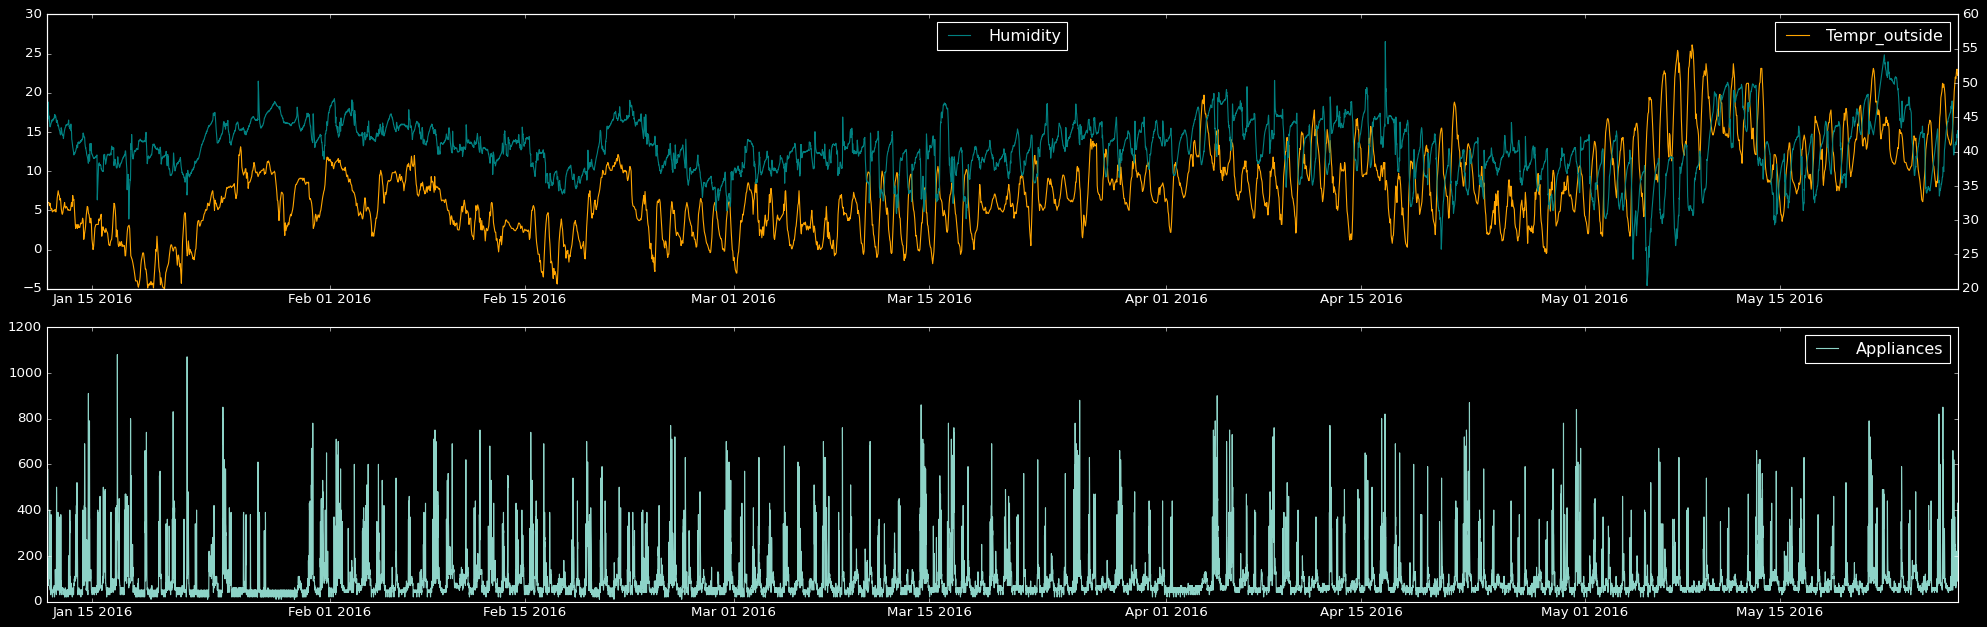

In [ ]:
fg, ax = plt.subplots( 2,1, figsize= (25,8) )

ax[0].plot( myEnergy_df[ ['T_out'] ], label= 'Tempr_outside', color= 'orange' )
ax_ = ax[0].twinx()
ax_.plot( myEnergy_df[ 'RH_2' ],  label= 'Humidity', color= 'teal' )

ax[1].plot( myEnergy_df[ 'Appliances' ], label= 'Appliances' )

ax[0].legend( loc= 'best' );   ax_.legend( loc= 'upper center' );  ax[1].legend( loc= 'best' );

plt.tight_layout()

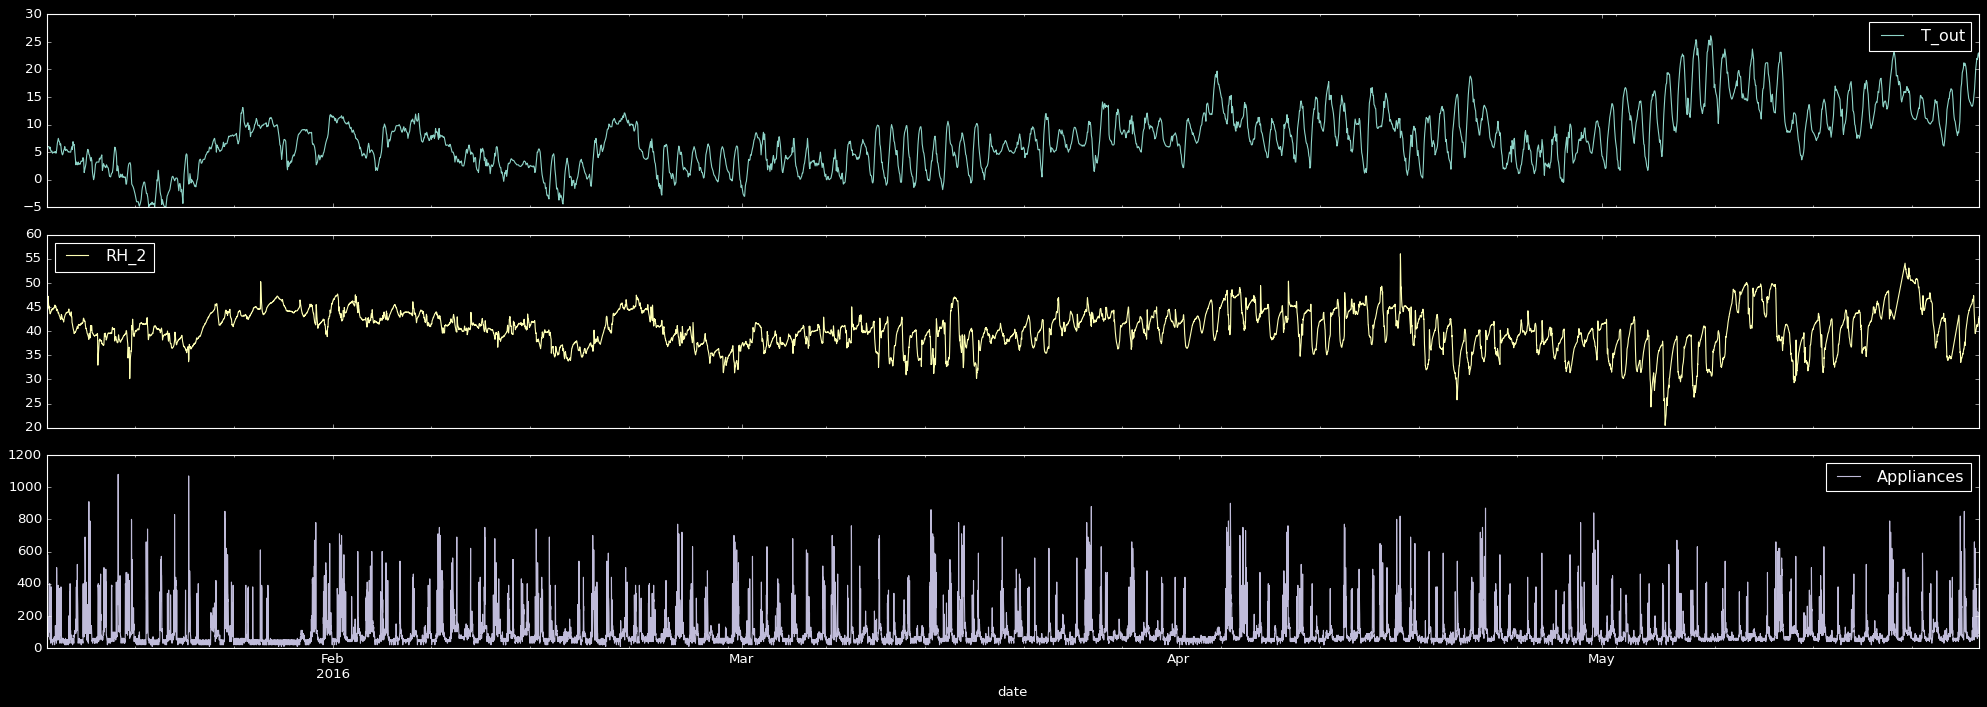

In [ ]:
myEnergy_df.plot( subplots= True, figsize= (25,9) ); plt.tight_layout()

#### Single Target (`y`)

<br>

In [ ]:
print( myEnergy_df.head(3) )

                        T_out       RH_2  Appliances
date                                                
2016-01-11 17:00:00  6.600000  44.790000        60.0
2016-01-11 17:10:00  6.483333  44.722500        60.0
2016-01-11 17:20:00  6.366667  44.626667        50.0


In [ ]:
# features and targets
xx = myEnergy_df[ ['Appliances','T_out','RH_2'] ].to_numpy()
yy = myEnergy_df[ 'Appliances' ].to_numpy()

print( xx[:5], '\n\n',
       yy[:5]  )
xx.shape, yy.shape

[[60.          6.6        44.79      ]
 [60.          6.48333333 44.7225    ]
 [50.          6.36666667 44.62666667]
 [50.          6.25       44.59      ]
 [60.          6.13333333 44.53      ]] 

 [60. 60. 50. 50. 60.]


((19735, 3), (19735,))

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

window_sz = 6
tmser_data_genr = TimeseriesGenerator( data= xx, targets= yy, length= window_sz, sampling_rate= 1, batch_size= 1, stride= 1 )

<br>

### `tf.keras.preprocessing.sequence.TimeseriesGenerator( ... ) ` output
<img src= 'images/NN time series input.jpg' style= 'width:3302;height:992;'>
<br>

In [ ]:
xx[:7]

array([[60.        ,  6.6       , 44.79      ],
       [60.        ,  6.48333333, 44.7225    ],
       [50.        ,  6.36666667, 44.62666667],
       [50.        ,  6.25      , 44.59      ],
       [60.        ,  6.13333333, 44.53      ],
       [50.        ,  6.01666667, 44.5       ],
       [60.        ,  5.9       , 44.5       ]])

In [ ]:
tmser_data_genr = TimeseriesGenerator( data= xx, targets= yy, length= window_sz, sampling_rate= 1, batch_size= 1, stride= 1 )

(
print(tmser_data_genr[0] ),
len( tmser_data_genr ),
len( tmser_data_genr[0] ),
tmser_data_genr[0][0].shape,
tmser_data_genr[0][1].shape
)

'''Compare this to the xx[:7] above'''

(array([[[60.        ,  6.6       , 44.79      ],
        [60.        ,  6.48333333, 44.7225    ],
        [50.        ,  6.36666667, 44.62666667],
        [50.        ,  6.25      , 44.59      ],
        [60.        ,  6.13333333, 44.53      ],
        [50.        ,  6.01666667, 44.5       ]]]), array([60.]))


'Compare this to the xx[:7] above'

<br>**`sampling rate`** : Period between successive individual timesteps within sequences. For rate `r`, `timesteps data[i]`, `data[i-r]`, ... `data[i - length]` are used for create a sample sequence.


In [ ]:
tmser_data_genr2 = TimeseriesGenerator( data= xx, targets= yy, length= window_sz, sampling_rate= 2, batch_size= 1, stride= 1 )
(
print(tmser_data_genr2[0] ),
len( tmser_data_genr2 ),
len( tmser_data_genr2[0] ),
tmser_data_genr2[0][0].shape,
tmser_data_genr2[0][1].shape
)

(array([[[60.        ,  6.6       , 44.79      ],
        [50.        ,  6.36666667, 44.62666667],
        [60.        ,  6.13333333, 44.53      ]]]), array([60.]))


(None, 19729, 2, (1, 3, 3), (1,))

<br>**`stride s`**: consecutive output samples would be centered around `data[i]`, `data[i+s]`, `data[i+2*s]`.

In [ ]:
tmser_data_genr2 = TimeseriesGenerator( data= xx, targets= yy, length= window_sz, sampling_rate= 1, batch_size= 1, stride= 2 )
(
print(tmser_data_genr2[0] ),
len( tmser_data_genr2 ),
len( tmser_data_genr2[0] ),
tmser_data_genr2[0][0].shape,
tmser_data_genr2[0][1].shape
)

(array([[[60.        ,  6.6       , 44.79      ],
        [60.        ,  6.48333333, 44.7225    ],
        [50.        ,  6.36666667, 44.62666667],
        [50.        ,  6.25      , 44.59      ],
        [60.        ,  6.13333333, 44.53      ],
        [50.        ,  6.01666667, 44.5       ]]]), array([60.]))


(None, 9865, 2, (1, 6, 3), (1,))

In [ ]:
del( tmser_data_genr2 )

#### Multiple Target:  ( yt1, yt2, ...yts )
                Predicting same variable for multiple timestep together ( yt1, yt2, ...yts )
<br>

In [ ]:
# we need to shift the y (appliances electric consumption)

yts_shift = pd.concat(   [ myEnergy_df.Appliances, myEnergy_df.Appliances.shift(-1), myEnergy_df.Appliances.shift(-2) ],
                         axis= 'columns'   ).dropna()
yts_shift.columns= [ 'yt', 'yt_1', 'yt_2' ]
print( yts_shift.head(3), yts_shift.shape, '\n\n' )

yts_shift = yts_shift.to_numpy()
print( yts_shift, yts_shift.shape )

                       yt  yt_1  yt_2
date                                 
2016-01-11 17:00:00  60.0  60.0  50.0
2016-01-11 17:10:00  60.0  50.0  50.0
2016-01-11 17:20:00  50.0  50.0  60.0 (19733, 3) 


[[ 60.  60.  50.]
 [ 60.  50.  50.]
 [ 50.  50.  60.]
 ...
 [100.  90. 270.]
 [ 90. 270. 420.]
 [270. 420. 430.]] (19733, 3)


In [ ]:
## truncating tail of the features to match the nascent target (yts_shift)
xx = myEnergy_df[ ['Appliances','T_out','RH_2']  ][ :yts_shift.shape[0] ]\
        .to_numpy()
print( xx, xx.shape )

[[ 60.           6.6         44.79      ]
 [ 60.           6.48333333  44.7225    ]
 [ 50.           6.36666667  44.62666667]
 ...
 [100.          22.73333333  42.02571429]
 [ 90.          22.6         42.08      ]
 [270.          22.46666667  42.76857143]] (19733, 3)


In [ ]:
tmser_data_genr = TimeseriesGenerator(  data= xx, targets= yts_shift, length= window_sz, sampling_rate= 1, batch_size= 1, stride= 1  )

(
        print(tmser_data_genr[0] ),
        len( tmser_data_genr ),
        len( tmser_data_genr[0] ),
        tmser_data_genr[0][0].shape,
        tmser_data_genr[0][1].shape
)

(array([[[60.        ,  6.6       , 44.79      ],
        [60.        ,  6.48333333, 44.7225    ],
        [50.        ,  6.36666667, 44.62666667],
        [50.        ,  6.25      , 44.59      ],
        [60.        ,  6.13333333, 44.53      ],
        [50.        ,  6.01666667, 44.5       ]]]), array([[60., 60., 60.]]))


(None, 19727, 2, (1, 6, 3), (1, 3))

### Developing RNN for single target

#### Basic EDA

                     Appliances     T_out       RH_1  Visibility
date                                                            
2016-01-11 17:00:00          60  6.600000  47.596667   63.000000
2016-01-11 17:10:00          60  6.483333  46.693333   59.166667
2016-01-11 17:20:00          50  6.366667  46.300000   55.333333 (19735, 4)


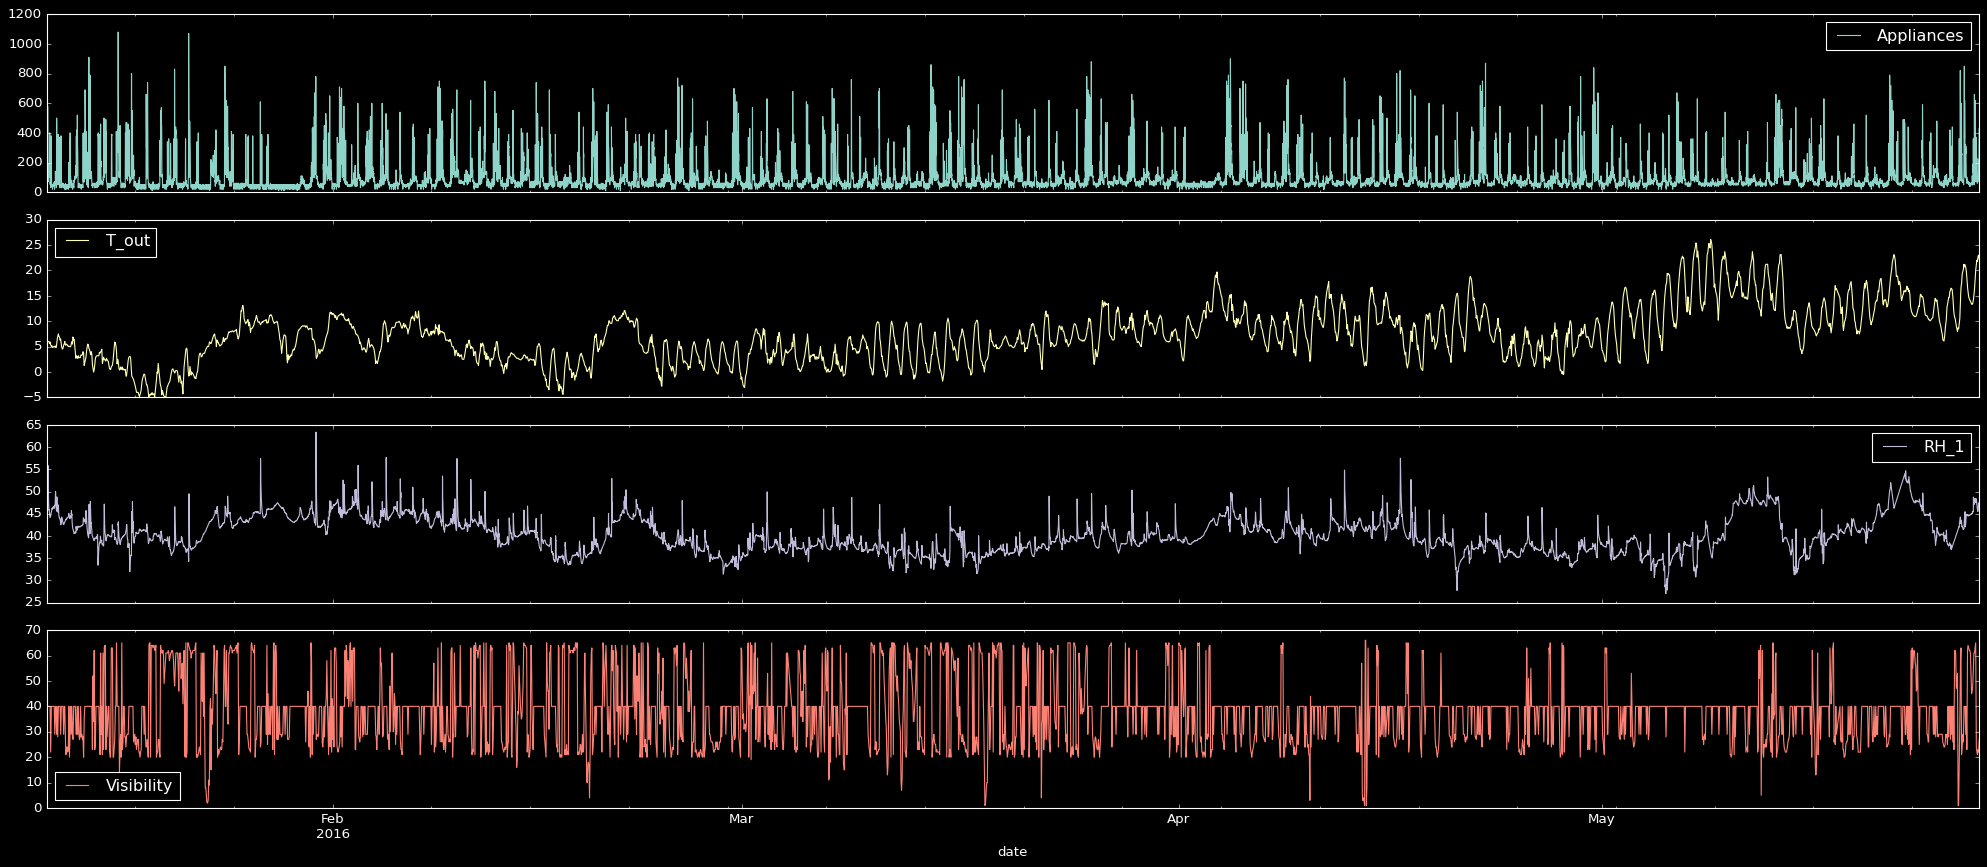

In [ ]:
energy_df = pd.read_csv( 'datasets/energydata_complete.csv', parse_dates= ['date'], index_col= ['date'] )

myEnergy_df = energy_df[ ['Appliances','T_out','RH_1','Visibility'] ]
print( myEnergy_df.head(3), myEnergy_df.shape )

myEnergy_df.plot( figsize= (25,11), subplots= True ); plt.tight_layout()

In [ ]:
# making sure there is a continuous data with no null for every next 10 mins
myEnergy_df = myEnergy_df.rolling( window= '10T' ).mean()
print( myEnergy_df.head(4) )

                     Appliances     T_out       RH_1  Visibility
date                                                            
2016-01-11 17:00:00        60.0  6.600000  47.596667   63.000000
2016-01-11 17:10:00        60.0  6.483333  46.693333   59.166667
2016-01-11 17:20:00        50.0  6.366667  46.300000   55.333333
2016-01-11 17:30:00        50.0  6.250000  46.066667   51.500000


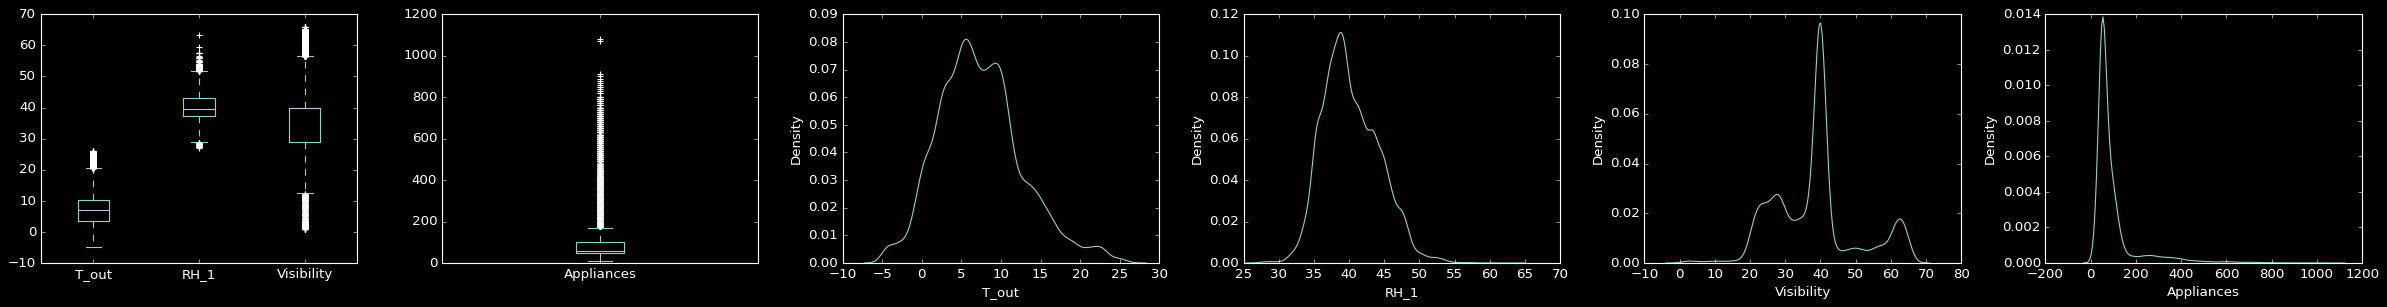

In [ ]:
fg,ax = plt.subplots( 1,6, figsize = (30,4) )

myEnergy_df[ ['T_out', 'RH_1', 'Visibility'] ].plot( kind= 'box', ax= ax[0] )
myEnergy_df[ ['Appliances'] ].plot( kind= 'box', ax= ax[1] )

sns.kdeplot( x= 'T_out', data= myEnergy_df, ax= ax[2] )
sns.kdeplot( x= 'RH_1', data= myEnergy_df, ax= ax[3] )
sns.kdeplot( x= 'Visibility', data= myEnergy_df, ax= ax[4] )
sns.kdeplot( x= 'Appliances', data= myEnergy_df, ax= ax[5] )

plt.tight_layout()

#### Basic Data preprocessing

In [ ]:
## Standarizing due to extreme values which helps NN to calcualte faster
## (however, standarizing should always be done after train-test split, google it)

scaler_obj = sklearn.preprocessing.MinMaxScaler( feature_range= (0,1) )

myEnergy_Scaled_np = scaler_obj.fit_transform( myEnergy_df )

myEnergy_Scaled_df = pd.DataFrame( myEnergy_Scaled_np, columns= myEnergy_df.columns )

print( myEnergy_Scaled_np, myEnergy_Scaled_np.shape )

[[0.04672897 0.37299035 0.56618659 0.95384615]
 [0.04672897 0.36923901 0.54132648 0.89487179]
 [0.03738318 0.36548767 0.53050179 0.83589744]
 ...
 [0.24299065 0.88317256 0.53866618 0.37435897]
 [0.38317757 0.87888532 0.54949087 0.38717949]
 [0.39252336 0.87459807 0.53875791 0.4       ]] (19735, 4)


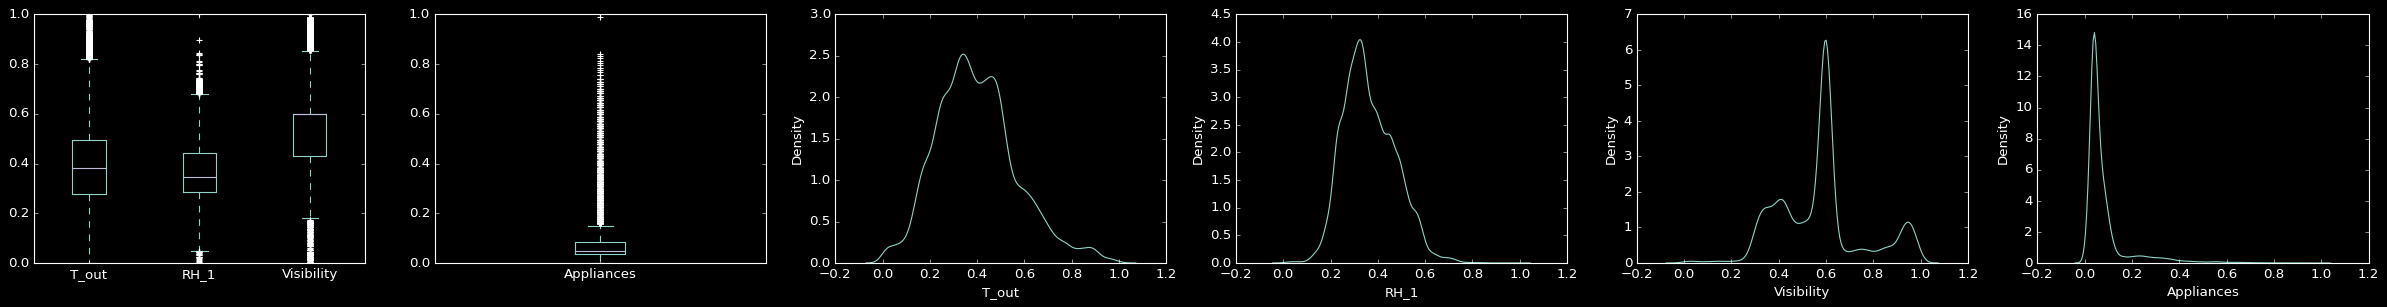

In [ ]:
fg,ax = plt.subplots( 1,6, figsize = (30,4) )
myEnergy_Scaled_df[ ['T_out', 'RH_1', 'Visibility'] ].plot( kind= 'box', ax= ax[0] )
myEnergy_Scaled_df[ ['Appliances'] ].plot( kind= 'box', ax= ax[1] )
sns.kdeplot( x= 'T_out', data= myEnergy_Scaled_df, ax= ax[2] )
sns.kdeplot( x= 'RH_1', data= myEnergy_Scaled_df, ax= ax[3] )
sns.kdeplot( x= 'Visibility', data= myEnergy_Scaled_df, ax= ax[4] )
sns.kdeplot( x= 'Appliances', data= myEnergy_Scaled_df, ax= ax[5] )
plt.tight_layout()

#### Data prep for NN

In [ ]:
# features & target
xx = myEnergy_Scaled_np;  yy = myEnergy_Scaled_np[:,0]
print( xx.shape, yy.shape )

xtrn, xtst, ytrn, ytst = sklearn.model_selection.train_test_split( xx, yy, test_size= 20/100, random_state= 123, shuffle= False )  # <-- shuffle should be FALSE; vimp

print( xtrn.shape, ytrn.shape, xtst.shape, ytst.shape )

(19735, 4) (19735,)
(15788, 4) (15788,) (3947, 4) (3947,)


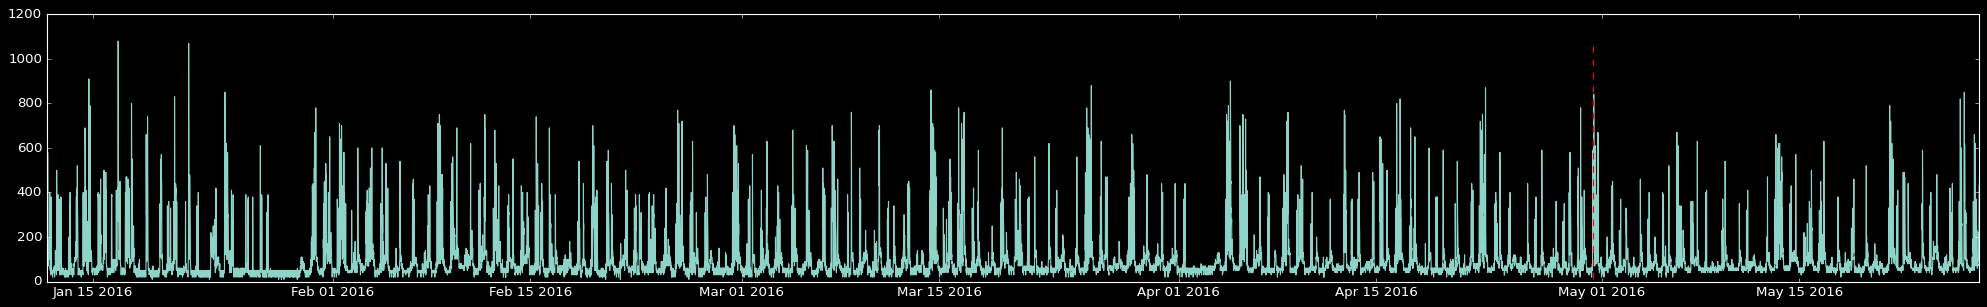

In [ ]:
fg, ax = plt.subplots( figsize= (25,4) )
col_to_plot = myEnergy_df.Appliances
ax.plot( col_to_plot )
ax.vlines( x= myEnergy_df.index[ xtrn.shape[0] ], ymin= min(col_to_plot), ymax= max(col_to_plot)+3, color= 'red', linestyles= '--'   )
plt.tight_layout()

In [ ]:
from keras.preprocessing.sequence import TimeseriesGenerator

win_sz = (6 * 24) * 5  # = 720 <-- the data exist for evry 10 mins; so 6 obs per hour, and we are considering 5 days of continous 10 mins data for next prediction
batch_sz = 32 * 6
num_feature = xx.shape[1]   # <-- 4
num_target = 1

trn_genr = TimeseriesGenerator(  data= xtrn, targets= ytrn, length= win_sz, sampling_rate= 1, stride= 1, batch_size= batch_sz  )
tst_genr = TimeseriesGenerator(  data= xtst, targets= ytst, length= win_sz, sampling_rate= 1, stride= 1, batch_size= batch_sz  )

In [2]:
## NN input sizes

print(
trn_genr[0][1],'\n',                    # this is y target
len( trn_genr ),  '\t|\t',              # --> kind of num observations......  = num observations if batch sie = 1
len( trn_genr[0]),   '\t|\t',           # --> x & y thus 2
trn_genr[0][0].shape,   '\t|\t',        # --> this is x shape
trn_genr[0][1].shape                    # --> this is y shape
)

print('-------------------------------------------------------------------------------------')

print(
tst_genr[0][1],'\n',
len( tst_genr ),  '\t|\t',
len( tst_genr[0] ),   '\t|\t',
tst_genr[0][0].shape,   '\t|\t',
tst_genr[0][1].shape
)

#### model arch

In [ ]:
from keras.layers import LSTM, LeakyReLU, ReLU, Dropout, Dense, Bidirectional, Conv1D, Lambda

In [ ]:
earlyStopMonitor_obj = keras.callbacks.EarlyStopping(
                            monitor= 'val_loss', min_delta= 1e-2,
                            patience= 25, mode= 'min', verbose= 1, restore_best_weights= True )

In [ ]:
## NN

from keras.layers import LSTM, LeakyReLU, ReLU, Dropout, Dense, Bidirectional, Conv1D

kseqModel = keras.Sequential()

kseqModel.add(   LSTM(  128, input_shape= (win_sz,num_feature), return_sequences= True  )   )
kseqModel.add(   LeakyReLU( alpha= 0.5  )   )

kseqModel.add(   LSTM(  128, return_sequences= True )   )
kseqModel.add(   LeakyReLU( alpha= 0.5  )   )
kseqModel.add(   Dropout( rate= 30/100  )   )

kseqModel.add(   LSTM(  64, return_sequences= False )   )
kseqModel.add(   Dropout(  rate= 30/100  )   )

kseqModel.add(   Dense(  num_target  )   )             # num_target = 1

kseqModel.summary()

# callbacks
earlyStopMonitor_obj = keras.callbacks.EarlyStopping(   monitor= 'val_loss', min_delta= 1e-2,  patience= 25, mode= 'auto', verbose= 1   )

# compile
kseqModel.compile(   optimizer= tf.keras.optimizers.Adam( learning_rate= 1e-5 ), loss= 'mse', metrics= 'mae'   )

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 720, 128)          68096     
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 720, 128)          0         
                                                                 
 lstm_1 (LSTM)               (None, 720, 128)          131584    
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 720, 128)          0         
                                                                 
 dropout (Dropout)           (None, 720, 128)          0         
                                                                 
 lstm_2 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0

#### yhat

In [ ]:
yhat = kseqModel.predict( tst_genr )
print(  yhat.shape, '\t <---> \t', xtst.shape[0]-win_sz, '\n\n', yhat )

(3227, 1) 	 <---> 	 3227 

 [[0.07130421]
 [0.07141782]
 [0.07146168]
 ...
 [0.07880534]
 [0.07893716]
 [0.07926235]]


In [ ]:
## inverse transform

yhat_df = pd.concat(   [  pd.DataFrame( yhat ), pd.DataFrame( xtst[ win_sz:, 1: ] )  ], axis= 'columns'   )

yhat_df = pd.DataFrame(  scaler_obj.inverse_transform( yhat_df ),  columns= myEnergy_df.columns  )
yhat_df = yhat_df.loc[ :, ['Appliances'] ]
yhat_df.shape, yhat_df.head()

((3227, 1),
    Appliances
 0   86.295504
 1   86.417063
 2   86.463995
 3   86.595089
 4   86.761586)

                        yi       yhat
date                                 
2016-05-05 08:20:00   90.0  86.295504
2016-05-05 08:30:00  120.0  86.417063
2016-05-05 08:40:00  390.0  86.463995
2016-05-05 08:50:00  240.0  86.595089
2016-05-05 09:00:00  120.0  86.761586 (3227, 2)


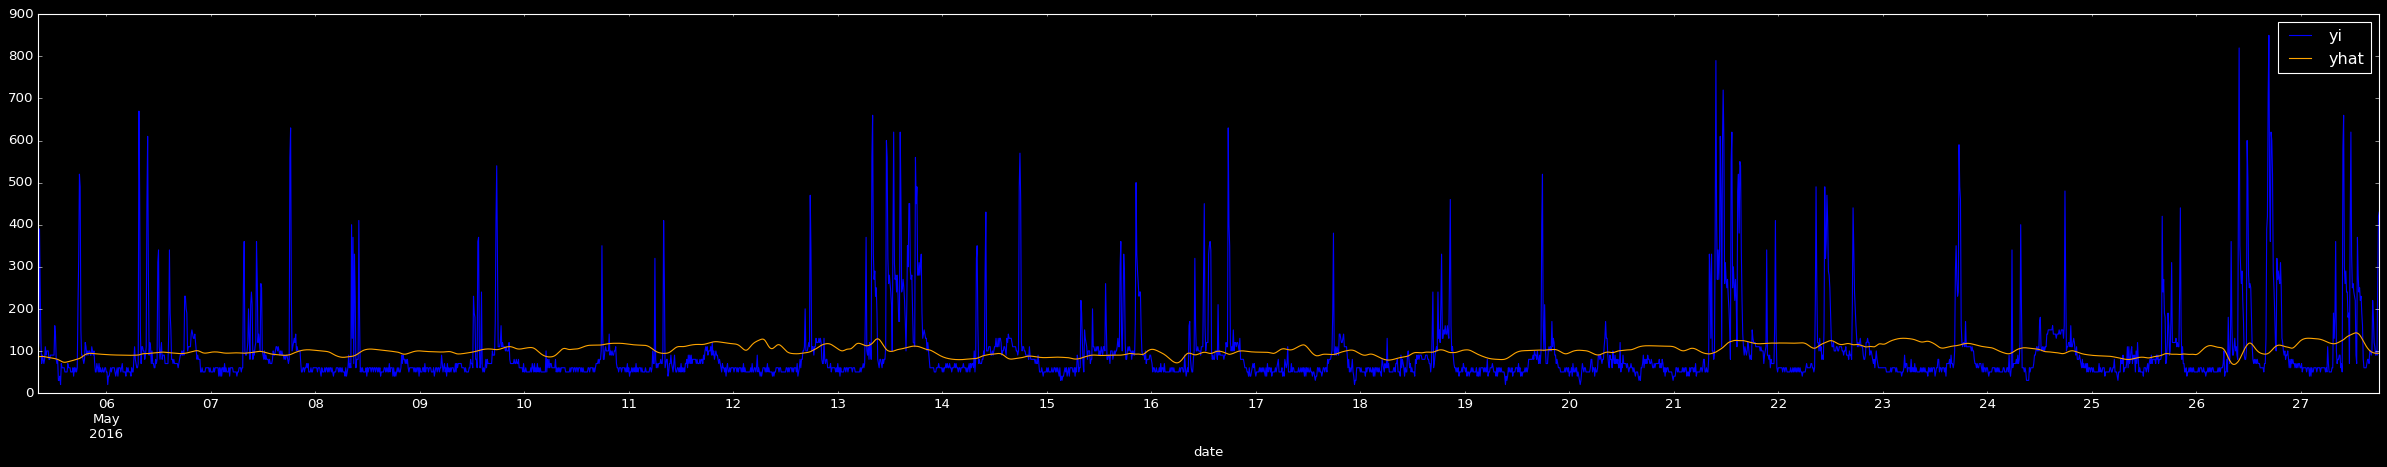

In [ ]:
# merging yi & yhat after careful order mgmt

# only gettting the test dataset
yi = myEnergy_df.iloc[ -len(yhat_df):, [myEnergy_df.columns.get_loc( 'Appliances' )] ]. reset_index(  )
yhat_yi = pd.concat(  [ yi, yhat_df], axis= 'columns' )
yhat_yi.set_index( 'date', drop= True, inplace= True )
yhat_yi.columns = [ 'yi', 'yhat' ]
print( yhat_yi.head(), yhat_yi.shape )
yhat_yi.plot( figsize= (30,6), color= ['blue','orange'] ); plt.tight_layout()

### Developing RNN for multiple timestep target

In [ ]:
# we need to shift the y (appliances electric consumption)

yts_shift = pd.concat(   [ myEnergy_df.Appliances, myEnergy_df.Appliances.shift(-1), myEnergy_df.Appliances.shift(-2) ], axis= 'columns'   ).dropna()
yts_shift.columns= [ 'yt', 'yt_1', 'yt_2' ]
print( yts_shift.head(3), yts_shift.shape, '\n\n' )

yts_shift = yts_shift.to_numpy()
print( yts_shift, yts_shift.shape )

                       yt  yt_1  yt_2
date                                 
2016-01-11 17:00:00  60.0  60.0  50.0
2016-01-11 17:10:00  60.0  50.0  50.0
2016-01-11 17:20:00  50.0  50.0  60.0 (19733, 3) 


[[ 60.  60.  50.]
 [ 60.  50.  50.]
 [ 50.  50.  60.]
 ...
 [100.  90. 270.]
 [ 90. 270. 420.]
 [270. 420. 430.]] (19733, 3)


In [3]:
## truncating tail of the features to match the nascent target (yts_shift)

xx = myEnergy_df[ ['Appliances','T_out','RH_1', 'Visibility']  ][ :yts_shift.shape[0] ] \
                                                                        .to_numpy()

In [ ]:
## Standarizing due to extreme values which helps NN to calcualte faster
##(however, standarizing should always be done after train-test split)

scaler_obj = sklearn.preprocessing.MinMaxScaler( feature_range= (0,1) )
myEnergy_Scaled_np = scaler_obj.fit_transform( xx )
myEnergy_Scaled_df = pd.DataFrame( myEnergy_Scaled_np, columns= myEnergy_df.columns )

print( myEnergy_Scaled_np, myEnergy_Scaled_np.shape )

[[0.04672897 0.37299035 0.56618659 0.95384615]
 [0.04672897 0.36923901 0.54132648 0.89487179]
 [0.03738318 0.36548767 0.53050179 0.83589744]
 ...
 [0.08411215 0.89174705 0.5376571  0.34871795]
 [0.07476636 0.88745981 0.53600587 0.36153846]
 [0.24299065 0.88317256 0.53866618 0.37435897]] (19733, 4)


In [ ]:
# features & target
xx = myEnergy_Scaled_np;  yy = yts_shift
print( xx.shape, yy.shape )

xtrn, xtst, ytrn, ytst = sklearn.model_selection.train_test_split(
    xx, yy, test_size= 20/100, random_state= 123, shuffle= False )  # <-- shuffle should be FALSE; vimp for timeseries

print( xtrn.shape, ytrn.shape, xtst.shape, ytst.shape )

(19733, 4) (19733, 3)
(15786, 4) (15786, 3) (3947, 4) (3947, 3)


In [ ]:
win_sz = (6 * 24) * 5  # = 720 <-- the data exist for evry 10 mins; so 6 obs per hour, and we are considering 5 days of continous 10 mins data for next prediction
batch_sz = 32*7
num_feature = xx.shape[1]   # <-- 4

trn_genr = TimeseriesGenerator(  data= xtrn, targets= ytrn, length= win_sz, sampling_rate= 1, stride= 1, batch_size= batch_sz  )
tst_genr = TimeseriesGenerator(  data= xtst, targets= ytst, length= win_sz, sampling_rate= 1, stride= 1, batch_size= batch_sz  )

len(trn_genr), len(tst_genr)

(68, 15)

In [ ]:
from keras.layers import LSTM, Dropout, LeakyReLU, Dense
earlyStopMonitor_obj = keras.callbacks.EarlyStopping( monitor= 'val_loss', min_delta= 1e-2, patience= 25, mode= 'min', verbose= 1, restore_best_weights= True )

## NN
kseqModel = keras.Sequential()

kseqModel.add(  LSTM( 128, input_shape= (win_sz, num_feature), return_sequences= True )  )
kseqModel.add(  LeakyReLU( alpha= 0.5 )  )

kseqModel.add(  LSTM( 128, return_sequences= True )  )
kseqModel.add(  LeakyReLU( alpha= 0.5 )  )
kseqModel.add(  Dropout( rate= 30/100 )  )

kseqModel.add(  LSTM( 64, return_sequences= False )  )
kseqModel.add(  Dropout( rate= 30/100 )  )

kseqModel.add(  Dense( 1 )  )

kseqModel.summary()

# callbacks
earlyStopMonitor_obj = keras.callbacks.EarlyStopping(  monitor= 'val_loss', min_delta= 1e-2,
                                                       patience= 25, mode= 'auto', verbose= 1  )
# compile
kseqModel.compile(  optimizer= tf.keras.optimizers.Adam( learning_rate= 1e-5 ), loss= 'mse', metrics= 'mae'  )
# moel fit
kseqModel.fit(  trn_genr, validation_data= tst_genr, callbacks= [ earlyStopMonitor_obj ], epochs= 5, shuffle= False  )

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 720, 128)          68096     
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 720, 128)          0         
                                                                 
 lstm_4 (LSTM)               (None, 720, 128)          131584    
                                                                 
 leaky_re_lu_3 (LeakyReLU)   (None, 720, 128)          0         
                                                                 
 dropout_2 (Dropout)         (None, 720, 128)          0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)               

In [ ]:
yhat = kseqModel.predict( tst_genr )
print(  yhat.shape, '\t <---> \t', xtst.shape[0]-win_sz, '\n\n', yhat )

(3227, 1) 	 <---> 	 3227 

 [[4.0532856]
 [4.0534844]
 [4.0536942]
 ...
 [4.115381 ]
 [4.1133766]
 [4.111475 ]]


### Developing Neural Network LSTM, Bidirectional & Dense layer single target for Sunspots data using keras `TimeseriesGenerator()`

            idx  sunspot_num
date                        
1749-01-31    0         96.7
1749-02-28    1        104.3
1749-03-31    2        116.7 (3235, 2)


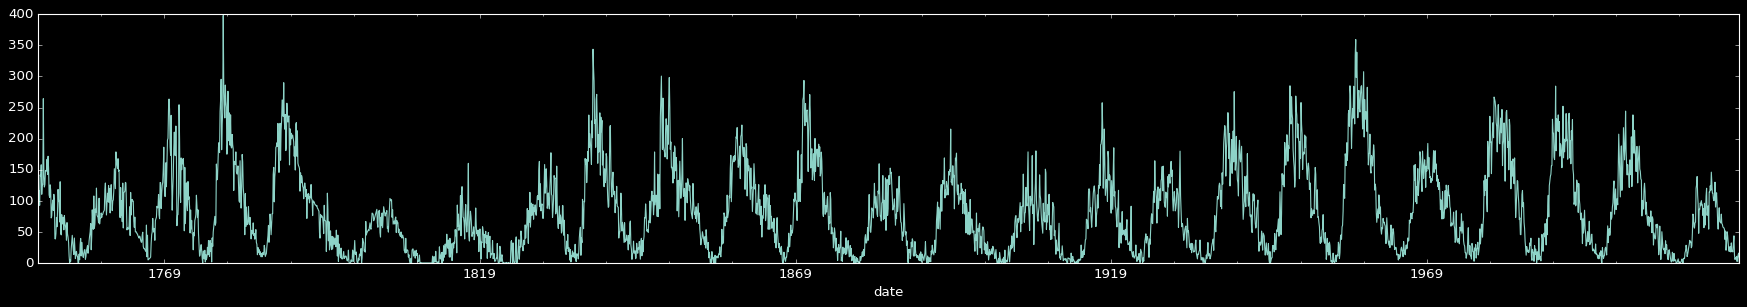

In [ ]:
sun_df =  pd.read_csv(  location + 'Sunspots.csv', names= [ 'idx', 'date','sunspot_num' ], skiprows= 1, index_col= 'date', parse_dates= ['date'] )
sun_df.sunspot_num.plot( figsize= (22,4) ); plt.tight_layout()
print(  sun_df.head(3), sun_df.shape  )

In [ ]:
sun_df = sun_df[['sunspot_num']].rolling( window= '30D' ).mean()

xx = sun_df.to_numpy() ;  yy = sun_df.to_numpy()
print( yy[:5], '\n\n', xx[:5] ) ; xx.shape, yy.shape

[[ 96.7]
 [100.5]
 [116.7]
 [ 92.8]
 [141.7]] 

 [[ 96.7]
 [100.5]
 [116.7]
 [ 92.8]
 [141.7]]


((3235, 1), (3235, 1))

(2588, 1) (2588, 1) (647, 1) (647, 1)


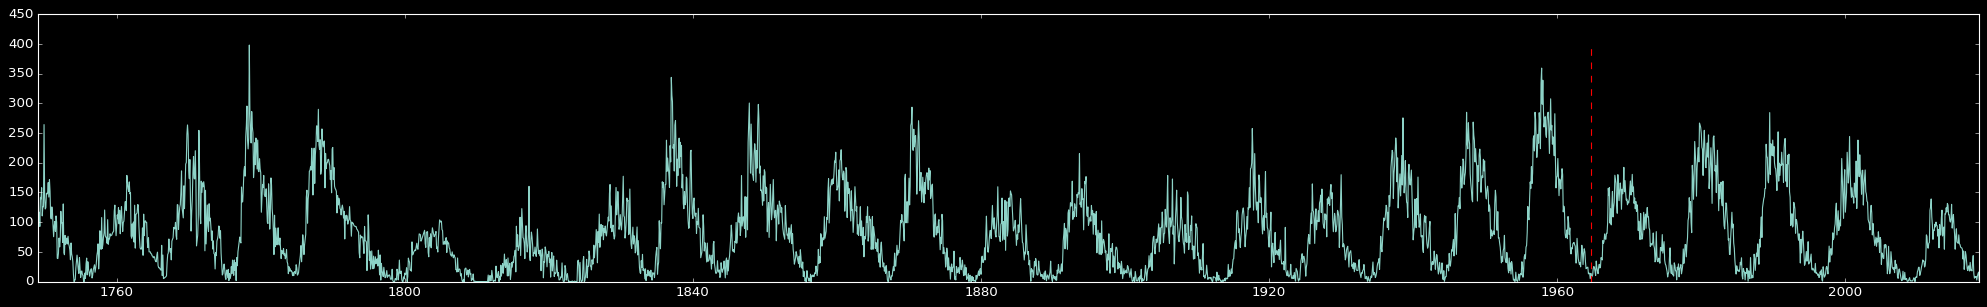

In [ ]:
xtrn, xtst, ytrn, ytst = sklearn.model_selection.train_test_split( xx, yy, test_size= 20/100, random_state= 123, shuffle= False )  # <-- shuffle should be FALSE; vimp
print( xtrn.shape, ytrn.shape, xtst.shape, ytst.shape )

fg, ax = plt.subplots( figsize= (25,4) )
ax.plot( sun_df )
ax.vlines( x= sun_df.index[ xtrn.shape[0] ], ymin= min(sun_df.sunspot_num), ymax= max(sun_df.sunspot_num)+3, color= 'red', linestyles= '--'   )
plt.tight_layout()

In [ ]:
# normalize data
scaler_obj = sklearn.preprocessing.MinMaxScaler( feature_range= (0,1) )

xtrn_norm = scaler_obj.fit_transform( xtrn );
xtst_norm = scaler_obj.fit_transform( xtst )

# xtrn_norm = xtrn;   xtst_norm = xtst

In [ ]:
## data prior to NN

win_sz = 24;  batch_sz = 240;   num_feature =  xx.shape[1]

trn_genr = TimeseriesGenerator(  data= xtrn_norm, targets= ytrn, length= win_sz, sampling_rate= 1, stride= 1, batch_size= batch_sz  )
tst_genr = TimeseriesGenerator(  data= xtst_norm, targets= ytst, length= win_sz, sampling_rate= 1, stride= 1, batch_size= batch_sz  )

In [ ]:
## NN input sizes

print(
# trn_genr[0][1],'\n',
len( trn_genr ),
len( trn_genr[0]),
trn_genr[0][0].shape,
trn_genr[0][1].shape     )

print('-------------------------------------------------------------------------------------')

print(
# tst_genr[0][1],'\n',
len( tst_genr ),
len( tst_genr[0] ),
tst_genr[0][0].shape,
tst_genr[0][1].shape     )

11 2 (240, 24, 1) (240, 1)
-------------------------------------------------------------------------------------
3 2 (240, 24, 1) (240, 1)


In [ ]:
from keras.layers import LSTM, LeakyReLU, ReLU, Dropout, Dense, Bidirectional, Conv1D, Lambda

In [ ]:
## NN model

keras.backend.clear_session()

kseq_model = keras.models.Sequential(
                    [
                        LSTM(   units= 128, input_shape= (win_sz,num_feature), return_sequences= True   ),
                        Dropout(   rate= 20/100   ),
                        LeakyReLU(   alpha= 0.5   ),

                        LSTM(   units= 64, return_sequences= True   ),
                        Dropout(   rate= 20/100   ),
                        LeakyReLU(   alpha= 0.5   ),

                        LSTM(   units= 32, return_sequences= True   ),
                        Dropout(   rate= 20/100   ),
                        LeakyReLU(   alpha= 0.5   ),

                        Bidirectional(   LSTM(  units= 32, return_sequences= True  )   ),
                        Dropout(   rate= 20/100   ),
                        LeakyReLU(   alpha= 0.5   ),

                        Bidirectional(   LSTM(  units= 32, return_sequences= True  )   ),
                        Dropout(   rate= 20/100   ),
                        LeakyReLU(   alpha= 0.5   ),

                        Bidirectional(   LSTM(  units= 32, return_sequences= False  )   ),
                        Dropout(   rate= 20/100   ),
                        LeakyReLU(   alpha= 0.5   ),

                        Dense(   units= 32, activation= 'relu'   ),
                        Dropout(   rate= 20/100   ),

                        Dense(   units= 32, activation= 'relu'   ),
                        Dropout(   rate= 20/100   ),

                        Dense(   units= 16, activation= 'relu'   ),
                        Dropout(   rate= 20/100   ),

                        Dense(   units=  8, activation= 'relu'   ),
                        Dropout(   rate= 20/100  ),

                        Dense(   units=  8, activation= 'relu'   ),
                        Dropout(   rate= 20/100   ),

                        Dense(   units=  1, activation= 'relu'   ),

                        Lambda(   lambda x: 100*x   )
                    ]
             )

earlyStopMonitor_obj = keras.callbacks.EarlyStopping( monitor= 'val_loss', min_delta= 1e-1, patience= 35, mode= 'auto', restore_best_weights= True, verbose= 1  )

kseq_model.compile(  optimizer= tf.keras.optimizers.Adam( learning_rate= 1e-5 ), loss= keras.losses.Huber(), metrics= ['mae','accuracy']  )

kseq_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 24, 128)           66560     
                                                                 
 dropout (Dropout)           (None, 24, 128)           0         
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 24, 128)           0         
                                                                 
 lstm_1 (LSTM)               (None, 24, 64)            49408     
                                                                 
 dropout_1 (Dropout)         (None, 24, 64)            0         
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 24, 64)            0         
                                                                 
 lstm_2 (LSTM)               (None, 24, 32)            1

In [1]:
kseq_modelFit = kseq_model.fit(  trn_genr, validation_data= tst_genr,
                                 callbacks= earlyStopMonitor_obj, epochs= 1000,
                                 verbose= 1, shuffle= False  )

(623, 1)


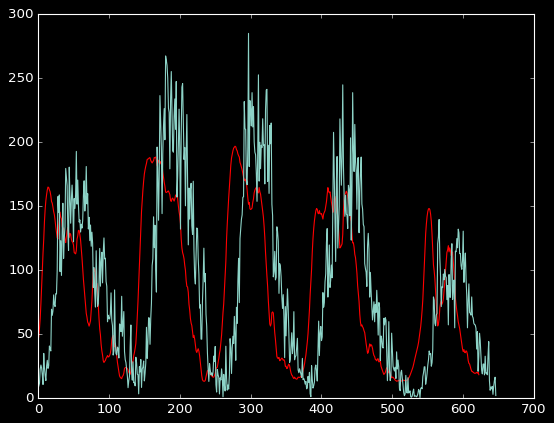

In [ ]:
yhat = kseq_model.predict( tst_genr )
print( yhat.shape )
plt.plot( yhat, color= 'red' ); plt.plot( ytst );

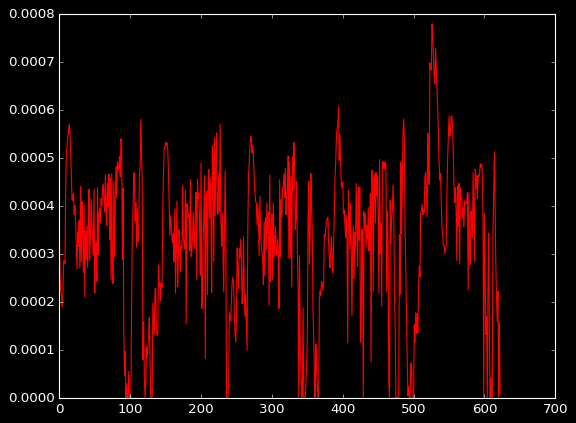

In [ ]:
plt.plot( yhat, color= 'red' )

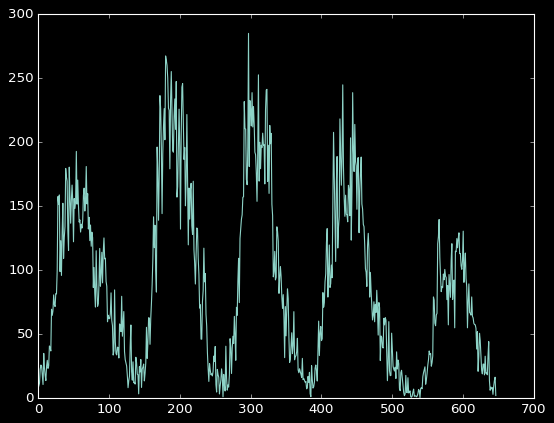

In [ ]:
plt.plot( ytst );

<br>

### Linear Regression using SINGLE layer neural network

#### Manual Data prep using Tensorflow API

<br>

In [ ]:
import tensorflow as tf
from tensorflow import keras

gpus = tf.config.experimental.list_physical_devices( device_type= 'GPU' )

tf.config.experimental.set_virtual_device_configuration(
        device= gpus[0],
        logical_devices= [ tf.config.experimental.VirtualDeviceConfiguration(memory_limit= 1024) ]  )

In [4]:
dataset = tf.data.Dataset.range( 20 )

In [ ]:
# window the data intho chunks of size = 5
window = dataset.window( size= 5, shift= 1, drop_remainder= False )

for e_window in window:
    for e_val in e_window:
        print( e_val.numpy(), ',', end= '  ' )
    print()

0 ,  1 ,  2 ,  3 ,  4 ,  
1 ,  2 ,  3 ,  4 ,  5 ,  
2 ,  3 ,  4 ,  5 ,  6 ,  
3 ,  4 ,  5 ,  6 ,  7 ,  
4 ,  5 ,  6 ,  7 ,  8 ,  
5 ,  6 ,  7 ,  8 ,  9 ,  
6 ,  7 ,  8 ,  9 ,  10 ,  
7 ,  8 ,  9 ,  10 ,  11 ,  
8 ,  9 ,  10 ,  11 ,  12 ,  
9 ,  10 ,  11 ,  12 ,  13 ,  
10 ,  11 ,  12 ,  13 ,  14 ,  
11 ,  12 ,  13 ,  14 ,  15 ,  
12 ,  13 ,  14 ,  15 ,  16 ,  
13 ,  14 ,  15 ,  16 ,  17 ,  
14 ,  15 ,  16 ,  17 ,  18 ,  
15 ,  16 ,  17 ,  18 ,  19 ,  
16 ,  17 ,  18 ,  19 ,  
17 ,  18 ,  19 ,  
18 ,  19 ,  
19 ,  


In [ ]:
window = dataset.window( size= 5, shift= 1, drop_remainder= True )

for e_window in window:
    for e_val in e_window:
        print( e_val.numpy(), ',', end= '  ' )
    print()

0 ,  1 ,  2 ,  3 ,  4 ,  
1 ,  2 ,  3 ,  4 ,  5 ,  
2 ,  3 ,  4 ,  5 ,  6 ,  
3 ,  4 ,  5 ,  6 ,  7 ,  
4 ,  5 ,  6 ,  7 ,  8 ,  
5 ,  6 ,  7 ,  8 ,  9 ,  
6 ,  7 ,  8 ,  9 ,  10 ,  
7 ,  8 ,  9 ,  10 ,  11 ,  
8 ,  9 ,  10 ,  11 ,  12 ,  
9 ,  10 ,  11 ,  12 ,  13 ,  
10 ,  11 ,  12 ,  13 ,  14 ,  
11 ,  12 ,  13 ,  14 ,  15 ,  
12 ,  13 ,  14 ,  15 ,  16 ,  
13 ,  14 ,  15 ,  16 ,  17 ,  
14 ,  15 ,  16 ,  17 ,  18 ,  
15 ,  16 ,  17 ,  18 ,  19 ,  


In [ ]:
# flatten the data
flat = window.flat_map( lambda e_window: e_window.batch( 6 ) )

for e_window in flat:
    print( e_window.numpy() )

[0 1 2 3 4]
[1 2 3 4 5]
[2 3 4 5 6]
[3 4 5 6 7]
[4 5 6 7 8]
[5 6 7 8 9]
[ 6  7  8  9 10]
[ 7  8  9 10 11]
[ 8  9 10 11 12]
[ 9 10 11 12 13]
[10 11 12 13 14]
[11 12 13 14 15]
[12 13 14 15 16]
[13 14 15 16 17]
[14 15 16 17 18]
[15 16 17 18 19]


##### separating feature and label

In [ ]:
# separate features and lable
feature_lbl = flat.map(  map_func= lambda e_window: ( e_window[:-1], e_window[-1] )  )

# suffle the data for randomness
feature_lbl_suffle = feature_lbl.shuffle( buffer_size= 10 )
for e_feature, e_lbl in feature_lbl_suffle:
    print( e_feature.numpy(), e_lbl.numpy() )

[1 2 3 4] 5
[4 5 6 7] 8
[10 11 12 13] 14
[ 7  8  9 10] 11
[ 9 10 11 12] 13
[14 15 16 17] 18
[13 14 15 16] 17
[15 16 17 18] 19
[ 8  9 10 11] 12
[11 12 13 14] 15
[12 13 14 15] 16
[0 1 2 3] 4
[3 4 5 6] 7
[6 7 8 9] 10
[2 3 4 5] 6
[5 6 7 8] 9


In [ ]:
# batching the data for train, validation & test set

feature_lbl_batch = feature_lbl_suffle.batch( batch_size= 6 ).prefetch(1)

for e_feature, e_lbl in feature_lbl_batch:
    print( 'feature =\n', e_feature.numpy() )
    print( 'label = ', e_lbl.numpy() )
    print()

feature =
 [[ 4  5  6  7]
 [ 9 10 11 12]
 [ 2  3  4  5]
 [ 8  9 10 11]
 [12 13 14 15]
 [ 1  2  3  4]]
label =  [ 8 13  6 12 16  5]

feature =
 [[ 6  7  8  9]
 [ 5  6  7  8]
 [14 15 16 17]
 [ 3  4  5  6]
 [10 11 12 13]
 [ 7  8  9 10]]
label =  [10  9 18  7 14 11]

feature =
 [[11 12 13 14]
 [13 14 15 16]
 [ 0  1  2  3]
 [15 16 17 18]]
label =  [15 17  4 19]



In [ ]:
# creating a udf for creating a windowed datasetet

def genr_windowed_data( Y_timeSeries, window_size= 5, batch_size= 2, shuffle_buffer= 10 ):

    data_windowed = tf.data.Dataset.from_tensor_slices( tensors= Y_timeSeries ) \
                                         .window( size= window_size+1, shift= 1, drop_remainder= True ) \
                                         .flat_map( lambda e_window: e_window.batch(window_size+1) ) \
                                         .shuffle( shuffle_buffer ) \
                                         .map( lambda e_window: ( e_window[:-1], e_window[-1] ) ) \
                                         .batch( batch_size ).prefetch(1)
    return( data_windowed )

##### simulate a timeSeries data


(1461,) (1461,)
(1000,) (1000,) (461,) (461,)


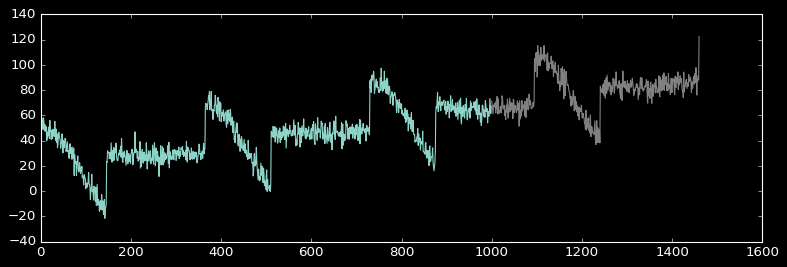

In [ ]:
## constants for data creation

baseline = 10 ;     slope_val = 0.05
amp_val = 40 ;      noise_lvl = 5
period_val = 365

tm1 = np.arange( stop= 4*365+1, dtype= np.float16 )

## y time series with:   Trend  +  Seasonality  +  Noise

y_tmSer =  genr_trend( tm1, slope= slope_val, intercept= baseline ) \
                + genr_seasonality( tm1, period= period_val, amp= amp_val ) \
                + addNoise( tm1, noise_level= noise_lvl, seed= 42 )

print( tm1.shape, y_tmSer.shape )

## Train-Validation set split

split_line = 1000

xtrn =     tm1[ : split_line ]  ;         xval =     tm1[ split_line : ]
ytrn = y_tmSer[ : split_line ]  ;         yval = y_tmSer[ split_line : ]

print(  xtrn.shape, ytrn.shape, xval.shape, yval.shape )

## windowing the data

win_sz = 20;         batch_sz = 32;              shuffle_buff_sz = 1000

data_windowed     =  genr_windowed_data(  Y_timeSeries= ytrn, window_size= win_sz,
                            batch_size= batch_sz, shuffle_buffer= shuffle_buff_sz  )
dataVal_windowed  =  genr_windowed_data(  Y_timeSeries= yval, window_size= win_sz,
                            batch_size= batch_sz, shuffle_buffer= shuffle_buff_sz  )


fg, ax = plt.subplots( figsize= (10,3.5) )
ax.plot( xtrn, ytrn );    ax.plot( xval, yval, color= 'gray' )
plt.tight_layout()

In [2]:
# Linear regression using Neural n/w

from tensorflow import keras

lyr0 = keras.layers.Dense( units= 1, input_shape = [win_sz] )

kseqModel = keras.models.Sequential( [lyr0] )

kseqModel.compile( loss= 'mse', optimizer= keras.optimizers.SGD( learning_rate= 1e-6, momentum= 0.9 )  )

# callbacks
monitor_obj = keras.callbacks.EarlyStopping(  monitor= 'val_loss', min_delta= 1e-3, patience= 20, mode= 'min',
                                              verbose= 1, restore_best_weights= True  )

kseqModel_fit_obj = kseqModel.fit( data_windowed, validation_data= dataVal_windowed, epochs= 1000, callbacks= [ monitor_obj ], verbose= 1 )

In [ ]:
def plot_loss( model_fitting_obj, ylim= [0,100], figsz = (10,4.5) ):

    fg, ax = plt.subplots( figsize= figsz )

    # main plots
    ax.plot( model_fitting_obj.history['loss'] );            ax.plot( model_fitting_obj.history['val_loss'] )

    ax.set_xlabel('Epoch');  ax.set_ylabel('Loss %')

    # axes attributes
    ax.spines['bottom'].set_color('red'); ax.spines['top'].set_color('red')
    ax.xaxis.label.set_color('red'); ax.yaxis.label.set_color('red')
    ax.tick_params( axis= 'x', colors= 'red' ); ax.tick_params( axis= 'y', colors= 'red' )
    ax.set_title( 'Model Loss over Training and Validation dataset' , color ='blue' )
    ax.legend( ['Train dataset', 'Validation dataset'], loc= 'upper right' )

    # set y axis range
    ax.set_ylim( ylim )

    plt.show()

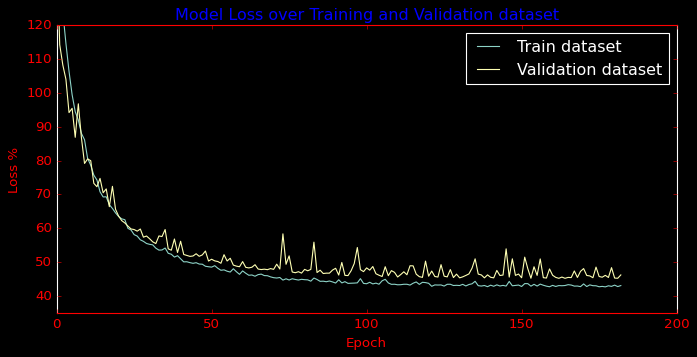

In [ ]:
plot_loss( kseqModel_fit_obj, ylim= [35,120] )

In [ ]:
print( 'Layer weights --> \n' )
[ print( np.round(e_elem,3), end= " " )  for e_elem in lyr0.get_weights()[0] ];
print( '\n\n',lyr0.get_weights()[1] )

Layer weights --> 

[-0.018] [-0.032] [0.053] [-0.033] [0.026] [0.019] [-0.018] [-0.003] [-0.008] [0.034] [0.004] [-0.022] [-0.029] [0.024] [0.046] [0.051] [0.005] [0.172] [0.267] [0.462] 

 [0.02204604]


In [ ]:
# model prediction
yhat = []
for e_tm in range( len(y_tmSer) - win_sz ):
    yhat.append(  kseqModel.predict( x= y_tmSer[e_tm:e_tm+win_sz][np.newaxis] )  )   # <-- np.newaxis for adjusting the input shp as accepted by the NN as shown above

<br>

<h3><p style= 'text-align:left;'>Handling data shape for Modeling and Predicting</p></h3>

<img src= 'images/TimeSeries-modelprediction_training1.jpg' style= 'width:600px;height:545px;'>
<br>


<!-- m, wd, ht = 2, 990, 576; ( wd/m, ht/m  ) -->

[64.7073   68.25821  69.80698  66.87302  63.937656 65.530235 65.87423
 68.00064  67.575714 67.405136] 

 (461,)

Mean Absolute Error -->   4.95


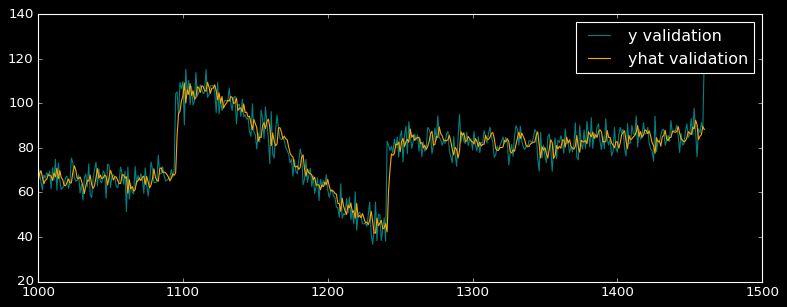

In [ ]:
yhat_validationSet = yhat[ split_line - win_sz  : ]
yhat_val_np = np.array( yhat_validationSet )[ :,0,0 ]
print( yhat_val_np[:10], '\n\n', yhat_val_np.shape )

## plots
fg, ax = plt.subplots( figsize= (10,4) )
ax.plot( xval, yval, color= 'teal', label= 'y validation' )
ax.plot( xval, yhat_val_np, color= 'orange', label= 'yhat validation' )
ax.legend()
plt.tight_layout()

print(  '\nMean Absolute Error -->  ', np.round( sklearn.metrics.mean_absolute_error(yval,yhat_val_np), 2 )  )

<br>

### Deep neural network training, tuning & prediction

##### data preprocessing
<br>

(1000,) (1000,) (461,) (461,)


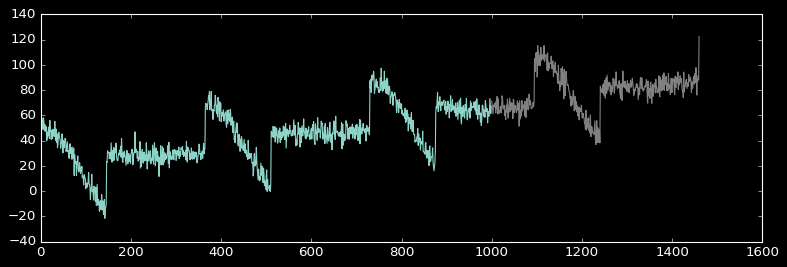

In [ ]:
print(  xtrn.shape, ytrn.shape, xval.shape, yval.shape )

## windowing the data
win_sz = 20;         batch_sz = 32;              shuffle_buff_sz = 1000
ytrn_win  =  genr_windowed_data(  Y_timeSeries= ytrn, window_size= win_sz,
                                  batch_size= batch_sz, shuffle_buffer= shuffle_buff_sz  )
yval_win  =  genr_windowed_data(  Y_timeSeries= yval, window_size= win_sz,
                                  batch_size= batch_sz, shuffle_buffer= shuffle_buff_sz  )

fg, ax = plt.subplots( figsize= (10,3.5) )
ax.plot( xtrn, ytrn );    ax.plot( xval, yval, color= 'gray' );
plt.tight_layout()

In [5]:
kseqModel = keras.models.Sequential(
                [    keras.layers.Dense(  10, input_shape= [win_sz], activation= 'relu'  ),
                     keras.layers.Dense(  10, activation= 'relu'  ),
                     keras.layers.Dense(  1  )
                ]   )

kseqModel.compile( optimizer= keras.optimizers.Adam( learning_rate= 1e-4 ), loss= 'mse' )
callback_monitor_obj = keras.callbacks.EarlyStopping(  monitor= 'val_loss', min_delta= 1e-3, patience= 25,
                                                       mode= 'min', verbose= 1, restore_best_weights= True  )
kseqModel_fit_obj = kseqModel.fit(  ytrn_win, validation_data=  yval_win, epochs= 1000,
                                    callbacks= [callback_monitor_obj], verbose= 1 )

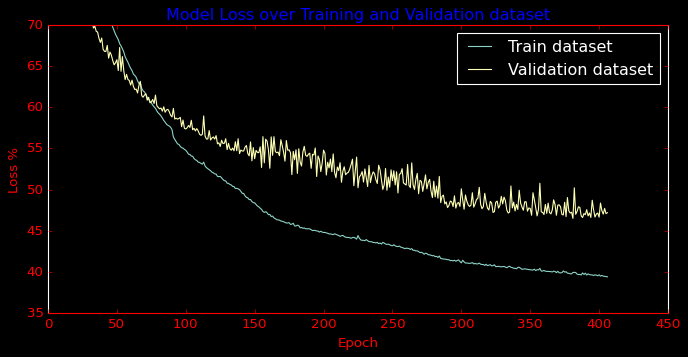

In [ ]:
fg, ax = plt.subplots( 1,2, figsize= (25,5.5) )
plot_loss(  model_fitting_obj= kseqModel_fit_obj, ylim= [4,20], ax= ax[0]  )
model_predict_plot(  split_line, y_tmSer, xval, yval, win_sz, model= kseqModel, ax= ax[1]  )
plt.tight_layout()

<br>

### Finding stable learning rate value

We find overall stable learning rate (α) values. Firstly, we observe the loss vs. learning rate and then choose a suitable learning rate at the stable valley, typically a range, not necessarily at the minimum or maximum loss.

Here we use `LearningRateScheduler` callbacks on in adjunct with existing `EarlyStopping` callback.

<br>

In [3]:
kseqModel = keras.models.Sequential(  [     keras.layers.Dense(  10, input_shape= [win_sz], activation= 'relu'  ),
                                            keras.layers.Dense(  10, activation= 'relu'  ),
                                            keras.layers.Dense(  1  )     ]
                                   )

lr_schedule_obj = keras.callbacks.LearningRateScheduler( schedule=  lambda e_epoch: 1e-8 * 10**(e_epoch/20) )
earlyStopMonitor_obj = keras.callbacks.EarlyStopping(  monitor= 'val_loss', min_delta= 1e-2, patience= 25, mode= 'min',
                                                       verbose= 1, restore_best_weights= True  )
kseqModel.compile(  optimizer= keras.optimizers.SGD( learning_rate= 1e-8, momentum= 0.9 ), loss= 'mse'  )
kseqModel_fit_obj = kseqModel.fit(  ytrn_win, validation_data= yval_win, , verbose= 1,
                                    epochs= 1000, callbacks = [ lr_schedule_obj, earlyStopMonitor_obj ] )

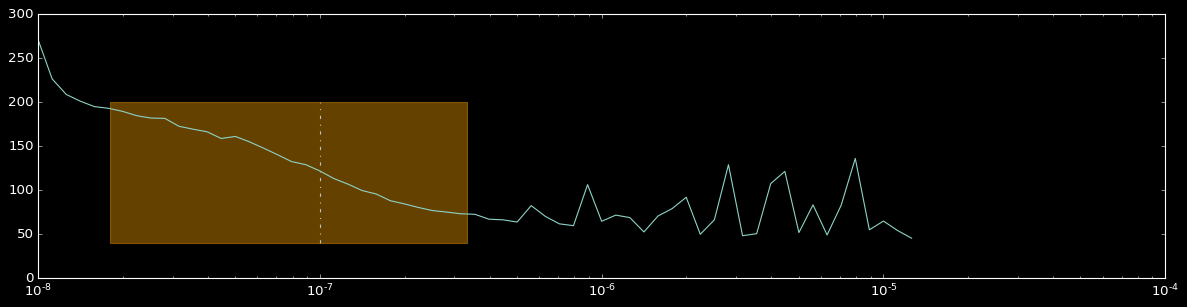

In [ ]:
initial_idx, end_idx = 10, 25

epoch_ls = np.arange(  len( kseqModel_fit_obj.history['val_loss'][ initial_idx:-end_idx ] )  )
learningRate_ls = 1e-8 * 10**(epoch_ls/20)

fg, ax = plt.subplots( figsize= (15,4) )
plt.semilogx( learningRate_ls, kseqModel_fit_obj.history['val_loss'][ initial_idx:-end_idx ] )
plt.fill_betweenx( y= [40,200], x1= (1e-8)*1.8, x2= 1e-6/3, alpha= 0.4, color= 'orange' )
plt.vlines( x= 1e-7, ymin= 40, ymax= 200, color= 'silver', linestyle= '-.' )
plt.tight_layout()

In [6]:
lr_stable = 1e-7

kseqModel = keras.models.Sequential(  [     keras.layers.Dense(  10, input_shape= [win_sz], activation= 'relu'  ),
                                            keras.layers.Dense(  10, activation= 'relu'  ),
                                            keras.layers.Dense(  1  )     ]
                                   )
earlyStopMonitor_obj = keras.callbacks.EarlyStopping(  monitor= 'val_loss', min_delta= 1e-2, patience= 25, mode= 'min',
                                                       verbose= 1, restore_best_weights= True  )
kseqModel.compile( optimizer= keras.optimizers.SGD( learning_rate= lr_stable, momentum= 0.9 ), loss= 'mse'  )

kseqModel_fit_obj = kseqModel.fit(  ytrn_win, validation_data= yval_win, epochs= 1000 , verbose= 1,
                                    callbacks = [ lr_schedule_obj, earlyStopMonitor_obj ]  )

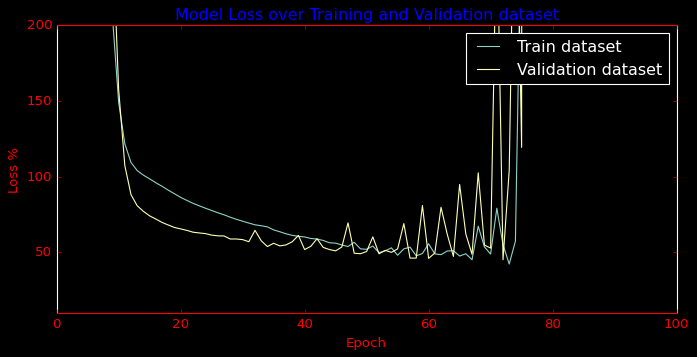

In [ ]:
plot_loss( kseqModel_fit_obj, ylim= [10,200] )

[61.614044 64.68816  65.699905 63.81746  63.581432 65.83771  65.15943
 64.0641   65.07774  66.74977 ] 

 (461,)

Mean Absolute Error -->   4.8


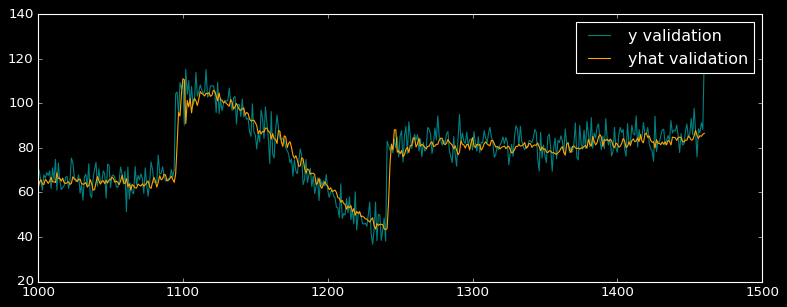

In [ ]:
# model prediction

yhat = []
for e_tm in range( len(y_tmSer) - win_sz ):
    yhat.append(  kseqModel.predict( x= y_tmSer[e_tm:e_tm+win_sz][np.newaxis] )  )   # <-- np.newaxis for adjusting the input shp as accepted by the NN as shown above
yhat_validationSet = yhat[ split_line - win_sz  : ]
yhat_val_np = np.array( yhat_validationSet )[ :,0,0 ]
print( yhat_val_np[:10], '\n\n', yhat_val_np.shape )

# plots
fg, ax = plt.subplots( figsize= (10,4) )
ax.plot( xval, yval, color= 'teal', label= 'y validation' )
ax.plot( xval, yhat_val_np, color= 'orange', label= 'yhat validation' )
ax.legend();          plt.tight_layout()
print(  '\nMean Absolute Error -->  ', np.round( sklearn.metrics.mean_absolute_error(yval,yhat_val_np), 2 )  )

<br> <br><hr> <br>

## Recurrent Neural Networks (RNN) for Time Series



Using Recurrent Neural networks (RNN) & Long Short Term Memory (LSTM) to classify & predict sequential time series data.
<br>

<h3><p style= 'text-align:center;'>Unfolding A Recurrent Neural Network</p></h3>
<img src= 'images/RNN-compressed-unfolded.png' style= 'width:2168;height:724;'>

<h3><p style= 'text-align:center;'>Types of RNNs: 1-1, 1-M, M-1, M-M</p></h3>
<img src= 'images/RNN-types.png' style= 'width:2168;height:724;'>


<br>

### how the layers from a SimpleRNN and Dense layer produce an output

<img src= 'images/RNN-op.png' style= 'width:2168;height:724;'>

We’ll input x for three time steps and let the network generate an output. The values of the hidden units at time steps 1, 2 and 3 will be computed. `ho` is initialized to the zero vector. The output `o3` is computed from `h3` & `wy` . An activation function is not required as we are using linear units

<br><br>


### Recurrent Neural Network

##### data

(1461,) (1461,)
(1000,) (1000,) (461,) (461,)


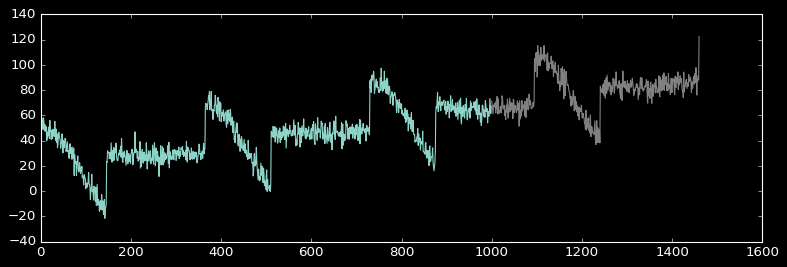

In [ ]:
## y time series with:   Trend  +  Seasonality  +  Noise
baseline = 10 ;     slope_val = 0.05  ;  amp_val = 40 ;     noise_lvl = 5  ;   period_val = 365

tm1 = np.arange( stop= 4*365+1, dtype= np.float16 )
y_tmSer =  genr_trend( tm1, slope= slope_val, intercept= baseline ) \
                + genr_seasonality( tm1, period= period_val, amp= amp_val ) \
                + addNoise( tm1, noise_level= noise_lvl, seed= 42 )
print( tm1.shape, y_tmSer.shape )

## Train-Validation set split
split_line = 1000
xtrn =     tm1[ : split_line ]  ;         xval =     tm1[ split_line : ]
ytrn = y_tmSer[ : split_line ]  ;         yval = y_tmSer[ split_line : ]
print(  xtrn.shape, ytrn.shape, xval.shape, yval.shape )

## windowing the data
win_sz = 20;         batch_sz = 32;              shuffle_buff_sz = 1000
ytrn_win  =  genr_windowed_data(  Y_timeSeries= ytrn, window_size= win_sz, batch_size= batch_sz, shuffle_buffer= shuffle_buff_sz  )
yval_win  =  genr_windowed_data(  Y_timeSeries= yval, window_size= win_sz, batch_size= batch_sz, shuffle_buffer= shuffle_buff_sz  )
# plot
fg, ax = plt.subplots( figsize= (10,3.5) )
ax.plot( xtrn, ytrn );    ax.plot( xval, yval, color= 'gray' );             plt.tight_layout()

##### RNN network

In [7]:
# keras sequence RNN model

kseqRNN_model = keras.models.Sequential(
                        [
                            keras.layers.Lambda(  lambda x: tf.expand_dims( x, axis= -1 )  ),     # <-- add dimension = 1 to the shape of the i/p

                            keras.layers.SimpleRNN(  units= 40, return_sequences= True   ),
                            keras.layers.SimpleRNN(  units= 40, return_sequences= False  ),
                            keras.layers.Dense(  units= 1  ),

                            keras.layers.Lambda(  lambda x: 100.0 * x  )   ]
                )

earlyStopMonitor_obj = keras.callbacks.EarlyStopping( monitor= 'val_loss', min_delta= 1e-2, patience= 25,
                                                      mode= 'min', verbose= 1, restore_best_weights= True )

kseqRNN_model.compile(  optimizer= keras.optimizers.SGD( learning_rate= 5e-5, momentum= 0.90 ),
                        loss= keras.losses.Huber(), metrics= ['mae']  )

kseqRNN_model_fit_obj = kseqRNN_model.fit(  ytrn_win, validation_data= yval_win, epochs= 1000,
                                            callbacks= [earlyStopMonitor_obj], verbose= 1  )


Mean Absolute Error -->   6.62


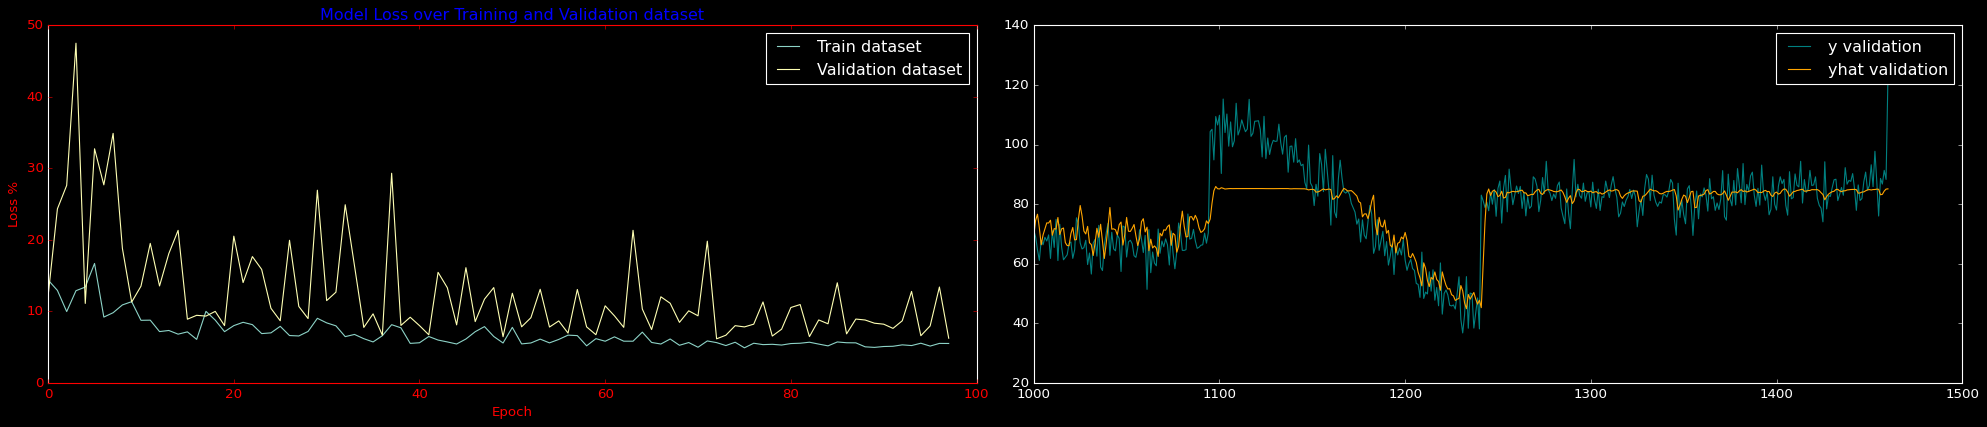

In [ ]:
fg, ax = plt.subplots( 1,2, figsize= (25,5.5) )
plot_loss(  model_fitting_obj= kseqRNN_model_fit_obj, ylim= [0,50], ax= ax[0]  )
model_predict_plot2(  split_line, y_tmSer, xval, yval, win_sz, model= kseqRNN_model, ax= ax[1]  )
plt.tight_layout()

<br>

### Long short-term memory


In [8]:
## y time series with:   Trend  +  Seasonality  +  Noise
baseline = 10 ;     slope_val = 0.05  ;  amp_val = 40 ;     noise_lvl = 5  ;   period_val = 365
win_sz = 20;         batch_sz = 32;              shuffle_buff_sz = 1000

tm1 = np.arange( stop= 4*365+1, dtype= np.float16 )
y_tmSer =  genr_trend( tm1, slope= slope_val, intercept= baseline ) \
                + genr_seasonality( tm1, period= period_val, amp= amp_val ) \
                + addNoise( tm1, noise_level= noise_lvl, seed= 42 )

## Train-Validation set split
split_line = 1000
xtrn =     tm1[ : split_line ]  ;         xval =     tm1[ split_line : ]
ytrn = y_tmSer[ : split_line ]  ;         yval = y_tmSer[ split_line : ]

## windowing the data
ytrn_win  =  genr_windowed_data(  Y_timeSeries= ytrn, window_size= win_sz,
                                  batch_size= batch_sz, shuffle_buffer= shuffle_buff_sz  )
yval_win  =  genr_windowed_data(  Y_timeSeries= yval, window_size= win_sz,
                                  batch_size= batch_sz, shuffle_buffer= shuffle_buff_sz  )
# plot
fg, ax = plt.subplots( figsize= (10,3.5) )
ax.plot( xtrn, ytrn );    ax.plot( xval, yval, color= 'gray' );             plt.tight_layout()

In [ ]:
keras.backend.clear_session()

In [21]:
keras.backend.clear_session()

kseqRNN_model = keras.models.Sequential(
                        [   keras.layers.Lambda(  lambda x: tf.expand_dims( x, axis= -1 )  ),
                            # bi directional LSTM
                            keras.layers.Bidirectional(  keras.layers.LSTM( units= 32, return_sequences= False )  ),
                            keras.layers.Dense(  units= 1  ),
                            keras.layers.Lambda(  lambda x: 100. * x  )
                        ]
                )

earlyStopMonitor_obj = keras.callbacks.EarlyStopping( monitor= 'val_loss', min_delta= 1e-2, patience= 25, mode= 'min', verbose= 1, restore_best_weights= True )

kseqRNN_model.compile(  optimizer= keras.optimizers.SGD( learning_rate= 5e-5, momentum= 0.90 ),
                        loss= keras.losses.Huber(), metrics= ['mae']  )

kseqRNN_model_fit_obj = kseqRNN_model.fit(  ytrn_win, validation_data= yval_win, epochs= 1000, callbacks= [earlyStopMonitor_obj], verbose= 1  )


Mean Absolute Error -->   6.73


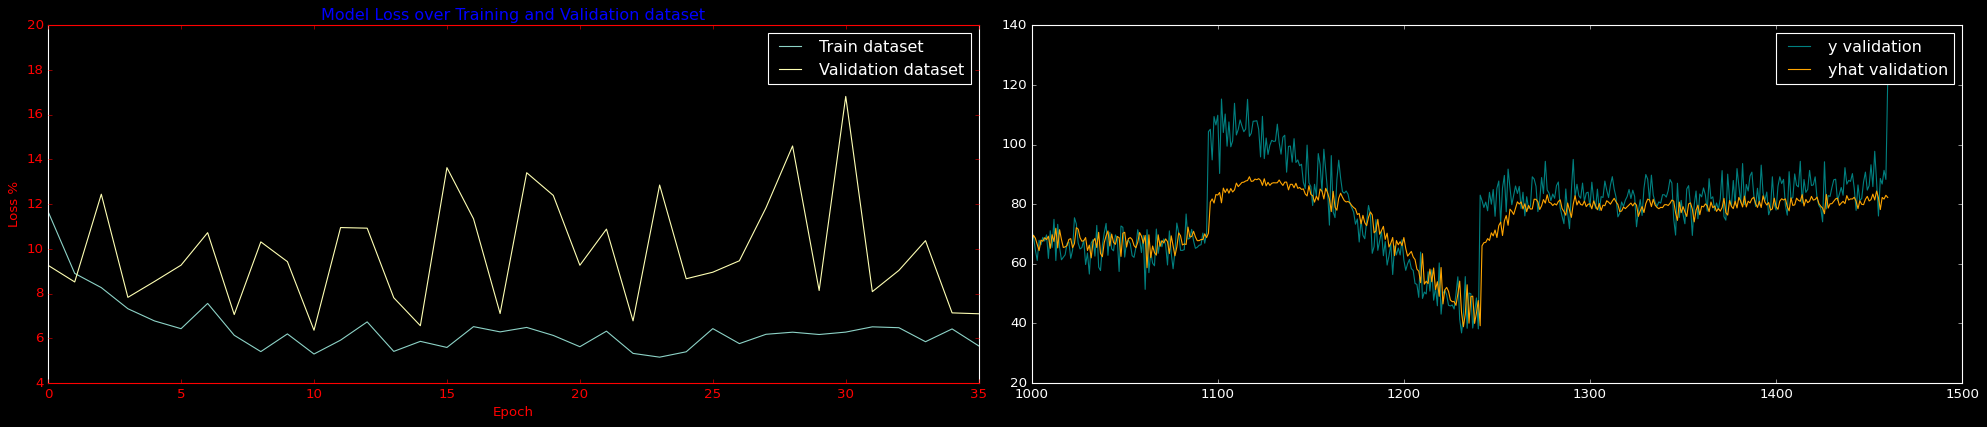

In [ ]:
fg, ax = plt.subplots( 1,2, figsize= (25,5.5) )
plot_loss(  model_fitting_obj= kseqRNN_model_fit_obj, ylim= [4,20], ax= ax[0]  )
model_predict_plot2(  split_line, y_tmSer, xval, yval, win_sz, model= kseqRNN_model, ax= ax[1]  )
plt.tight_layout()

##### adding mote LSTM layers with `return_sequences = True`

In [9]:
keras.backend.clear_session()

kseqRNN_model = keras.models.Sequential(
                        [
                            keras.layers.Lambda(  lambda x: tf.expand_dims( x, axis= -1 )  ),

                            # bi directional LSTMs
                            keras.layers.Bidirectional(  keras.layers.LSTM( units= 64,  return_sequences= True )  ),
                            keras.layers.Bidirectional(  keras.layers.LSTM( units= 64,  return_sequences= True )  ),
                            keras.layers.Bidirectional(  keras.layers.LSTM( units= 64, return_sequences= False )  ),

                            keras.layers.Dense(  units= 1  ),

                            keras.layers.Lambda(  lambda x: 100. * x  )
                        ]
                )

earlyStopMonitor_obj = keras.callbacks.EarlyStopping( monitor= 'val_loss', min_delta= 1e-2, patience= 25, mode= 'min', verbose= 1, restore_best_weights= True )

kseqRNN_model.compile(  optimizer= keras.optimizers.SGD( learning_rate= 5e-5, momentum= 0.90 ),
                        loss= keras.losses.Huber(), metrics= ['mae']  )

kseqRNN_model_fit_obj = kseqRNN_model.fit(  ytrn_win, validation_data= yval_win, epochs= 1000, callbacks= [earlyStopMonitor_obj], verbose= 1  )


Mean Absolute Error -->   6.73


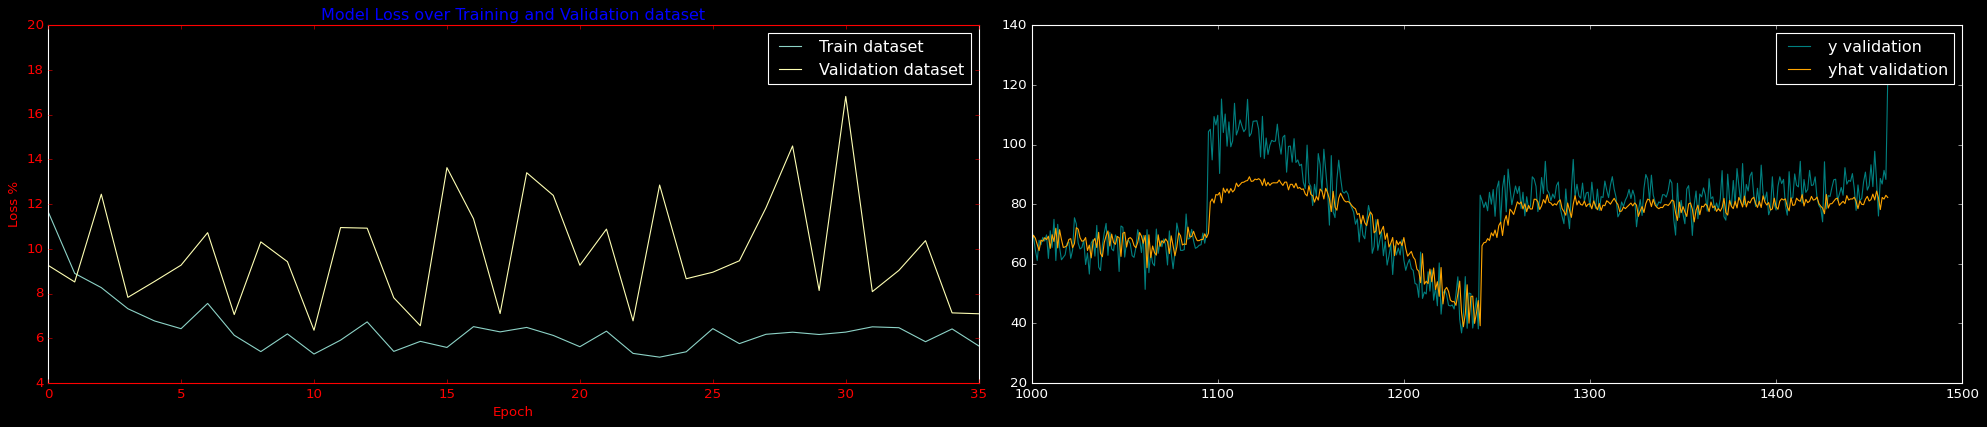

In [ ]:
fg, ax = plt.subplots( 1,2, figsize= (25,5.5) )
plot_loss(  model_fitting_obj= kseqRNN_model_fit_obj, ylim= [4,20], ax= ax[0]  )
model_predict_plot2(  split_line, y_tmSer, xval, yval, win_sz, model= kseqRNN_model, ax= ax[1]  )
plt.tight_layout()

<br> <hr> <br>

## Combining:
`Recurrent Neural Network `+ `Long short-term memory` +  `Convolutional Neural Networks`

    - Adding 1 - dimensional CNN on top of Recurrent Neural networks (RNN) & Long Short Term Memory (LSTM) for creating robust NN model.


<br>

### Adding CNN

<h3><p style= 'text-align:center;'>1 D Convolution Network</p></h3>
<img src= 'images/1D_Conv.jpg' style= 'width:2168;height:724;'>

<!-- m, wd, ht = 1.5, 799, 431; ( wd/m, ht/m  ) -->


<br>

(1460,) (1460,)
(1000,) (1000,) (460,) (460,)


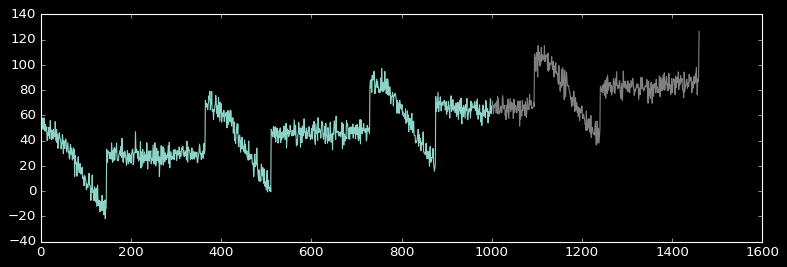

In [ ]:
## y time series with:   Trend  +  Seasonality  +  Noise
baseline = 10 ;     slope_val = 0.05  ;  amp_val = 40 ;     noise_lvl = 5  ;   period_val = 365
win_sz = 20;        batch_sz = 32;       shuffle_buff_sz = 1000
split_line = 1000

tm1 = np.arange( 1, stop= 4*365+1, dtype= np.float16 )
y_tmSer =  genr_trend( tm1, slope= slope_val, intercept= baseline ) \
                + genr_seasonality( tm1, period= period_val, amp= amp_val ) \
                + addNoise( tm1, noise_level= noise_lvl, seed= 42 )
print( tm1.shape, y_tmSer.shape )

## Train-Validation set split
split_line
xtrn =     tm1[ : split_line ]  ;         xval =     tm1[ split_line : ]
ytrn = y_tmSer[ : split_line ]  ;         yval = y_tmSer[ split_line : ]
print(  xtrn.shape, ytrn.shape, xval.shape, yval.shape )

## windowing the data
ytrn_win  =  genr_windowed_data(  Y_timeSeries= tf.expand_dims( ytrn, axis= -1 ),   # tf.expand_dims: reshapes the np array of size ( a, ) --> (a,1)
                                  window_size= win_sz, batch_size= batch_sz, shuffle_buffer= shuffle_buff_sz  )

yval_win  =  genr_windowed_data(  Y_timeSeries= tf.expand_dims( yval, axis= -1 ),
                                  window_size= win_sz, batch_size= batch_sz, shuffle_buffer= shuffle_buff_sz  )
# plot
fg, ax = plt.subplots( figsize= (10,3.5) )
ax.plot( xtrn, ytrn );    ax.plot( xval, yval, color= 'gray' );
plt.tight_layout()

In [ ]:
keras.backend.clear_session()

kseqRnnCnn_model = keras.models.Sequential(
                            [   # 1D CNN lyr
                                keras.layers.Conv1D(  filters= 32, kernel_size= 5, strides= 1, padding= 'causal', activation= 'relu', input_shape= [None,1]  ),

                                keras.layers.LSTM(  units= 32, return_sequences= True  ),
                                keras.layers.LSTM(  units= 32, return_sequences= True  ),

                                keras.layers.Dense(  units= 1  ),

                                keras.layers.Lambda(  lambda x: 100.*x  )    ]
                   )

earltStopMonitor_obj = keras.callbacks.EarlyStopping(  monitor= 'val_loss', min_delta= 1e-2, patience= 25,
                                                       mode= 'min', verbose= 1, restore_best_weights= True  )
kseqRnnCnn_model.compile(  optimizer= keras.optimizers.Adam( learning_rate= 1e-5 ),
                           loss= keras.losses.Huber(), metrics= ['mae']  )
kseqRnnCnn_modelFit = kseqRnnCnn_model.fit(  ytrn_win, validation_data= yval_win, epochs= 1000,
                                             callbacks= [earltStopMonitor_obj], verbose= 1 )

Epoch 1/1000
31/31 [==============================] - 3s 29ms/step - loss: 64.9454 - mae: 65.4451 - val_loss: 103.3655 - val_mae: 103.8655
Epoch 2/1000
31/31 [==============================] - 0s 11ms/step - loss: 60.4104 - mae: 60.9100 - val_loss: 98.6279 - val_mae: 99.1279
Epoch 3/1000
31/31 [==============================] - 0s 11ms/step - loss: 55.9690 - mae: 56.4684 - val_loss: 93.9558 - val_mae: 94.4558
Epoch 4/1000
31/31 [==============================] - 0s 10ms/step - loss: 51.6545 - mae: 52.1536 - val_loss: 89.3815 - val_mae: 89.8815
Epoch 5/1000
31/31 [==============================] - 0s 10ms/step - loss: 47.4948 - mae: 47.9937 - val_loss: 84.8743 - val_mae: 85.3743
Epoch 6/1000
31/31 [==============================] - 0s 10ms/step - loss: 43.5147 - mae: 44.0136 - val_loss: 80.4627 - val_mae: 80.9627
Epoch 7/1000
31/31 [==============================] - 0s 10ms/step - loss: 39.6980 - mae: 40.1967 - val_loss: 76.1794 - val_mae: 76.6794
Epoch 8/1000
31/31 [===================

31/31 [==============================] - 0s 10ms/step - loss: 7.7402 - mae: 8.2220 - val_loss: 13.5924 - val_mae: 14.0830
Epoch 121/1000
31/31 [==============================] - 0s 10ms/step - loss: 7.7261 - mae: 8.2079 - val_loss: 12.8759 - val_mae: 13.3668
Epoch 122/1000
31/31 [==============================] - 0s 10ms/step - loss: 7.7046 - mae: 8.1862 - val_loss: 13.0088 - val_mae: 13.5003
Epoch 123/1000
31/31 [==============================] - 0s 10ms/step - loss: 7.6872 - mae: 8.1690 - val_loss: 13.2303 - val_mae: 13.7217
Epoch 124/1000
31/31 [==============================] - 0s 9ms/step - loss: 7.6765 - mae: 8.1581 - val_loss: 13.3575 - val_mae: 13.8482
Epoch 125/1000
31/31 [==============================] - 0s 10ms/step - loss: 7.6532 - mae: 8.1346 - val_loss: 12.8589 - val_mae: 13.3502
Epoch 126/1000
31/31 [==============================] - 0s 10ms/step - loss: 7.6341 - mae: 8.1154 - val_loss: 12.9027 - val_mae: 13.3941
Epoch 127/1000
31/31 [==============================] - 0

Epoch 180/1000
31/31 [==============================] - 0s 10ms/step - loss: 7.0073 - mae: 7.4883 - val_loss: 11.2031 - val_mae: 11.6929
Epoch 181/1000
31/31 [==============================] - 0s 10ms/step - loss: 6.9929 - mae: 7.4737 - val_loss: 11.2010 - val_mae: 11.6909
Epoch 182/1000
31/31 [==============================] - 0s 10ms/step - loss: 6.9950 - mae: 7.4761 - val_loss: 11.3693 - val_mae: 11.8596
Epoch 183/1000
31/31 [==============================] - 0s 10ms/step - loss: 6.9895 - mae: 7.4705 - val_loss: 11.6262 - val_mae: 12.1173
Epoch 184/1000
31/31 [==============================] - 0s 10ms/step - loss: 6.9766 - mae: 7.4572 - val_loss: 11.1157 - val_mae: 11.6053
Epoch 185/1000
31/31 [==============================] - 0s 10ms/step - loss: 6.9672 - mae: 7.4482 - val_loss: 11.1256 - val_mae: 11.6153
Epoch 186/1000
31/31 [==============================] - 0s 10ms/step - loss: 6.9588 - mae: 7.4405 - val_loss: 11.0679 - val_mae: 11.5574
Epoch 187/1000
31/31 [===================

31/31 [==============================] - 0s 10ms/step - loss: 6.5570 - mae: 7.0361 - val_loss: 9.3461 - val_mae: 9.8350
Epoch 300/1000
31/31 [==============================] - 0s 10ms/step - loss: 6.5444 - mae: 7.0238 - val_loss: 9.7862 - val_mae: 10.2750
Epoch 301/1000
31/31 [==============================] - 0s 10ms/step - loss: 6.5513 - mae: 7.0312 - val_loss: 9.3475 - val_mae: 9.8364
Epoch 302/1000
31/31 [==============================] - 0s 10ms/step - loss: 6.5414 - mae: 7.0208 - val_loss: 9.6672 - val_mae: 10.1561
Epoch 303/1000
31/31 [==============================] - 0s 10ms/step - loss: 6.5480 - mae: 7.0275 - val_loss: 9.6141 - val_mae: 10.1029
Epoch 304/1000
31/31 [==============================] - 0s 10ms/step - loss: 6.5417 - mae: 7.0214 - val_loss: 9.4428 - val_mae: 9.9315
Epoch 305/1000
31/31 [==============================] - 0s 10ms/step - loss: 6.5329 - mae: 7.0126 - val_loss: 9.4580 - val_mae: 9.9467
Epoch 306/1000
31/31 [==============================] - 0s 10ms/ste


Mean Absolute Error -->   19.11


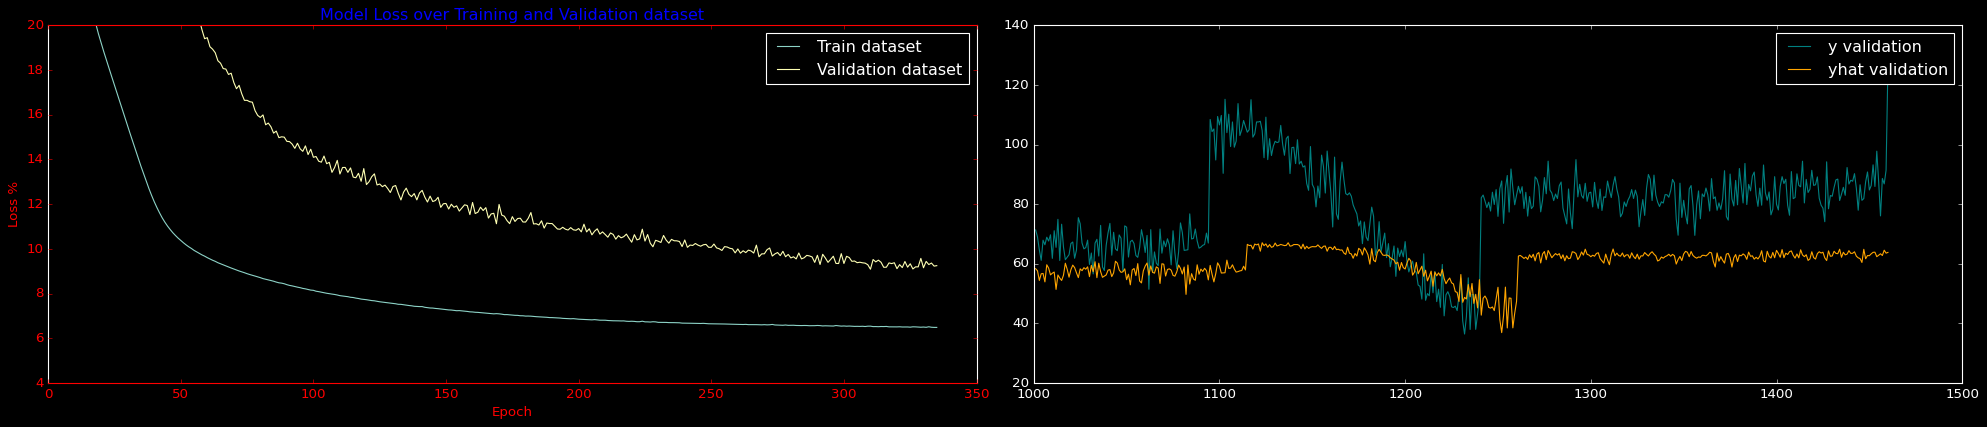

In [ ]:
fg, ax = plt.subplots( 1,2, figsize= (25,5.5) )
plot_loss(  model_fitting_obj= kseqRnnCnn_modelFit, ylim= [4,20], ax= ax[0]  )
model_predict_plot_val(  split_line, y_tmSer, xval, yval, win_sz, model= kseqRnnCnn_model, ax= ax[1]  )
plt.tight_layout()

In [4]:
keras.backend.clear_session()

kseqRnnCnn_model = keras.models.Sequential(
                            [   # 1D CNN lyr
                                keras.layers.Conv1D(  filters= 32, kernel_size= 5, strides= 1, padding= 'causal', activation= 'relu', input_shape= [None,1]  ),

                                keras.layers.LSTM(  units= 32, return_sequences= True  ),
                                keras.layers.Bidirectional(  keras.layers.LSTM(  units= 32, return_sequences= True  )  ),
                                keras.layers.Bidirectional(  keras.layers.LSTM(  units= 32, return_sequences= True  )  ),

                                keras.layers.Dense(  units= 1  ),

                                keras.layers.Lambda(  lambda x: 200.*x  )
                            ]
                   )

earltStopMonitor_obj = keras.callbacks.EarlyStopping(  monitor= 'val_loss', min_delta= 1e-2, patience= 25, mode= 'min', verbose= 1, restore_best_weights= True  )

kseqRnnCnn_model.compile(  optimizer= keras.optimizers.Adam( learning_rate= 1e-5 ), loss= keras.losses.Huber(), metrics= ['mae']  )

kseqRnnCnn_modelFit = kseqRnnCnn_model.fit(  ytrn_win, validation_data= yval_win, epochs= 1000, callbacks= [earltStopMonitor_obj], verbose= 1 )


Mean Absolute Error -->   6.65


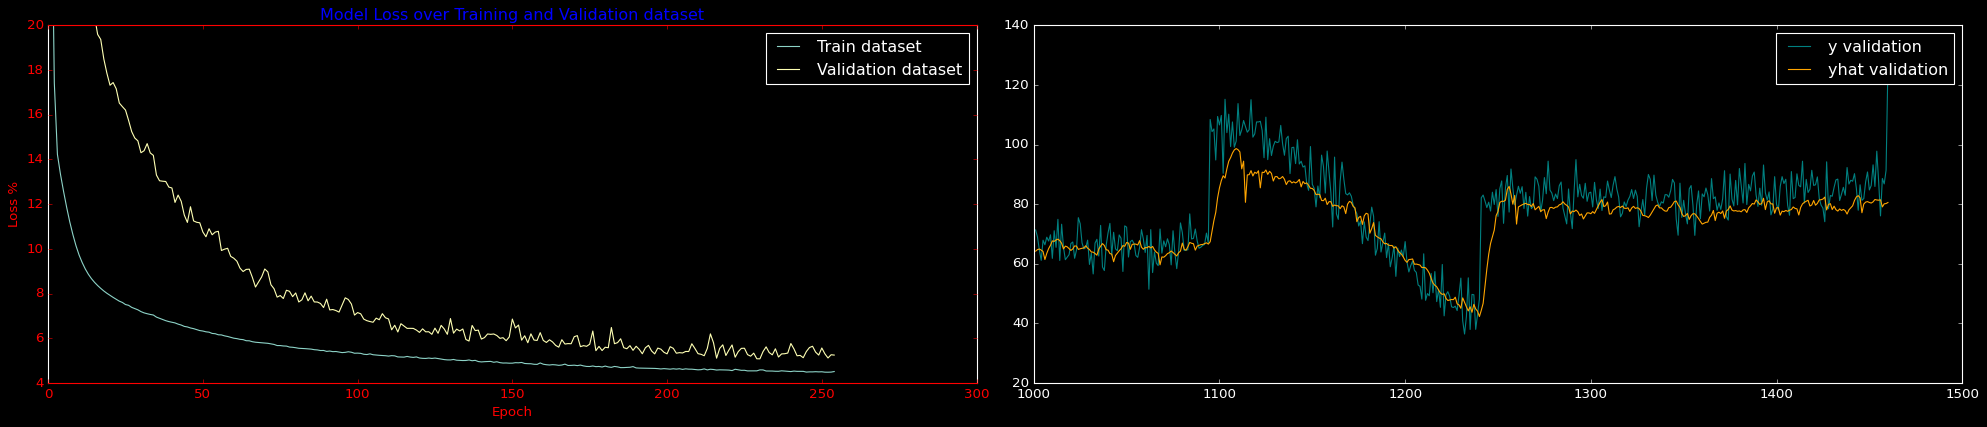

In [ ]:
fg, ax = plt.subplots( 1,2, figsize= (25,5.5) )
plot_loss(  model_fitting_obj= kseqRnnCnn_modelFit, ylim= [4,20], ax= ax[0]  )
model_predict_plot2(  split_line, y_tmSer, xval, yval, win_sz, model= kseqRnnCnn_model, ax= ax[1]  )
plt.tight_layout()

considering the best model among them, and changing batch size

In [5]:
## y time series with:   Trend  +  Seasonality  +  Noise
batch_sz = 16;

## windowing the data
ytrn_win  =  genr_windowed_data(  Y_timeSeries= tf.expand_dims( ytrn, axis= -1 ),   # tf.expand_dims: reshapes the np array of size ( a, ) --> (a,1)
                                  window_size= win_sz, batch_size= batch_sz, shuffle_buffer= shuffle_buff_sz  )

yval_win  =  genr_windowed_data(  Y_timeSeries= tf.expand_dims( yval, axis= -1 ),
                                  window_size= win_sz, batch_size= batch_sz, shuffle_buffer= shuffle_buff_sz  )

# NN model

keras.backend.clear_session()

kseqRnnCnn_model = keras.models.Sequential(
                            [   # 1D CNN lyr
                                keras.layers.Conv1D(  filters= 32, kernel_size= 5, strides= 1, padding= 'causal', activation= 'relu', input_shape= [None,1]  ),

                                keras.layers.LSTM(  units= 32, return_sequences= True  ),
                                keras.layers.Bidirectional(  keras.layers.LSTM(  units= 32, return_sequences= True  )  ),
                                keras.layers.Bidirectional(  keras.layers.LSTM(  units= 32, return_sequences= True  )  ),

                                keras.layers.Dense(  units= 1  ),

                                keras.layers.Lambda(  lambda x: 200.*x  )
                            ]
                   )

earltStopMonitor_obj = keras.callbacks.EarlyStopping(  monitor= 'val_loss', min_delta= 1e-2, patience= 25, mode= 'min', verbose= 1, restore_best_weights= True  )

kseqRnnCnn_model.compile(  optimizer= keras.optimizers.Adam( learning_rate= 1e-5 ), loss= keras.losses.Huber(), metrics= ['mae']  )

kseqRnnCnn_modelFit = kseqRnnCnn_model.fit(  ytrn_win, validation_data= yval_win, epochs= 1000, callbacks= [earltStopMonitor_obj], verbose= 1 )

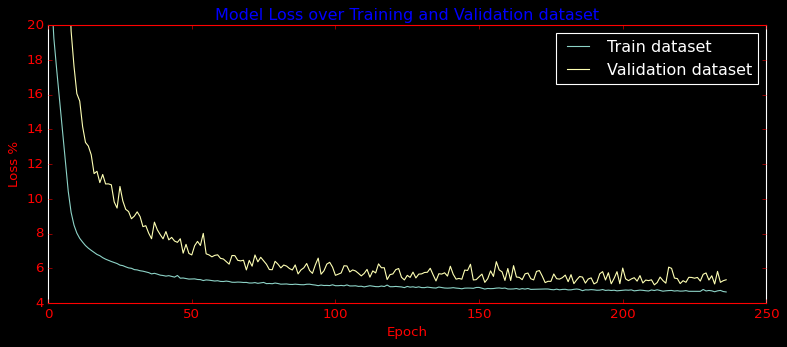


Mean Absolute Error -->   5.86


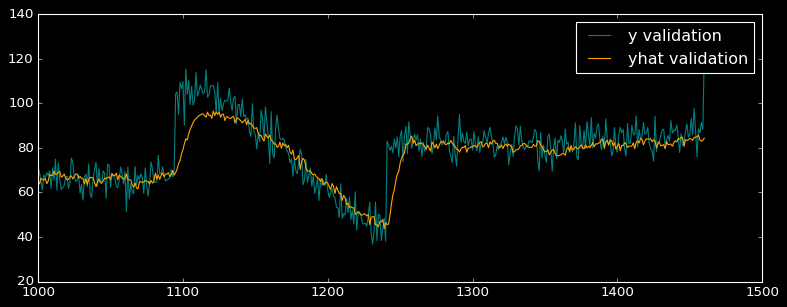

In [ ]:
fg, ax = plt.subplots( 1,2, figsize= (25,5.5) )
plot_loss(  model_fitting_obj= kseqRnnCnn_modelFit, ylim= [4,20], ax= ax[0]  )
model_predict_plot2(  split_line, y_tmSer, xval, yval, win_sz, model= kseqRnnCnn_model, ax= ax[1]  )
plt.tight_layout()

In [10]:
batch_sz = 8
## windowing the data
ytrn_win  =  genr_windowed_data(  Y_timeSeries= tf.expand_dims( ytrn, axis= -1 ),   # tf.expand_dims: reshapes the np array of size ( a, ) --> (a,1)
                                  window_size= win_sz, batch_size= batch_sz, shuffle_buffer= shuffle_buff_sz  )
yval_win  =  genr_windowed_data(  Y_timeSeries= tf.expand_dims( yval, axis= -1 ),
                                  window_size= win_sz, batch_size= batch_sz, shuffle_buffer= shuffle_buff_sz  )
## NN model
keras.backend.clear_session()
kseqRnnCnn_model = keras.models.Sequential(
                            [
                                # 1D CNN lyr
                                keras.layers.Conv1D(  filters= 32, kernel_size= 5, strides= 1, padding= 'causal', activation= 'relu', input_shape= [None,1]  ),

                                keras.layers.LSTM(  units= 32, return_sequences= True  ),
                                keras.layers.Bidirectional(  keras.layers.LSTM(  units= 32, return_sequences= True  )  ),
                                keras.layers.Bidirectional(  keras.layers.LSTM(  units= 32, return_sequences= True  )  ),

                                keras.layers.Dense(  units= 1  ),

                                keras.layers.Lambda(  lambda x: 200.*x  )
                            ]
                   )
earlyStopMonitor_obj = keras.callbacks.EarlyStopping(  monitor= 'val_loss', min_delta= 1e-2, patience= 25, mode= 'min', verbose= 1, restore_best_weights= True  )
kseqRnnCnn_model.compile(  optimizer= keras.optimizers.Adam( learning_rate= 1e-5 ), loss= keras.losses.Huber(), metrics= ['mae']  )
kseqRnnCnn_modelFit = kseqRnnCnn_model.fit(  ytrn_win, validation_data= yval_win, epochs= 1000, callbacks= [earlyStopMonitor_obj], verbose= 1 )


Mean Absolute Error -->   6.47


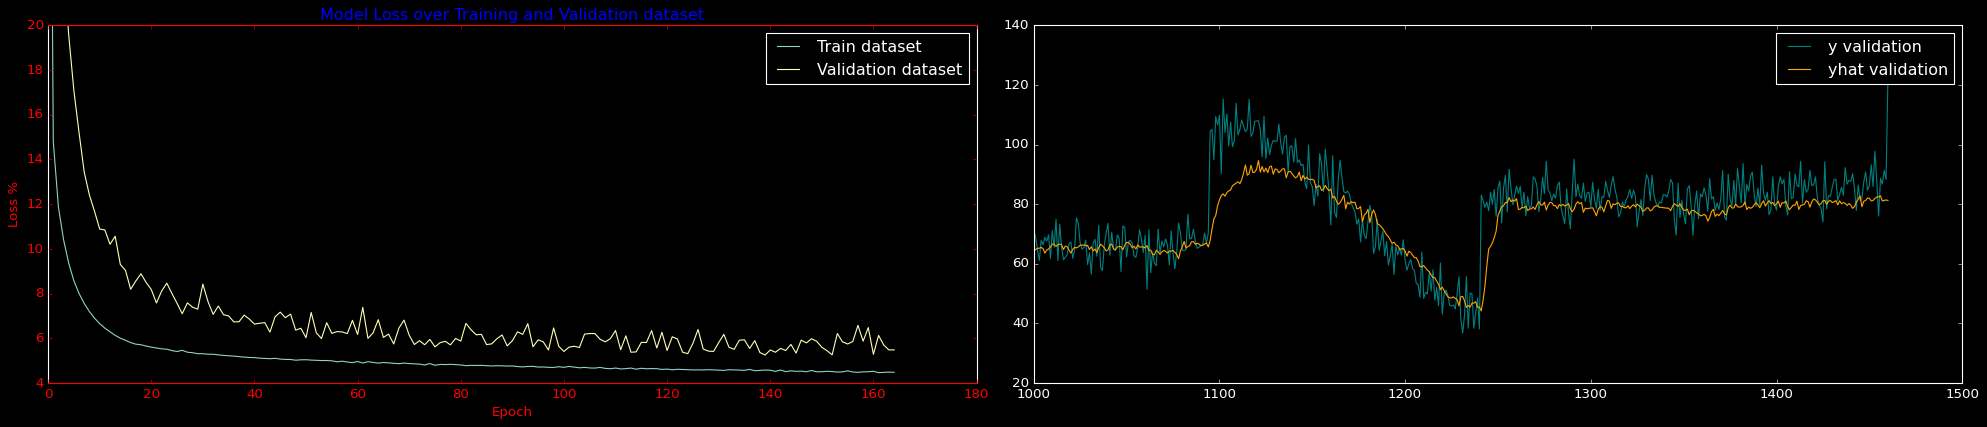

In [ ]:
fg, ax = plt.subplots( 1,2, figsize= (25,5.5) )
plot_loss(  model_fitting_obj= kseqRnnCnn_modelFit, ylim= [4,20], ax= ax[0]  )
model_predict_plot2(  split_line, y_tmSer, xval, yval, win_sz, model= kseqRnnCnn_model, ax= ax[1]  )
plt.tight_layout()

<br>

### Putting it all together for Sunset dataset


(3235, 3) 

    idx        date  sunspot_num
0    0  1749-01-31         96.7
1    1  1749-02-28        104.3
2    2  1749-03-31        116.7


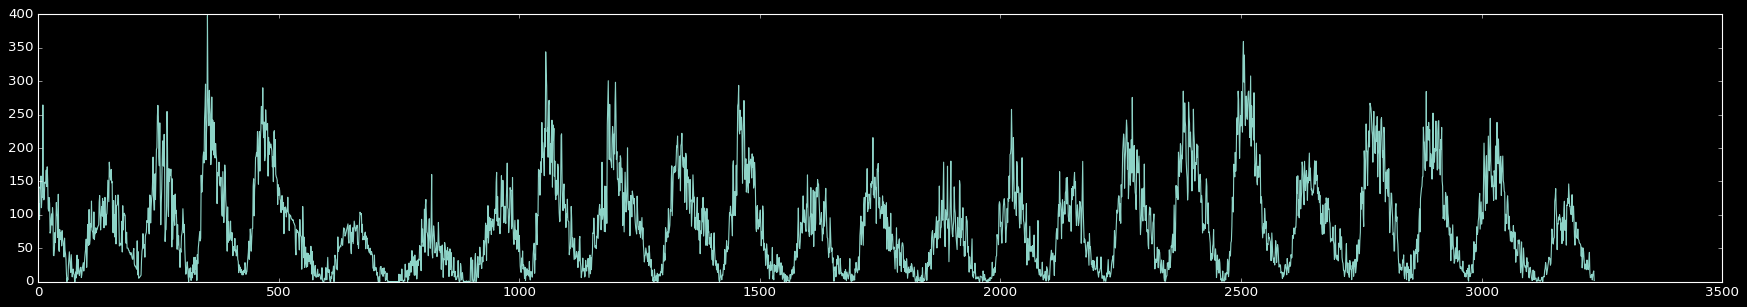

In [ ]:
sun_df =  pd.read_csv(  'datasets/Sunspots.csv', names= [ 'idx', 'date','sunspot_num' ], skiprows= 1 )
sun_df.sunspot_num.plot( figsize= (22,4) ); plt.tight_layout()

print(  sun_df.shape, '\n\n', sun_df.head(3) )

In [ ]:
## train-validation split

tm1 = sun_df.idx.values;    y_tmSer = sun_df.sunspot_num.values

split_line = 2700

xtrn = tm1[ : split_line ] ;                   xval = tm1[ split_line :  ]
ytrn = y_tmSer[ : split_line ] ;              yval = y_tmSer[ split_line : ]
ytrn = tf.expand_dims( ytrn, axis= -1 );      yval = tf.expand_dims( yval, axis= -1 )  # tf.expand_dims: reshapes the np array of size ( a, ) --> (a,1)

## windowing the data
win_sz = 60;   batch_sz = 8;   shuffle_buff_sz = 1000

ytrn_win  =  genr_windowed_data(  Y_timeSeries= ytrn, window_size= win_sz, batch_size= batch_sz, shuffle_buffer= shuffle_buff_sz  )
yval_win  =  genr_windowed_data(  Y_timeSeries= yval, window_size= win_sz, batch_size= batch_sz, shuffle_buffer= shuffle_buff_sz  )

#### DNN model


In [11]:
num_features = win_sz

kseq_model = keras.models.Sequential(
                     [   keras.layers.Dense( units= 20, input_shape= [ num_features ], activation= 'relu' ),
                         keras.layers.Dense( units= 10, activation= 'relu' ),
                         keras.layers.Dense( units= 1 )   ]
            )

earlyStopMonitor_obj = keras.callbacks.EarlyStopping( monitor= 'val_loss', min_delta= 1e-2, patience= 25, mode= 'auto', verbose= 1  )
kseq_model.compile( optimizer= keras.optimizers.SGD( learning_rate= 1e-7, momentum= 0.9 ), loss= 'mae' )
kseq_modelFit = kseq_model.fit( ytrn_win, validation_data= yval_win, epochs= 1000, callbacks= [earlyStopMonitor_obj], verbose= 1 )


Mean Absolute Error -->   17.38


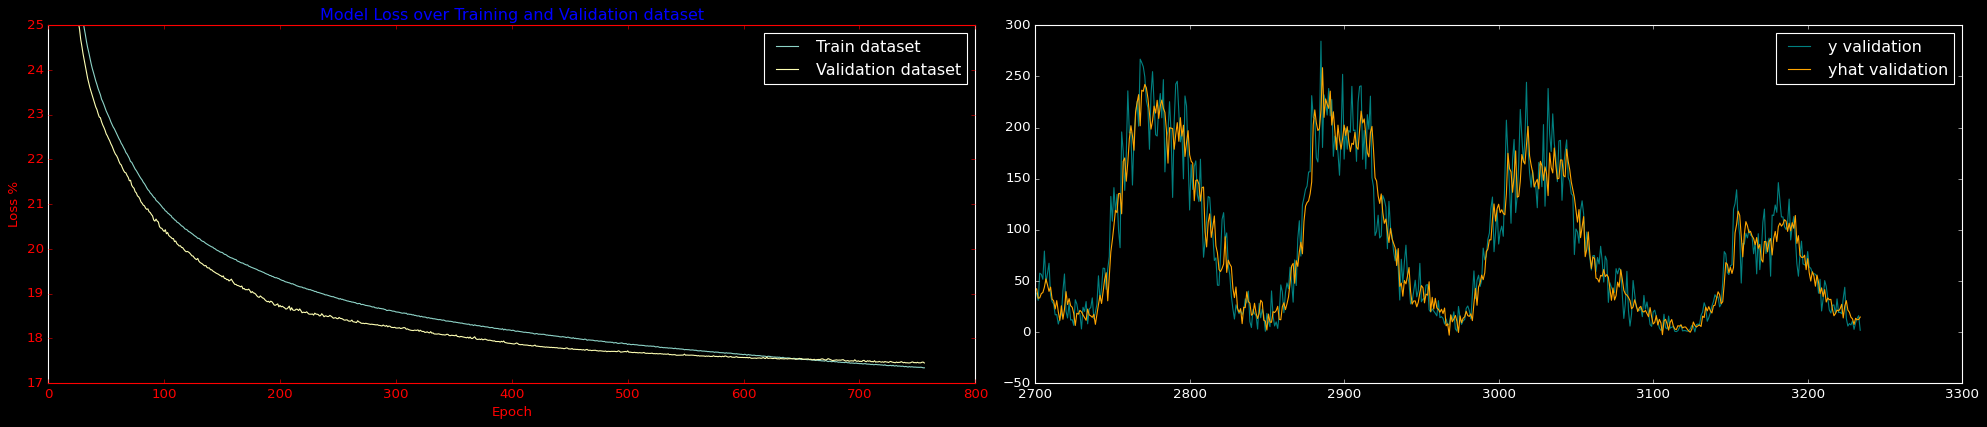

In [ ]:
fg, ax = plt.subplots( 1,2, figsize= (25,5.5) )
plot_loss(  model_fitting_obj= kseq_modelFit, ylim= [17,25], ax= ax[0]  )
model_predict_plot2(  split_line, y_tmSer, xval, yval, win_sz, model= kseq_model, ax= ax[1]  )
plt.tight_layout()

#### RNN model

     - 1st try on RNN model

In [6]:
ytrn = tf.expand_dims( ytrn, axis= -1 );      yval = tf.expand_dims( yval, axis= -1 )  # tf.expand_dims: reshapes the np array of size ( a, ) --> (a,1)

## windowing the data
win_sz = 60;   batch_sz = 8;   shuffle_buff_sz = 1000

ytrn_win  =  genr_windowed_data(  Y_timeSeries= ytrn, window_size= win_sz, batch_size= batch_sz, shuffle_buffer= shuffle_buff_sz  )
yval_win  =  genr_windowed_data(  Y_timeSeries= yval, window_size= win_sz, batch_size= batch_sz, shuffle_buffer= shuffle_buff_sz  )

kseq_model = keras.models.Sequential(
                    [
                        Conv1D(  filters= 60, kernel_size= 5, strides= 1, padding= 'causal', activation= 'relu', input_shape= [ None, 1 ]  ),

                        LSTM(  units= 60, return_sequences= True  ),
                        LSTM(  units= 60, return_sequences= True  ),

                        Dense(  units= 30, activation= 'relu' ),
                        Dense(  units= 10, activation= 'relu' ),
                        Dense(  units=  1, activation= 'relu' ),

                        Lambda( lambda x: 400 * x )
                    ]
             )

earlyStopMonitor_obj = keras.callbacks.EarlyStopping(  monitor= 'val_loss', min_delta= 1e-2, patience= 25, mode= 'min', verbose= 1  )
kseq_model.compile(  optimizer= keras.optimizers.Adam( learning_rate= 1e-5 ), loss= keras.losses.Huber(), metrics= ['mae']  )
kseq_modelFit = kseq_model.fit(  ytrn_win, validation_data= yval_win, callbacks= [ earlyStopMonitor_obj ], epochs= 50, verbose= 1  )


Mean Absolute Error -->   52.14


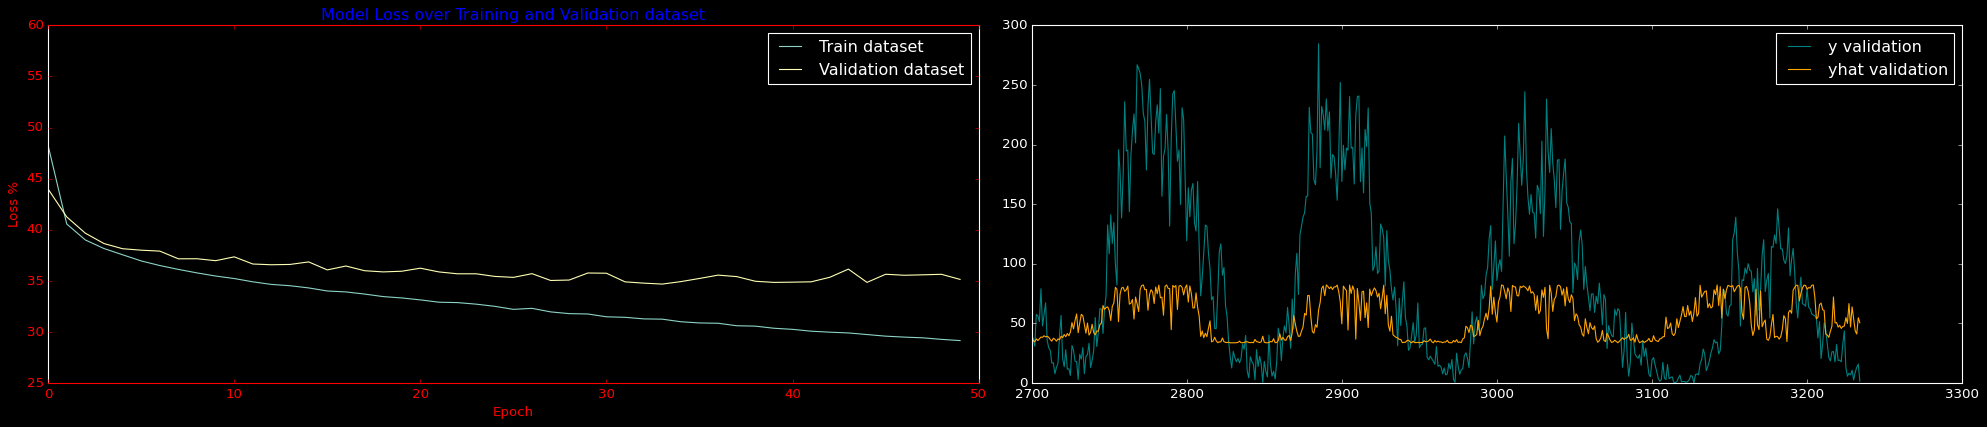

In [ ]:
fg, ax = plt.subplots( 1,2, figsize= (25,5.5) )
plot_loss(  model_fitting_obj= kseq_modelFit, ylim= [25,60], ax= ax[0]  )
model_predict_plot2(  split_line, y_tmSer, xval, yval.numpy()[ :,:,0 ], win_sz, model= kseq_model, ax= ax[1]  )
plt.tight_layout()

#### Convolution layer + LSTM with Bidirectional

In [12]:
## data preprocess

xtrn = tm1[ : split_line ] ;                   xval = tm1[ split_line :  ]
ytrn = y_tmSer[ : split_line ] ;              yval = y_tmSer[ split_line : ]
ytrn = tf.expand_dims( ytrn, axis= -1 );      yval = tf.expand_dims( yval, axis= -1 )  # tf.expand_dims: reshapes the np array of size ( a, ) --> (a,1)
# windowing the data
win_sz = 60;   batch_sz = 8;   shuffle_buff_sz = 1000
ytrn_win  =  genr_windowed_data(  Y_timeSeries= ytrn, window_size= win_sz, batch_size= batch_sz, shuffle_buffer= shuffle_buff_sz  )
yval_win  =  genr_windowed_data(  Y_timeSeries= yval, window_size= win_sz, batch_size= batch_sz, shuffle_buffer= shuffle_buff_sz  )

## NN model

keras.backend.clear_session()

kseq_model = keras.models.Sequential(
                    [
                        Conv1D(  filters= 32, kernel_size= 5, strides= 1, padding= 'causal', activation= 'relu', input_shape= [None,1]  ),

                        LSTM(  units= 32, return_sequences= True  ),

                        Bidirectional(  LSTM( units= 32, return_sequences= True )  ),
                        Bidirectional(  LSTM( units= 32, return_sequences= True )  ),

                        Dense(  units= 1  ),

                        Lambda(  lambda x: 400*x  )
                    ]
             )

earlyStopMonitor_obj = keras.callbacks.EarlyStopping( monitor= 'val_loss', min_delta= 1e-1, patience= 25, mode= 'auto', restore_best_weights= True, verbose= 1  )
kseq_model.compile(  optimizer= keras.optimizers.Adam( learning_rate= 1e-5 ), loss= keras.losses.Huber(), metrics= ['mae']  )
kseq_modelFit = kseq_model.fit(  ytrn_win, validation_data= yval_win, callbacks= earlyStopMonitor_obj, epochs= 1000, verbose= 1  )


Mean Absolute Error -->   20.06


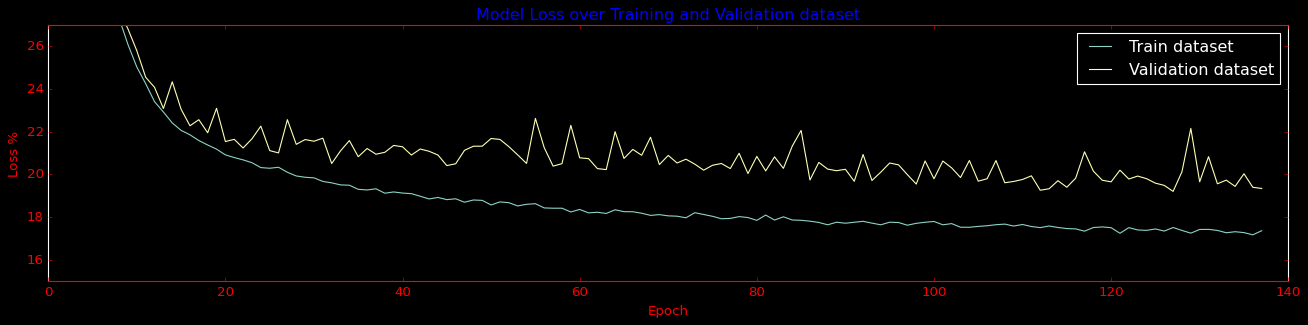

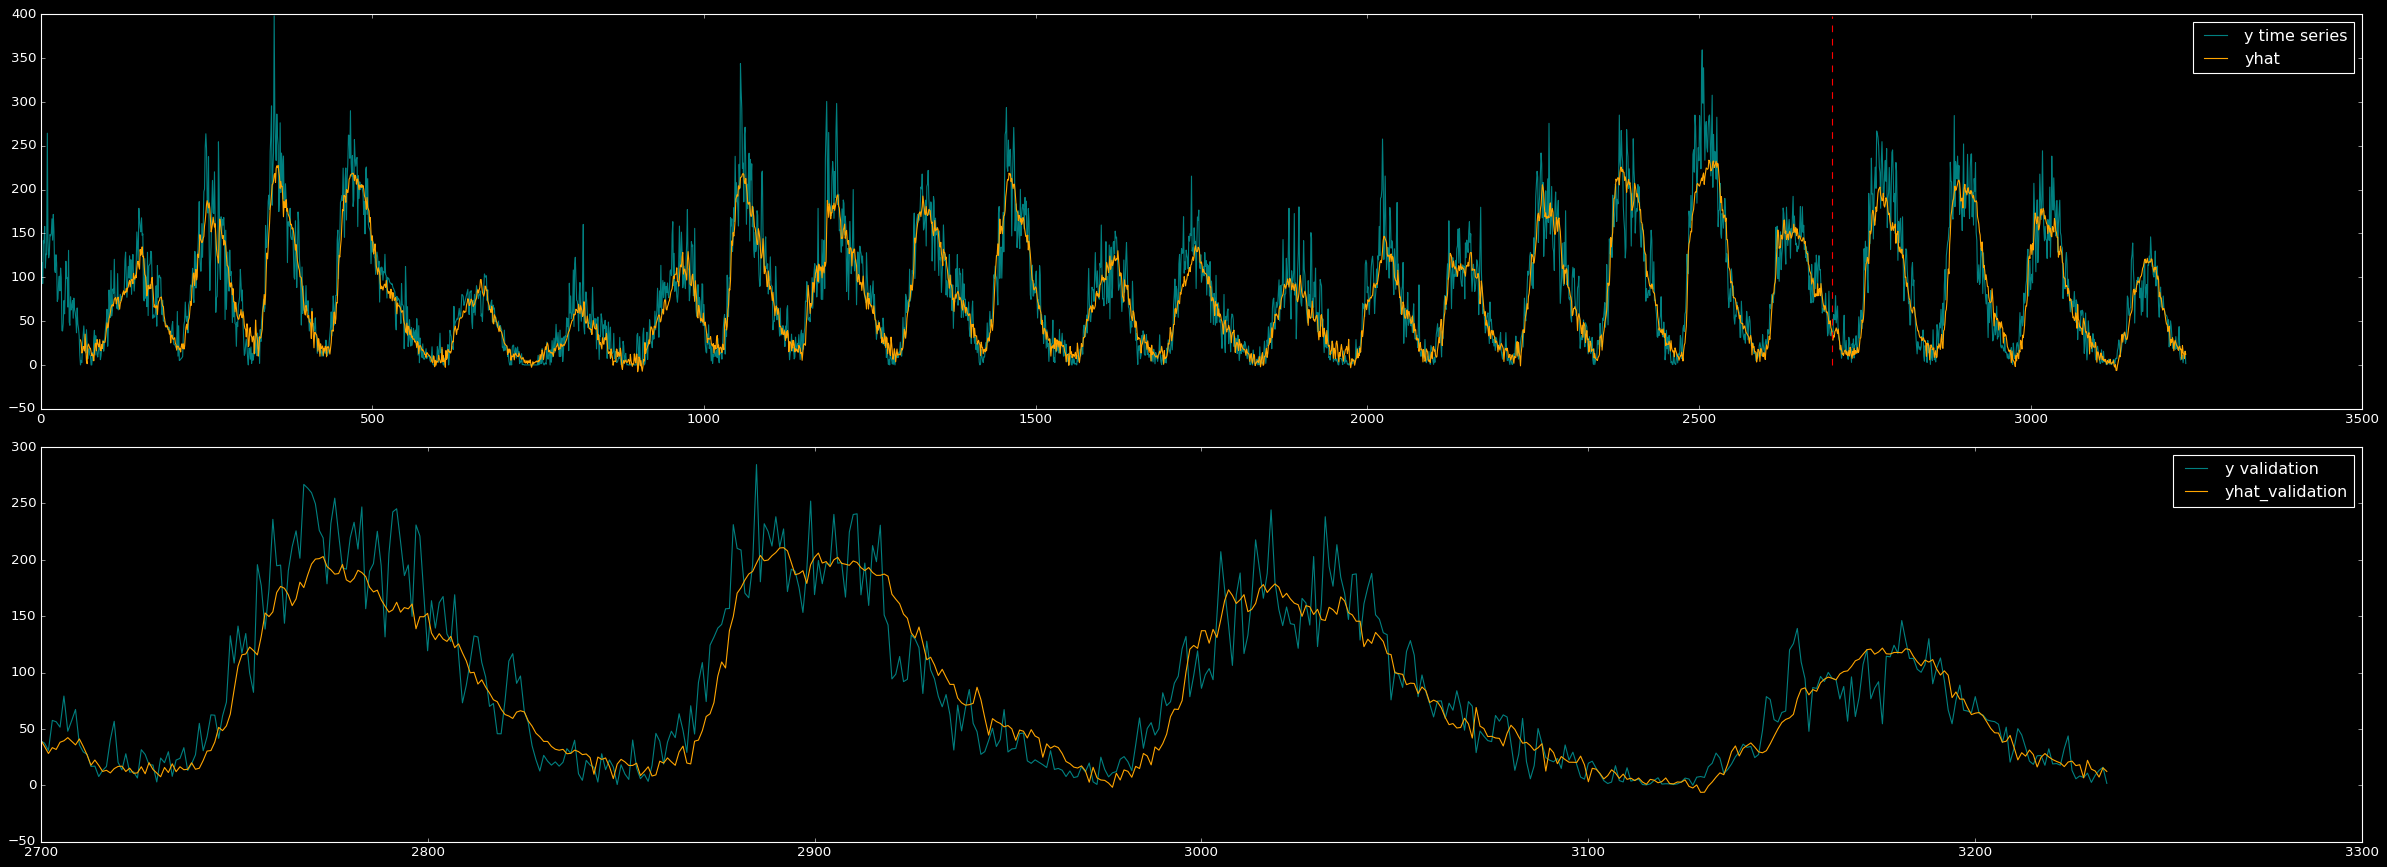

In [ ]:
plot_loss(  model_fitting_obj= kseq_modelFit, ylim= [15,27], figsz= (20,4)  )
model_predict_plot_all(  split_line, tm1, y_tmSer, xval, yval, win_sz, model= kseq_model  )

#### ramped up RNN + CNN + LSTM

In [13]:
## data preprocess

xtrn = tm1[ : split_line ] ;                   xval = tm1[ split_line :  ]
ytrn = y_tmSer[ : split_line ] ;              yval = y_tmSer[ split_line : ]
ytrn = tf.expand_dims( ytrn, axis= -1 );      yval = tf.expand_dims( yval, axis= -1 )  # tf.expand_dims: reshapes the np array of size ( a, ) --> (a,1)
# windowing the data
win_sz = 60;   batch_sz = 8;   shuffle_buff_sz = 1000
ytrn_win  =  genr_windowed_data(  Y_timeSeries= ytrn, window_size= win_sz, batch_size= batch_sz, shuffle_buffer= shuffle_buff_sz  )
yval_win  =  genr_windowed_data(  Y_timeSeries= yval, window_size= win_sz, batch_size= batch_sz, shuffle_buffer= shuffle_buff_sz  )

## NN model

keras.backend.clear_session()

kseq_model = keras.models.Sequential(
                    [
                        Conv1D(  filters= 32, kernel_size= 5, strides= 1, padding= 'causal', activation= 'relu', input_shape= [None,1]  ),
                        Conv1D(  filters= 32, kernel_size= 5, strides= 1, padding= 'causal', activation= 'relu'  ),
                        Conv1D(  filters= 32, kernel_size= 5, strides= 1, padding= 'causal', activation= 'relu'  ),

                        LSTM(  units= 32, return_sequences= True  ),
                        LSTM(  units= 32, return_sequences= True  ),

                        Bidirectional(  LSTM( units= 32, return_sequences= True )  ),
                        Bidirectional(  LSTM( units= 32, return_sequences= True )  ),
                        Bidirectional(  LSTM( units= 32, return_sequences= True )  ),

                        Dense( units= 32, activation= 'relu' ),
                        Dense( units= 32, activation= 'relu' ),

                        Dense(  units= 1  ),

                        Lambda(  lambda x: 400*x  )
                    ]
             )

earlyStopMonitor_obj = keras.callbacks.EarlyStopping( monitor= 'val_loss', min_delta= 1e-1, patience= 25, mode= 'auto', restore_best_weights= True, verbose= 1  )
kseq_model.compile(  optimizer= keras.optimizers.Adam( learning_rate= 1e-5 ), loss= keras.losses.Huber(), metrics= ['mae']  )
kseq_modelFit = kseq_model.fit(  ytrn_win, validation_data= yval_win, callbacks= earlyStopMonitor_obj, epochs= 1000, verbose= 1  )


Mean Absolute Error -->   20.06


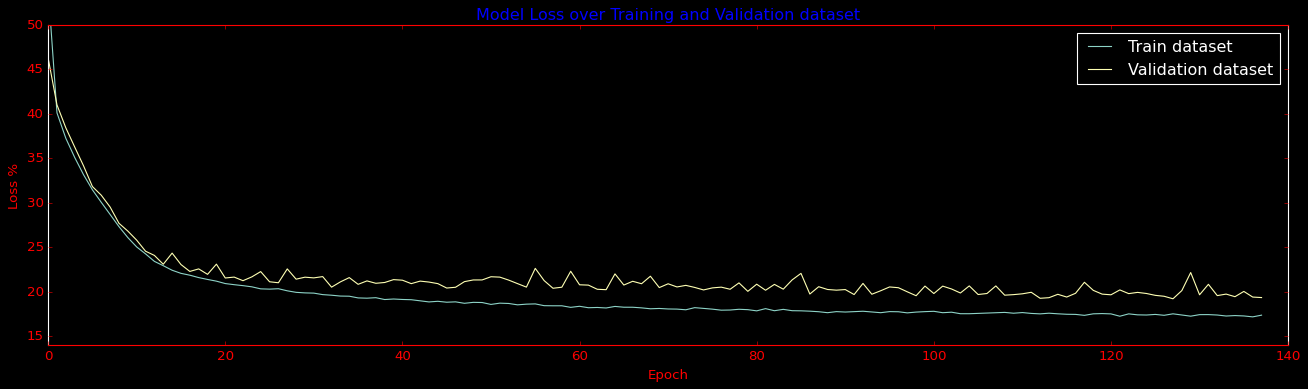

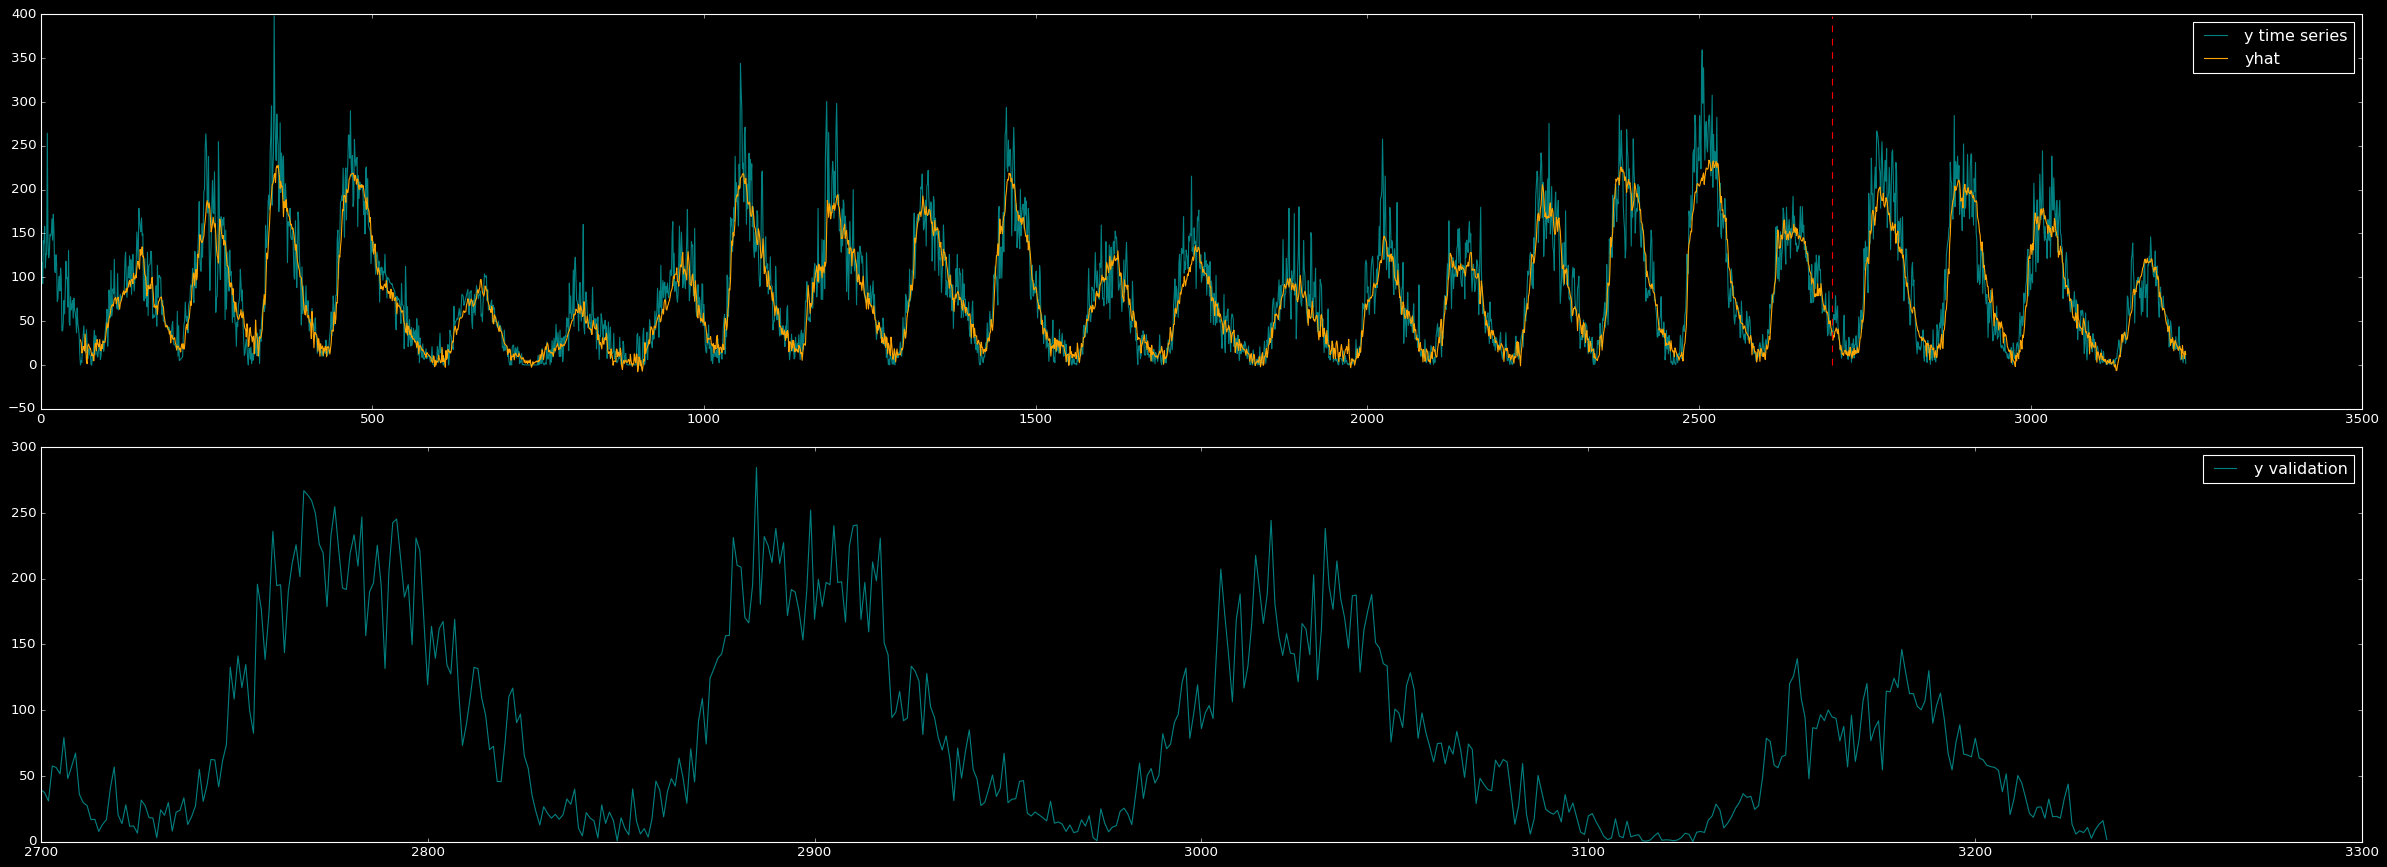

In [ ]:
plot_loss(  model_fitting_obj= kseq_modelFit, ylim= [14,50], figsz= (20,5)  )
model_predict_plot_all(  split_line, tm1, y_tmSer, xval, yval, win_sz, model= kseq_model  )